# Description - Datasets

Let us now take a closer look on the characterisitcs of our aggregrated data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import shapely
import hashlib
import holidays
from shapely import Point, wkt
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Load and prepare data

In [2]:
data_month_double = '07'

In [3]:
# read final data
data = pd.read_csv("../Data/20_Final_Data.csv")

/tmp/ipykernel_3118112/974816303.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../../20_Final_Data_NEW_TEST.csv")


In [4]:
tier = pd.read_parquet("../Data/12_tier_part2.parquet")
next = pd.read_parquet("../Data/15_nextbike_part2.parquet")

In [5]:
tier['trip_duration_seconds'] = tier['trip_duration'].dt.total_seconds()
next['trip_duration_seconds'] = next['trip_duration'].dt.total_seconds()

In [6]:
# transform geometry
data['station_point'] = data['station_point'].apply(wkt.loads)

In [7]:
data['buffer_zone'] = shapely.wkt.loads(data['buffer_zone'])

In [8]:
data = gpd.GeoDataFrame(data, geometry='station_point')

In [9]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

In [10]:
#data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], inplace=True)

In [11]:
data['actual_arrival_time'] = pd.to_datetime(data['actual_arrival_time'])
data['actual_departure_time'] = pd.to_datetime(data['actual_departure_time'])
data['scheduled_arrival_time'] = pd.to_datetime(data['scheduled_arrival_time'])
data['scheduled_departure_time'] = pd.to_datetime(data['scheduled_departure_time'])

In [12]:
data = gpd.GeoDataFrame(data, geometry='buffer_zone')

In [13]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2564861 entries, 0 to 2564860
Data columns (total 56 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   route_id                             int64         
 1   agency_id                            int64         
 2   route_short_name                     object        
 3   route_type                           int64         
 4   route_type_name                      object        
 5   agency_name                          object        
 6   service_id                           int64         
 7   trip_id                              object        
 8   trip_headsign                        object        
 9   direction_id                         int64         
 10  shape_id                             int64         
 11  stop_id                              int64         
 12  actual_arrival_time                  datetime64[ns]
 13  actual_departure_ti

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data['arrival_delay'] = pd.to_timedelta(data['arrival_delay'])
data['departure_delay'] = pd.to_timedelta(data['departure_delay'])

In [16]:
#NEW FEATURES
data['delay_category'] = data['departure_delay'].apply(lambda x: 1 if x > pd.Timedelta(0) else 0 if x == pd.Timedelta(0) else -1)
data['cancelled_trip'] = np.where((data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()), 1, 0)

In [17]:
data['arrival_delay_float'] = data['arrival_delay'].astype(str)
data['arrival_delay_float'] = data['arrival_delay_float'].str.split(' ', n=2).str[-1]
data['arrival_delay_float'] = data['arrival_delay_float'].astype(str)
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float'])
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float']).dt.total_seconds() / 60

In [18]:
data['departure_delay_float'] = data['departure_delay'].astype(str)
data['departure_delay_float'] = data['departure_delay_float'].str.split(' ', n=2).str[-1]
data['departure_delay_float'] = data['departure_delay_float'].astype(str)
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float'])
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float']).dt.total_seconds() / 60

In [19]:
delay = data[data['departure_delay'] > pd.Timedelta(0)]


In [20]:
# Assuming 'arrival_delay' is a Timedelta column
no_delay = data[
    (data['departure_delay'] == pd.Timedelta(0)) | 
    (data['scheduled_arrival_time'].notna() & 
     data['actual_arrival_time'].isna() & 
     data['scheduled_departure_time'].notna() & 
     data['actual_departure_time'].notna())
]

In [21]:
nan_delay = data[data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()]
#nan_delay = data[data['arrival_delay'].isna()]
nan_delay

route_id  agency_id route_short_name  route_type route_type_name  \
41            551          8              551           3             Bus   
42            551          8              551           3             Bus   
43            551          8              551           3             Bus   
44            551          8              551           3             Bus   
45            551          8              551           3             Bus   
...           ...        ...              ...         ...             ...   
2564854       689          6               N9           3             Bus   
2564856       689          6               N9           3             Bus   
2564857       689          6               N9           3             Bus   
2564858       689          6               N9           3             Bus   
2564860       689          6               N9           3             Bus   

                                      agency_name  service_id  \
41       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
42       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
43       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
44       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
45       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
...                                           ...         ...   
2564854         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564856         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564857         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564858         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564860         SWB Stadtwerke Bonn Verkehrs GmbH          43   

                                                   trip_id trip_headsign  \
41       255-551-008-2071.2.22:033200-34-157_C0741D60-B...      Bonn Hbf   
42       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
43       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
44       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
45       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
...                                                    ...           ...   
2564854  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564856  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564857  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564858  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564860  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   

         direction_id  ...  delay_span  arrival_delay_span weather_int  \
41                  1  ...           0                   0           0   
42                  0  ...           0                   0           0   
43                  0  ...           0                   0           0   
44                  0  ...           0                   0           0   
45                  0  ...           0                   0           0   
...               ...  ...         ...                 ...         ...   
2564854             0  ...           0                   0           1   
2564856             0  ...           0                   0           1   
2564857             0  ...           0                   0           1   
2564858             0  ...           0                   0           1   
2564860             0  ...           0                   0           1   

        time_span_arrival  time_span_int_arrival  weekend time_span  \
41                      0                      0        1         0   
42                      0                      0        1         0   
43                      0                      0        1         0   
44                      0                      0        1         0   
45                      0                      0        1         0   
...                   ...                    ...      ...       ...   
2564

### Definition of functions

In [22]:
def calc_stats(data, column_name):

    #generated by Copilot

    sum = data[column_name].sum()

#Central Tendency

    rows = len(data.index)
    # Calculate mean (average)
    mean = data[column_name].mean()
    # Calculate median (middle value)
    median = data[column_name].median()
    # Calculate mode (most frequent value)
    mode = data[column_name].mode()
    #calc maximum
    max = data[column_name].max()
    #calc minimum
    min = data[column_name].min()

    # Calculate range
    data_range = data[column_name].max() - data[column_name].min()
    # Calculate coefficient of variation of range
    cvr = data_range / mean
    # Calculate coefficient of variation of mean
    cvm = mean / mean
    # Calculate coefficient of variation of median
    cvmed = median / mean
    # Calculate coefficient of variation of mode
    cvmode = mode / mean
    # Calculate coefficient of variation of standard deviation
   

# Variability
# Measure of how spread out the values in a data set are
    
    # Calculate standard deviation (average amount of variability in a dataset; tells how far each score lies from the mean; the larger the standard deviation, the more variable the data)
    std_dev = data[column_name].std()
    # Calculate variance (average squared deviation from the mean; square of standard deviation; units of varriance are much larger than those of a typical value in the dataset)
    variance = data[column_name].var()
    # Calculate coefficient of variation
    cv = std_dev / mean # standard deviation divided by the mean; measures the relative variability of a dataset; allows comparison of variability of datasets with different units of measurement
    # Calculate 25th percentile
    percentile_25 = data[column_name].quantile(0.25)
    # Calculate 75th percentile
    percentile_75 = data[column_name].quantile(0.75)
    # Calculate interquartile range
    iqr = percentile_75 - percentile_25 # difference between the 75th and 25th percentiles; measures the spread of the middle 50% of values in a dataset
    # Calculate coefficient of quartile deviation
    qd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of coefficient of variation
    cvcv = std_dev / mean
    # Calculate coefficient of variation of coefficient of quartile deviation
    cvqd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of range

#Measure of Shape

    # Calculate skewness - measure of how much the probability distribution of a random variable deviates from the normal distribution
    skewness = data[column_name].skew()
    
    # Calculate kurtosis
    kurtosis = data[column_name].kurtosis()

    # Calculate coefficient of skewness
    cs = skewness / std_dev
    # Calculate coefficient of kurtosis
    ck = kurtosis / std_dev
    # Calculate coefficient of variation of skewness
    cvs = skewness / std_dev
    # Calculate coefficient of variation of kurtosis
    cvk = kurtosis / std_dev
    # Calculate coefficient of variation of coefficient of skewness
    cvcs = skewness / std_dev
    # Calculate coefficient of variation of coefficient of kurtosis
    cvck = kurtosis / std_dev
    
    
    
    #return "column: " + str(column_name), "mean: " + str(mean), "median: " + str(median), "mode: " + str(mode), "std_dev: " + str(std_dev), "variance: " + str(variance), "skewness: "+ str(skewness), "kurtosis: " + str(kurtosis), "percentile_25: "+ str(percentile_25), "percentile_75: "+ str(percentile_75), "iqr: " + str(iqr), "range: "+ str(data_range), "cv"+ str(cv), "qd: "+str(qd), "cs: "+ str(cs), "ck: " + str(ck), "csv: "+ str(cvs), "cvk: "+ str(cvk), "cvcs: "+ str(cvcs), "cvck: " +str(cvck), "cvcv: "+ str(cvcv), "cvqd: "+ str (cvqd), "cvr: "+ str(cvr), "cvm: " + str(cvm), "cvmed: " + str(cvmed), "cvmode: "+ str(cvmode)

    return pd.DataFrame({'column': [column_name],
                         'number of rows': [rows],                       
                         'sum': [sum],
                         'mean': [mean],
                         'median': [median],
                         'mode': [mode],
                         'max': [max],
                         'min': [min],
                         'std_dev': [std_dev],
                         'variance': [variance],
                         'skewness': [skewness],
                         'kurtosis': [kurtosis],
                         'percentile_25': [percentile_25],
                         'percentile_75': [percentile_75],
                         'iqr': [iqr],
                         'range': [data_range],
                         'cv': [cv],
                         'qd': [qd],
                         'cs': [cs],
                         'ck': [ck],
                         'cvs': [cvs],
                         'cvk': [cvk],
                         'cvcs': [cvcs],
                         'cvck': [cvck],
                         'cvcv': [cvcv],
                         'cvqd': [cvqd],
                         'cvr': [cvr],
                         'cvm': [cvm],
                         'cvmed': [cvmed],
                         'cvmode': [cvmode]}).T

In [23]:
# create a shorter dataframe with most interesting columns - for better overview
def show_short_df(dataframe):
    delay_short = dataframe[['route_id', 'trip_id', 'stop_id', 'stop_name', 'scheduled_arrival_time', 'actual_arrival_time', 'scheduled_departure_time', 'actual_departure_time', 'arrival_delay', 'departure_delay', 'tier_trips_count', 'tier_trips_end_at_station_count', 'nextbike_trips_count', 'nextbike_trips_end_at_station_count', 'buffer_zone', 'arrival_delay_float', 'departure_delay_float']]
    return delay_short

In [24]:
# transform geometry
point_start = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["start_location"], crs=4326))
point_end = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["end_location"], crs=4326))
# drop geometry columns in wrong format
tier = tier.drop(columns=["start_location", "end_location"])
# replace geometry columns with correct format
tier['start_location'] = point_start
tier['end_location'] = point_end

In [25]:
# get the data from the tier / nextbike dataset
def check_micromobility_datasets(type, data):
    
    if type == 'tier':

        return_data = tier.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['tier_trips_id'].str.split(' ').explode().dropna():   # iterate over all tier ids in the dataframe
            
            id = tier[tier['tier_trips_id'] == int(float(item))]   # get the rows with the specific id
            return_data = pd.concat([return_data, id])  # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)
            
    if type == 'next':

        return_data = next.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['nextbike_trips_id'].str.split(' ').explode().dropna():   # iterate over all nextbike ids in the dataframe
            
            id = next[next['nextbike_trips_id'] == int(float(item))]  # get the rows with the specific id
            return_data = pd.concat([return_data, id]) # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)

    return return_data

In [26]:
def get_station_to_station(data, mode):
    
    if mode == 'tier':

        data = data[data['tier_trips_start_at_station_id'].notna() & data['tier_trips_end_at_station_id'].notna()]
        data = data[data['tier_trips_start_at_station_id'] != data['tier_trips_end_at_station_id']]
        data = data[data['tier_trips_start_at_station_id'] != 0]
        data = data[data['tier_trips_end_at_station_id'] != 0]
    t = check_micromobility_datasets('tier', data)
    n = check_micromobility_datasets('next', data)

    t = t[t['end_stop_id'].notna() & t['start_stop_id'].notna()]
    n = n[n['end_stop_id'].notna() & n['start_stop_id'].notna()]
    
    return t, n

In [27]:
# map the start and end locations of the trips on a map and connect them with a line

def map_buffer_zones(dataset):
    
    micromobility_data = check_micromobility_datasets('tier', dataset)
    
    # Create a folium map object
    m = folium.Map(location=[50.73743, 7.09821], zoom_start=12)

    # Iterate over each row in the micromobility data
    for index, row in micromobility_data.iterrows():
        # Get the start and end locations
        start_location = row['start_location']
        end_location = row['end_location']
        
        # Get the start and end stop names
        start_stop_name = row['start_stop_name']
        end_stop_name = row['end_stop_name']
        # Add markers for the start and end locations
        folium.Marker(location=[start_location.y, start_location.x], popup=start_stop_name).add_to(m)
        folium.Marker(location=[end_location.y, end_location.x], popup=end_stop_name).add_to(m)
        # Create a line connecting the start and end locations
        folium.PolyLine(locations=[[start_location.y, start_location.x], [end_location.y, end_location.x]], color='blue').add_to(m)
        
    # Display the map
    return m

In [28]:
def get_stats(data, var):

    if var == 'all':
        var = data.columns

    df = pd.DataFrame()

    for i in var:
        df = pd.concat([df, calc_stats(data, i)], axis=1)

    df.columns = df.iloc[0]
    df = df[1:]
    
    return df

In [29]:
def get_micro_stats(data, operator):
    
    if operator == 'tier':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    elif operator == 'next':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    
    return dataframe

In [30]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
                 #Bbox = dict(facecolor = 'red', alpha =.8))

route_id', 'agency_id',
       'route_short_name', 'route_type', 'route_type_name', 'agency_name',
       'service_id', 'trip_id', 'trip_headsign', 'direction_id', 'shape_id',
       'stop_id', 'actual_arrival_time', 'actual_departure_time',
       'vrs_timestamp', 'stop_sequence', 'stop_headsign', 'stop_name',
       'station_point', 'buffer_zone', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'departure_delay',
       'service', 'date', 'weekday', 'transfer_stop', 'tier_trips_count',
       'tier_trips_id', 'nextbike_trips_count', 'nextbike_trips_id',
       'current_time', 'current_temp', 'current_feels_like',
       'current_cloudiness', 'current_visibility', 'current_wind_speed',
       'current_description', 'current_precipitation_volume', 'holiday',
       'holiday_NRW', 'holiday_name', 'holiday_name_NRW'

## Details

In [31]:
# TO DO
# PROZENTE BERECHNEN - anzahl stationen
# VISUALISIERUNGEN

In [32]:
desc_01 = pd.read_excel('../../../Desc 01 Dep New.xlsx')
desc_02 = pd.read_excel('../../../Desc 02 Dep New.xlsx')
desc_03 = pd.read_excel('../../../Desc 03 Dep New.xlsx')
desc_04 = pd.read_excel('../../../Desc 04 Dep New.xlsx')

In [33]:
desc_01 = desc_01.set_index(desc_01.columns[0])

In [34]:
desc_01

data  \
Unnamed: 0                                                         
(data) complete trips                                    2564861   
(data )mean delay (dep)                                   0.4674   
(data) mean delay in minutes                              28.044   
(data) tier trips count sum                                50593   
(data) tier trips mean                                     0.019   
(data) tier trips end at station count sum                 40925   
(data) tier trips end at station count sum                0.0159   
(tier) tier data trip                                      16645   
(tier) trip avg lengt                                     1.7686   
(tier) trip length range                              0,1 - 13,9   
(tier) trip duration avg                                851.9892   
(tier) trip duration range                           300 - 7200    
(tier) trip start and end at station count                  7073   
(tier) trip start and end at station mean length            1.49   
(tier) trip start and end at station range length   0,01 - 13,58   
(tier) trip start and end at station mean duration        784.16   
(tier) trip start and end at station range dura...    300 - 6900   
(data) next trips count sum                               124772   
(data) next trips mean                                    0.0486   
(data) next end at station count sum                      104404   
(data) next end at station count mean                     0.0407   
(next) nextdata trip                                       41424   
(next) trip avg lengt                                       1.74   
(next) trip length range                            0,01 - 14,14   
(next) trip duration average                              892.31   
(next) trip duration range                            300 - 7200   
 (next) trip start and end at station count                19293   
(next) trip start and end at station mean length            1.44   
(next) trip start and end at station range length     0,1 - 9,64   
(next) trip start and end at station mean duration        822.79   
(next) trip start and end at station range dura...     300 -7200   
NaN                                                          NaN   

                                                            delay  \
Unnamed: 0                                                          
(data) complete trips                                      950266   
(data )mean delay (dep)                                    0.7489   
(data) mean delay in minutes                               44.934   
(data) tier trips count sum                                 12472   
(data) tier trips mean                                     0.0131   
(data) tier trips end at station count sum                  10187   
(data) tier trips end at station count sum                 0.0107   
(tier) tier data trip                                        8611   
(tier) trip avg lengt                                      1.7341   
(tier) trip length range                            0,1 - 13,9087   
(tier) trip duration avg                                 847.1978   
(tier) trip duration range                             300 - 6900   
(tier) trip start and end at station count                   3896   
(tier) trip start and end at station mean length           1.4243   
(tier) trip start and end at station range length    0,1 - 9,0938   
(tier) trip start and end at station mean duration        774.117   
(tier) trip start and end at station range dura...     300 - 6300   
(data) next trips count sum                                 33484   
(data) next trips mean                                     0.0352   
(data) next end at station count sum                        28157   
(data) next end at station count mean                      0.0296   
(next) nextdata trip                                        22212   
(next) trip avg lengt                                      1.7326   
(next) trip length ran

In [35]:
desc_01.to_csv("Tables/Desc_01.csv")

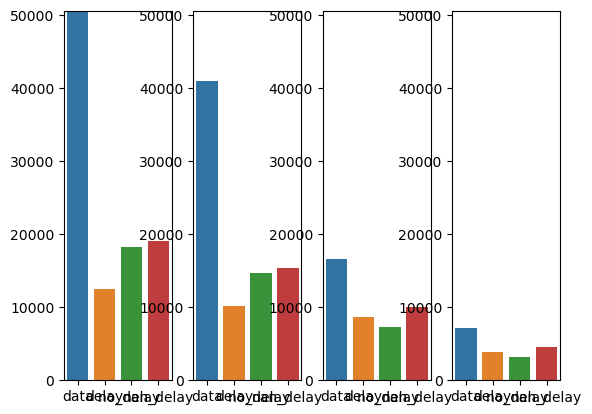

In [36]:
# Mean Tier and Nextbike Trips in Data
f, axes = plt.subplots(1,4)
plt.rcParams["figure.figsize"] = [10.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[3]] , ax=axes[0]) # Data Tier
sns.barplot(data=desc_01.iloc[[5]] , ax=axes[1]) # Data Tier End
sns.barplot(data=desc_01.iloc[[7]] , ax=axes[2]) # Tier
sns.barplot(data=desc_01.iloc[[12]] , ax=axes[3]) # Tier End

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[3, 5, 7, 12]].max()))
axes[1].set_ylim(0, max(desc_01.iloc[[3, 5, 7, 12]].max()))
axes[2].set_ylim(0, max(desc_01.iloc[[3, 5, 7, 12]].max()))
axes[3].set_ylim(0, max(desc_01.iloc[[3, 5, 7, 12]].max()))

plt.show()

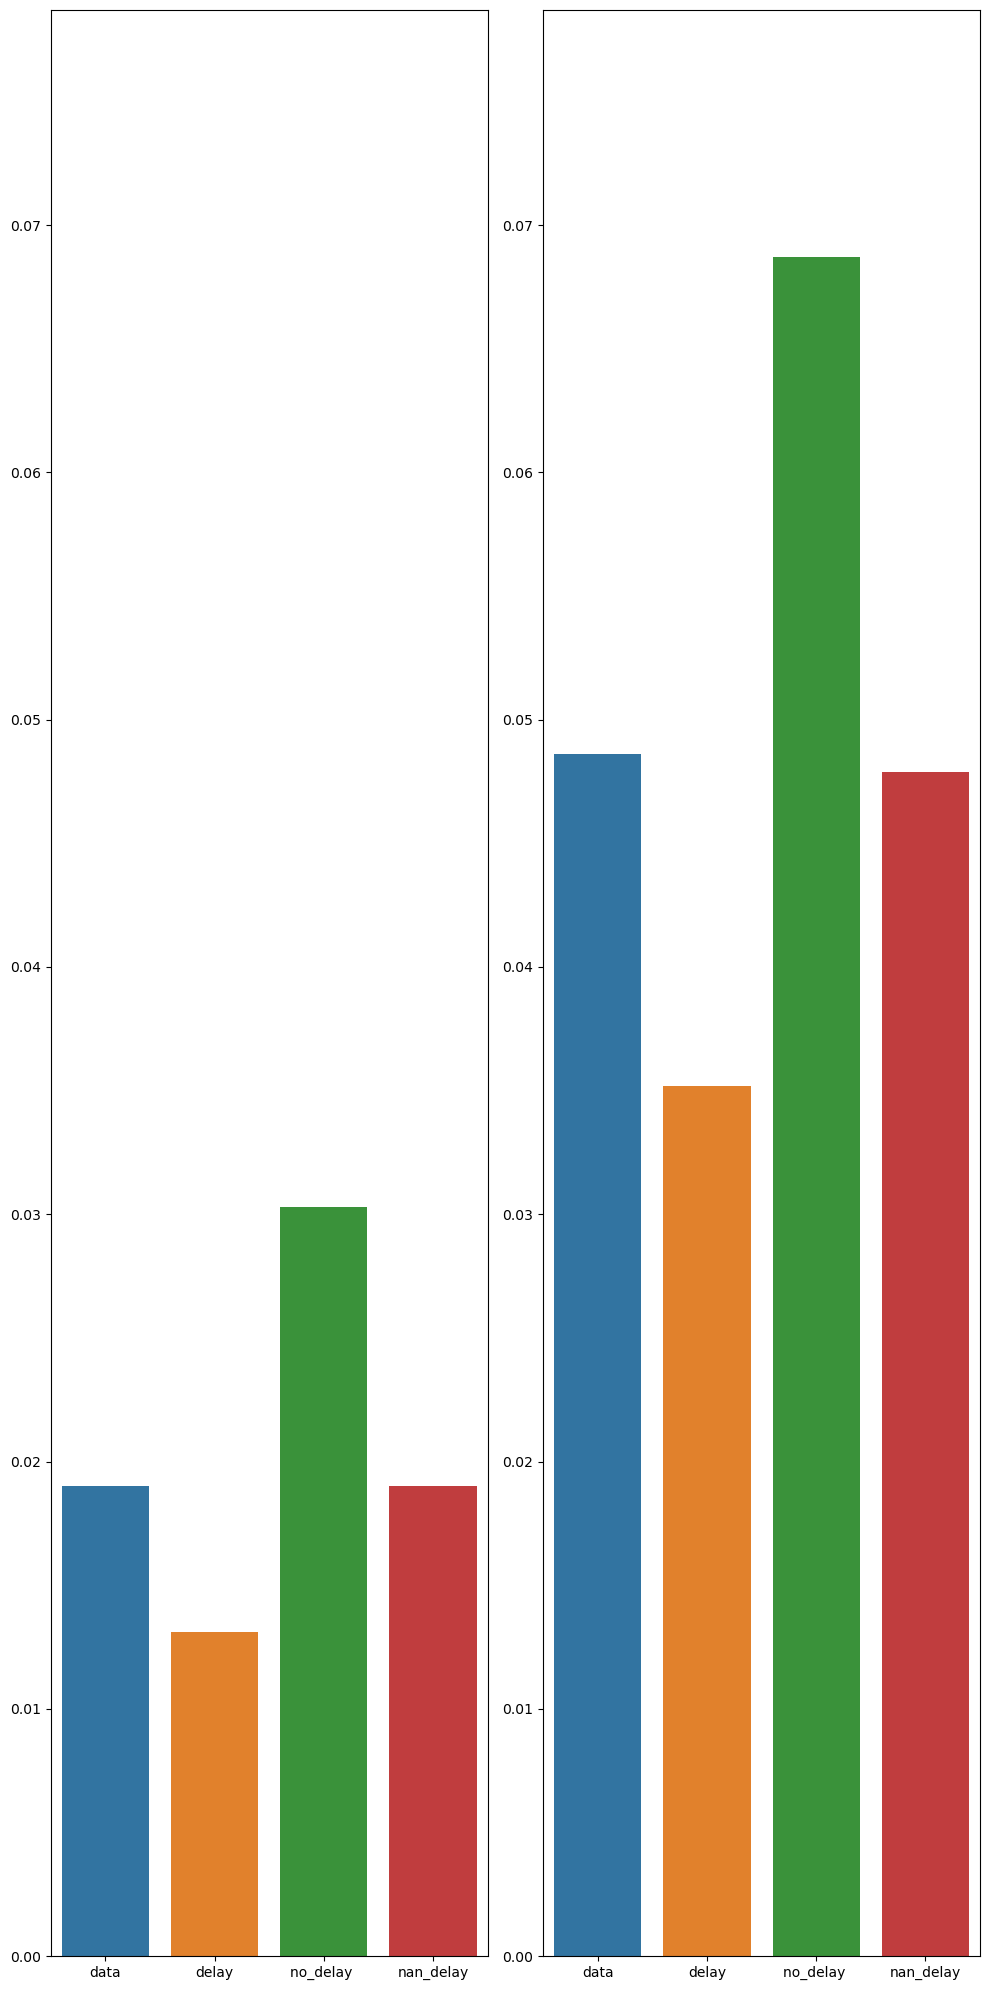

In [37]:
# Mean Tier and Nextbike Trips in Data
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[4]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[18]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[4, 18]].max())+ 0.01)
axes[1].set_ylim(0, max(desc_01.iloc[[4, 18]].max()) + 0.01)
plt.savefig('./Charts/01_Tier_Next_Mean_Trips_Data.png')
plt.show()

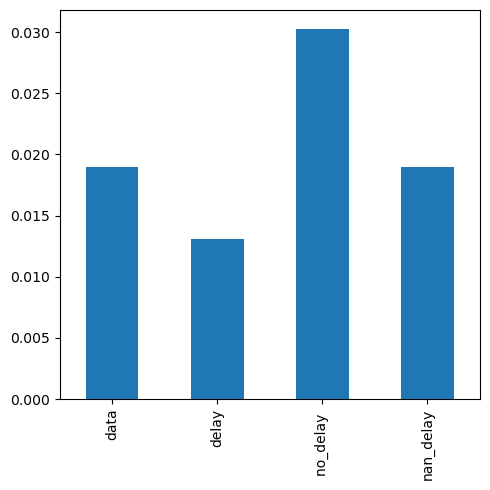

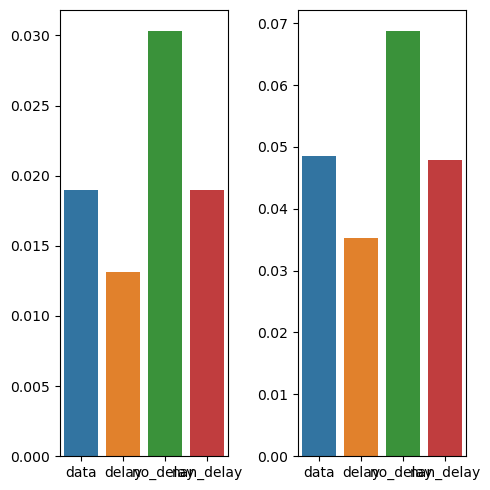

In [38]:
# mean trips tier data
row_index = 4  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

# Mean Tier and Nextbike Trips in Data
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[4]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[18]] , ax=axes[1]) # Next
plt.show()

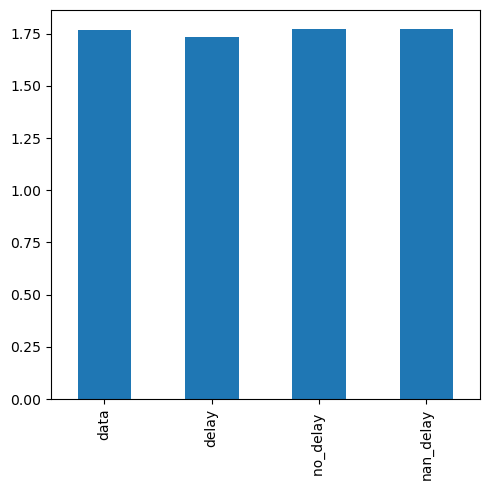

In [39]:
# distance tier
row_index = 8  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

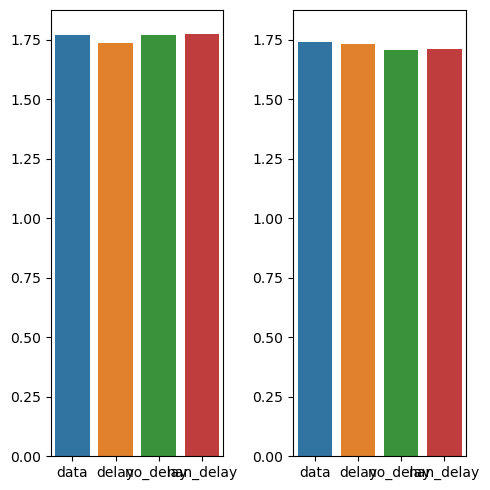

In [40]:
# Mean Tier and Nextbike Lengths
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[8]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[22]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[8, 22]].max())+ 0.1)
axes[1].set_ylim(0, max(desc_01.iloc[[8, 22]].max()) + 0.1)
plt.savefig('./Charts/01_Tier_Next_Length.png')
plt.show()

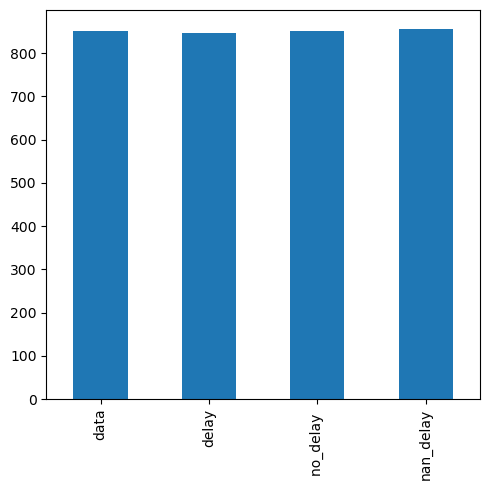

In [41]:
# duration tier
row_index = 10  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

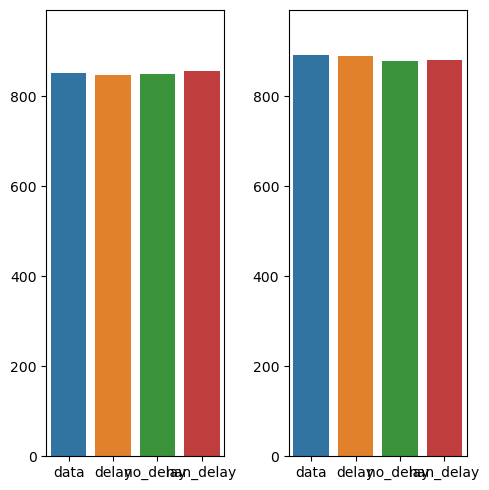

In [42]:
# Mean Tier and Nextbike Duration
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[10]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[24]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[10, 24]].max())+ 100)
axes[1].set_ylim(0, max(desc_01.iloc[[10, 24]].max()) + 100)
plt.savefig('./Charts/01_Tier_Next_Duration.png')
plt.show()

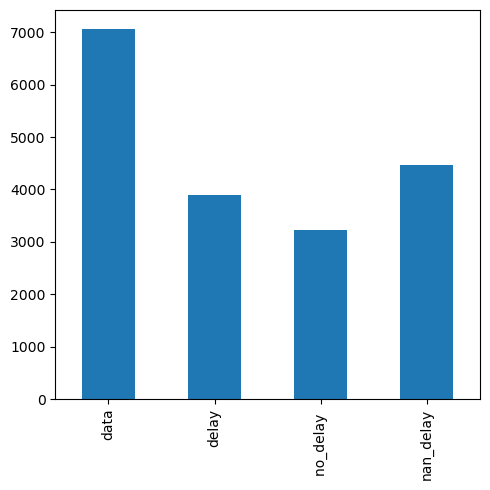

In [43]:
# trips end at station tier
row_index = 12  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

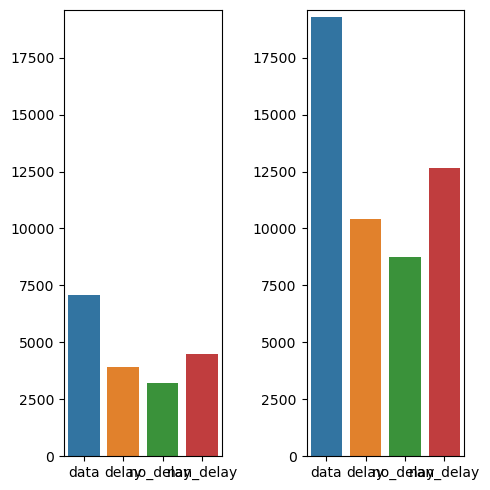

In [44]:
# Trips end at station micro sets
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[12]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[26]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[12, 26]].max())+ 300)
axes[1].set_ylim(0, max(desc_01.iloc[[12, 26]].max()) + 300)
plt.savefig('./Charts/01_Tier_Next_Trips_End_Count.png')
plt.show()

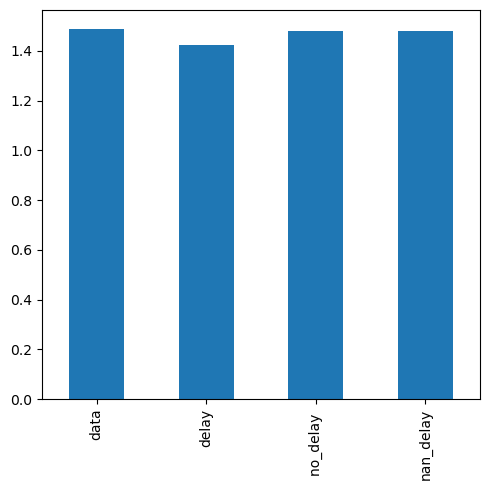

In [45]:
# trips end at station tier length
row_index = 13  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

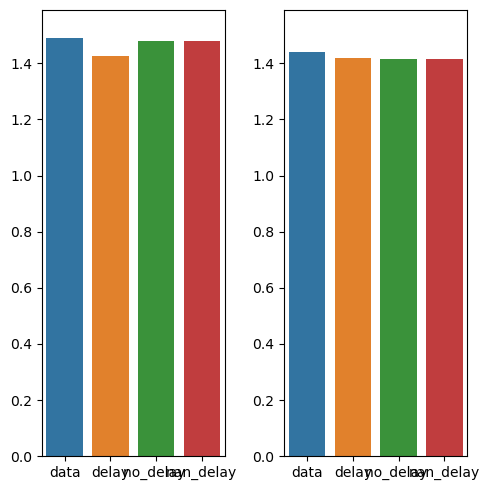

In [46]:
 #Mean Tier and Nextbike Lengths End
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[13]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[27]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[13, 27]].max()) +0.1)
axes[1].set_ylim(0, max(desc_01.iloc[[13, 27]].max()) +0.1)
plt.savefig('./Charts/01_Tier_Next_Length_End.png')
plt.show()

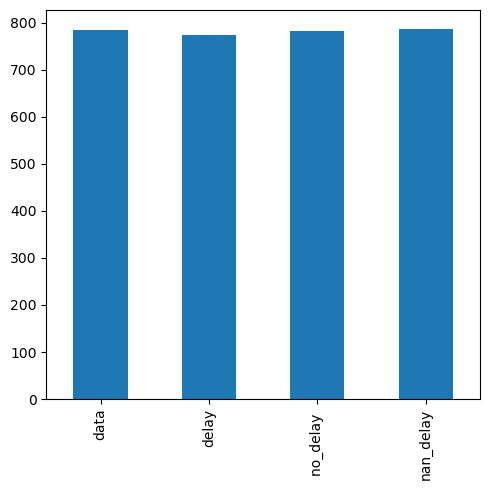

In [47]:
# trips end at station tier duration
row_index = 15  # specify the row index you want to plot
desc_01.iloc[row_index].plot(kind='bar')
plt.show()

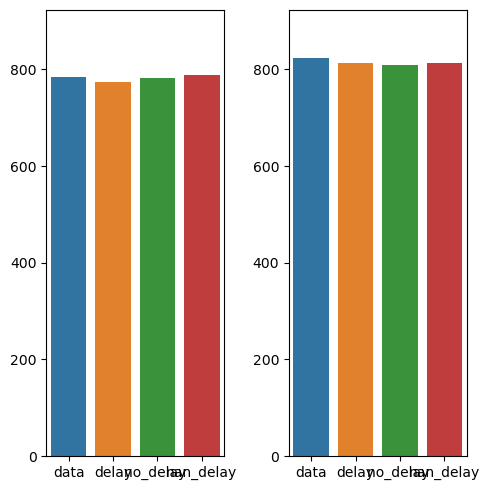

In [48]:
 #Mean Tier and Nextbike Duration End
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_01.iloc[[15]] , ax=axes[0]) # Tier
sns.barplot(data=desc_01.iloc[[29]] , ax=axes[1]) # Next

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(desc_01.iloc[[15, 29]].max() )+ 100)
axes[1].set_ylim(0, max(desc_01.iloc[[15, 29]].max() )+ 100)
plt.savefig('./Charts/01_Tier_Next_Duration_End.png')
plt.show()

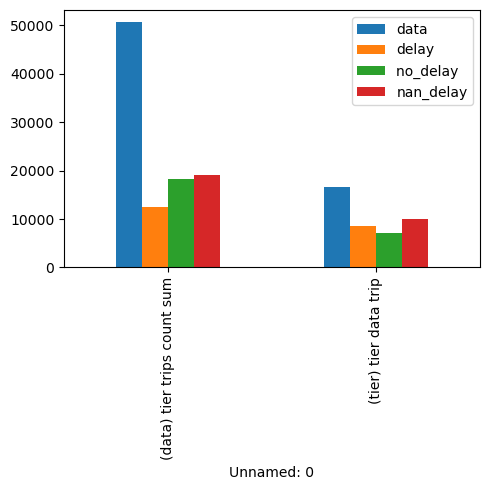

In [49]:
# data vs tier trip count
row_index1 = 3  # specify the first row index you want to plot
row_index2 = 7  # specify the second row index you want to plot

desc_01.iloc[[row_index1, row_index2]].plot(kind='bar')
plt.show()

In [50]:
desc_01_T = desc_01.T


In [51]:
desc_01_New = desc_01_T[['(data) complete trips', '(data) tier trips count sum', '(tier) tier data trip', '(tier) trip start and end at station count', '(data) next trips count sum' ,'(next) nextdata trip', ' (next) trip start and end at station count']]

In [52]:
desc_01_New['possible trips tier'] =  desc_01_New['(data) tier trips count sum'] / desc_01_New['(tier) tier data trip']
desc_01_New['possible trips next'] =  desc_01_New['(data) next trips count sum'] / desc_01_New['(next) nextdata trip']
desc_01_New['tier end amount'] =  desc_01_New['(tier) trip start and end at station count'] / desc_01_New['(tier) tier data trip']
desc_01_New['next end amount'] =  desc_01_New[' (next) trip start and end at station count'] / desc_01_New['(next) nextdata trip']


/tmp/ipykernel_3118112/1554191623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['possible trips tier'] =  desc_01_New['(data) tier trips count sum'] / desc_01_New['(tier) tier data trip']
/tmp/ipykernel_3118112/1554191623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['possible trips next'] =  desc_01_New['(data) next trips count sum'] / desc_01_New['(next) nextdata trip']
/tmp/ipykernel_3118112/1554191623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [53]:
desc_01_New['stops'] = 0
desc_01_New['stops'].iloc[0] = len(data['stop_name'].unique())
desc_01_New['stops'].iloc[1] = len(delay['stop_name'].unique())
desc_01_New['stops'].iloc[2] = len(no_delay['stop_name'].unique())
desc_01_New['stops'].iloc[3] = len(nan_delay['stop_name'].unique())

/tmp/ipykernel_3118112/661683532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['stops'] = 0
/tmp/ipykernel_3118112/661683532.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single 

In [54]:
desc_01_New['tier trip per station '] =  desc_01_New['(tier) tier data trip'] / desc_01_New['stops']
desc_01_New['next trip per station '] =  desc_01_New['(next) nextdata trip'] / desc_01_New['stops']

/tmp/ipykernel_3118112/1899484829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['tier trip per station '] =  desc_01_New['(tier) tier data trip'] / desc_01_New['stops']
/tmp/ipykernel_3118112/1899484829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['next trip per station '] =  desc_01_New['(next) nextdata trip'] / desc_01_New['stops']


In [55]:
desc_01_New['tier per trip '] =  desc_01_New['(tier) tier data trip'] / desc_01_New['(data) complete trips']
desc_01_New['tier end per trip '] =  desc_01_New['(tier) trip start and end at station count'] / desc_01_New['(data) complete trips']
desc_01_New['next per trip '] =  desc_01_New['(next) nextdata trip'] / desc_01_New['(data) complete trips']
desc_01_New['next end per trip '] =  desc_01_New[' (next) trip start and end at station count'] / desc_01_New['(data) complete trips']on

/tmp/ipykernel_3118112/3516966441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['tier per trip '] =  desc_01_New['(tier) tier data trip'] / desc_01_New['(data) complete trips']
/tmp/ipykernel_3118112/3516966441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_01_New['tier end per trip '] =  desc_01_New['(tier) trip start and end at station count'] / desc_01_New['(data) complete trips']
/tmp/ipykernel_3118112/3516966441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [56]:
desc_01_New

Unnamed: 0 (data) complete trips (data) tier trips count sum  \
data                     2564861                       50593   
delay                     950266                       12472   
no_delay                  600178                       18180   
nan_delay                1005613                       19067   

Unnamed: 0 (tier) tier data trip (tier) trip start and end at station count  \
data                       16645                                       7073   
delay                       8611                                       3896   
no_delay                    7212                                       3228   
nan_delay                   9977                                       4472   

Unnamed: 0 (data) next trips count sum (next) nextdata trip  \
data                            124772                41424   
delay                            33484                22212   
no_delay                         41205                17551   
nan_delay                        48198                25521   

Unnamed: 0  (next) trip start and end at station count possible trips tier  \
data                                             19293            3.039531   
delay                                            10414             1.44838   
no_delay                                          8764            2.520799   
nan_delay                                        12633            1.911096   

Unnamed: 0 possible trips next tier end amount next end amount  stops  \
data                   3.01207        0.424932        0.465744    513   
delay                 1.507473        0.452445        0.468846    479   
no_delay              2.347729        0.447587        0.499345    508   
nan_delay             1.888562        0.448231        0.495004    513   

Unnamed: 0 tier trip per station  next trip per station  tier per trip   \
data                    32.446394              80.748538        0.00649   
delay                   17.977035              46.371608       0.009062   
no_delay                 14.19685              34.549213       0.012016   
nan_delay               19.448343              49.748538       0.009921   

Unnamed: 0 tier end per trip  next per trip  next end per trip   
data                 0.002758       0.016151           0.007522  
delay                  0.0041       0.023375           0.010959  
no_delay             0.005378       0.029243           0.014602  
nan_delay            0.004447       0.025379           0.012562

In [57]:
T_01 = desc_01_New.T
T_01

data      delay  no_delay   \
Unnamed: 0                                                                     
(data) complete trips                          2564861     950266     600178   
(data) tier trips count sum                      50593      12472      18180   
(tier) tier data trip                            16645       8611       7212   
(tier) trip start and end at station count        7073       3896       3228   
(data) next trips count sum                     124772      33484      41205   
(next) nextdata trip                             41424      22212      17551   
 (next) trip start and end at station count      19293      10414       8764   
possible trips tier                           3.039531    1.44838   2.520799   
possible trips next                            3.01207   1.507473   2.347729   
tier end amount                               0.424932   0.452445   0.447587   
next end amount                               0.465744   0.468846   0.499345   
stops                                              513        479        508   
tier trip per station                        32.446394  17.977035   14.19685   
next trip per station                        80.748538  46.371608  34.549213   
tier per trip                                  0.00649   0.009062   0.012016   
tier end per trip                             0.002758     0.0041   0.005378   
next per trip                                 0.016151   0.023375   0.029243   
next end per trip                             0.007522   0.010959   0.014602   

                                             nan_delay  
Unnamed: 0                                              
(data) complete trips                          1005613  
(data) tier trips count sum                      19067  
(tier) tier data trip                             9977  
(tier) trip start and end at station count        4472  
(data) next trips count sum                      48198  
(next) nextdata trip                             25521  
 (next) trip start and end at station count      12633  
possible trips tier                           1.911096  
possible trips next                           1.888562  
tier end amount                               0.448231  
next end amount                               0.495004  
stops                                              513  
tier trip per station                        19.448343  
next trip per station                        49.748538  
tier per trip                                 0.009921  
tier end per trip                             0.004447  
next per trip                                 0.025379  
next end per trip                             0.012562

In [58]:
T_01.to_csv("Tables/T_01.csv")

In [59]:
#ax = sns.barplot(flights, x="year", y="passengers", estimator="sum", errorbar=None)
#ax.bar_label(ax.containers[0], fontsize=10);

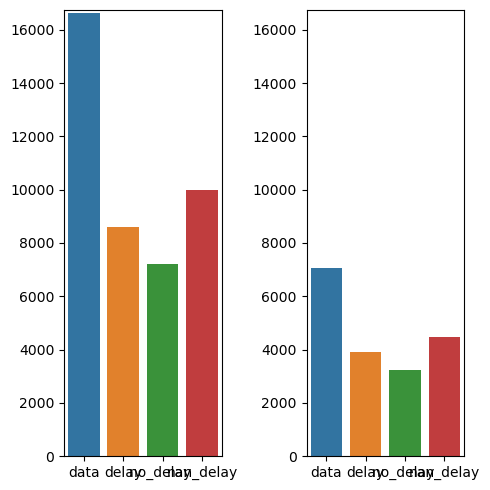

In [60]:
# Tier Trips
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_01.iloc[[2]] , ax=axes[0]) 
sns.barplot(data=T_01.iloc[[3]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(T_01.iloc[[2, 3]].max()) +100)
axes[1].set_ylim(0, max(T_01.iloc[[2, 3]].max()) +100)
plt.savefig('./Charts/01_Tier_Trips_Amount_All_End.png')
plt.show()

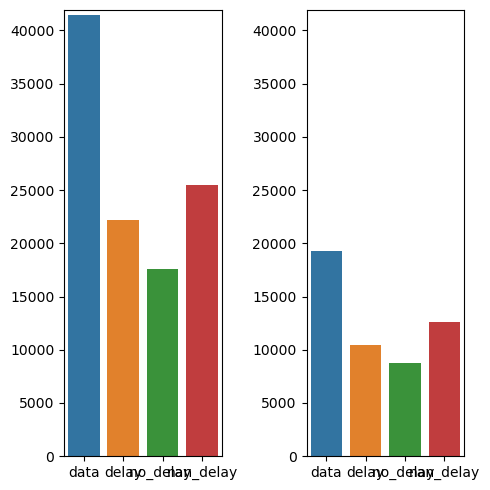

In [61]:
# Next Trips
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_01.iloc[[5]] , ax=axes[0]) 
sns.barplot(data=T_01.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.savefig('./Charts/01_Next_Trips_Amount_All_End.png')
plt.show()

### Desc 02

In [62]:
desc_02

Unnamed: 0 morning_rush_delay  \
0                               (data) complete trips             188472   
1                         (data) tier trips count sum               1841   
2                              (data) tier trips mean             0.0098   
3          (data) tier trips end at station count sum               1497   
4         (data) tier trips end at station count mean              0.008   
5                               (tier) tier data trip               1180   
6                               (tier) trip avg lengt               1.65   
7                            (tier) trip length range      0,1 - 8,14 km   
8                            (tier) trip duration avg           782.5424   
9                          (tier) trip duration range         300 - 6000   
10         (tier) trip start and end at station count                537   
11   (tier) trip start and end at station mean length             1.2974   
12  (tier) trip start and end at station range length      0,01 - 6,2093   
13  (tier) trip start and end at station mean dura...           729.0503   
14  (tier) trip start and end at station range dur...        300 - 6000    
15                        (data) next trips count sum               5117   
16                            (data) next trips mean              0.0271   
17               (data) next end at station count sum               4439   
18              (data) next end at station count mean             0.0235   
19                               (next) nextdata trip               3578   
20                              (next) trip avg lengt                1.7   
21                           (next) trip length range     0,01 - 12,4376   
22                      (next) trip duration average    827,289  seconds   
23                         (next) trip duration range         300 - 5700   
24         (next) trip start and end at station count               1788   
25   (next) trip start and end at station mean length             1.4686   
26  (next) trip start and end at station range length          0,1 - 7,3   
27  (next) trip start and end at station mean dura...           769.9329   
28  (next) trip start and end at station range dur...         300 - 5100   

   morning_rush_no_delay morning_rush_nan_delay    midday_delay  \
0                 122186                  222593         101954   
1                   2188                    2621           1261   
2                 0.0146                  0.0118         0.0123   
3                   1784                    2149           1034   
4                 0.0146                  0.0097         0.0101   
5                    896                    1299            903   
6                 1.6287                  1.6451         1.6273   
7           0,1 - 8,7256           0,1 - 10,2809  0,1 - 13,9087   
8               790.1786                 778.291            799   
9            300 - 60000              300 - 6000     300 - 5700   
10                   409                     596            449   
11                1.3278                  1.3441         1.3533   
12          0,1 - 6,2093            0,1 - 7,4934    0,1 - 5,864   
13              724.6943                720.8054       720.9354   
14            300 - 6000              300 - 6000     300 - 3300   
15                  7176                    8759           3990   
16                0.0587                  0.0394          0.038   
17                  6162                    7474           3417   
18                0.0504                  0.0336         0.0335   
19                  3189                    4678           2568   
20                1.6499                  1.6668         1.5873   
21         0,1 - 10,2282           0,1 - 13,5517  0,1 - 12,5652   
22              835.7291                833.4331       851.8692   
23            300 - 7200              300 - 7200     300 - 7200   
24                  1644                    2382           1294   
25                1.

In [63]:
desc_02.columns

Index(['Unnamed: 0', 'morning_rush_delay', 'morning_rush_no_delay',
       'morning_rush_nan_delay ', 'midday_delay', 'midday_no_delay',
       'midday_nan_delay', 'lunchtime_delay', 'lunchtime_no_delay',
       'lunchtime_nan_delay', 'afternoon_delay', 'afternoon_no_delay',
       'afternoon_nan_delay', 'evening_rush_delay', 'evening_rush_no_delay',
       'evening_rush_nan_delay', 'evening_delay', 'evening_no_delay',
       'evening_nan_delay', 'night_delay', 'night_no_delay', 'night_nan_delay',
       'eraly_morning_delay', 'early_morning_no_delay',
       'early_morning_nan_delay', 'during_week_delay', 'during_week_no_delay',
       'during_week_nan_delay', 'Friday_delay', 'Friday_no_delay',
       'Friday_nan_delay', 'Saturday_delay', 'Saturday_no_delkay',
       'Saturday_mam_delay', 'Sunday_delay', 'Sunday_no_delay',
       'Sunday_nan_delay'],
      dtype='object')

In [64]:
desc_02 = desc_02.set_index(desc_02.columns[0])

In [65]:
desc_02_T = desc_02.T

In [66]:
desc_02_T

Unnamed: 0              (data) complete trips (data) tier trips count sum  \
morning_rush_delay                     188472                        1841   
morning_rush_no_delay                  122186                        2188   
morning_rush_nan_delay                 222593                        2621   
midday_delay                           101954                        1261   
midday_no_delay                         64182                        1792   
midday_nan_delay                       127015                        2270   
lunchtime_delay                        167732                        2573   
lunchtime_no_delay                     105922                        3718   
lunchtime_nan_delay                    186150                        3940   
afternoon_delay                        110777                        2158   
afternoon_no_delay                      67154                        3005   
afternoon_nan_delay                    127187                        3340   
evening_rush_delay                     173541                        2557   
evening_rush_no_delay                  105539                        3952   
evening_rush_nan_delay                 171041                        3917   
evening_delay                           82723                        1039   
evening_no_delay                        54395                        1668   
evening_nan_delay                       76438                        1510   
night_delay                             95607                         815   
night_no_delay                          60743                        1534   
night_nan_delay                         63884                        1012   
eraly_morning_delay                     29190                         228   
early_morning_no_delay                 200057                         323   
early_morning_nan_delay                 31305                         357   
during_week_delay                      585948                        7534   
during_week_no_delay                   366722                       10442   
during_week_nan_delay                  623176                       11094   
Friday_delay                           132495                        2024   
Friday_no_delay                         83192                        2958   
Friday_nan_delay                       154162                        3298   
Saturday_delay                         146072                        2143   
Saturday_no_delkay                      97389                        3505   
Saturday_mam_delay                     167276                        2738   
Sunday_delay                            85751                         771   
Sunday_no_delay                         52875                        1275   
Sunday_nan_delay                        60999                         937   

Unnamed: 0              (data) tier trips mean  \
morning_rush_delay                      0.0098   
morning_rush_no_delay                   0.0146   
morning_rush_nan_delay                  0.0118   
midday_delay                            0.0123   
midday_no_delay                         0.0279   
midday_nan_delay                        0.0179   
lunchtime_delay                         0.0153   
lunchtime_no_delay                      0.0351   
lunchtime_nan_delay                     0.0212   
afternoon_delay                         0.0195   
afternoon_no_delay                      0.0447   
afternoon_nan_delay                      0.027   
evening_rush_delay                      0.0147   
evening_rush_no_delay                   0.0374   
evening_rush_nan_delay                  0.0229   
evening_delay                           0.0126   
evening_no_delay                        0.0307   
evening_nan_delay                       0.0198   
night_delay                             0.0085   
night_no_delay                          0.0252   
night_nan_delay                         0.0158   
eraly_morning_delay                     0.0078   


In [67]:
desc_02

morning_rush_delay  \
Unnamed: 0                                                              
(data) complete trips                                          188472   
(data) tier trips count sum                                      1841   
(data) tier trips mean                                         0.0098   
(data) tier trips end at station count sum                       1497   
(data) tier trips end at station count mean                     0.008   
(tier) tier data trip                                            1180   
(tier) trip avg lengt                                            1.65   
(tier) trip length range                                0,1 - 8,14 km   
(tier) trip duration avg                                     782.5424   
(tier) trip duration range                                 300 - 6000   
(tier) trip start and end at station count                        537   
(tier) trip start and end at station mean length               1.2974   
(tier) trip start and end at station range length       0,01 - 6,2093   
(tier) trip start and end at station mean duration           729.0503   
(tier) trip start and end at station range dura...        300 - 6000    
(data) next trips count sum                                      5117   
(data) next trips mean                                         0.0271   
(data) next end at station count sum                             4439   
(data) next end at station count mean                          0.0235   
(next) nextdata trip                                             3578   
(next) trip avg lengt                                             1.7   
(next) trip length range                               0,01 - 12,4376   
(next) trip duration average                         827,289  seconds   
(next) trip duration range                                 300 - 5700   
 (next) trip start and end at station count                      1788   
(next) trip start and end at station mean length               1.4686   
(next) trip start and end at station range length           0,1 - 7,3   
(next) trip start and end at station mean duration           769.9329   
(next) trip start and end at station range dura...         300 - 5100   

                                                   morning_rush_no_delay  \
Unnamed: 0                                                                 
(data) complete trips                                             122186   
(data) tier trips count sum                                         2188   
(data) tier trips mean                                            0.0146   
(data) tier trips end at station count sum                          1784   
(data) tier trips end at station count mean                       0.0146   
(tier) tier data trip                                                896   
(tier) trip avg lengt                                             1.6287   
(tier) trip length range                                    0,1 - 8,7256   
(tier) trip duration avg                                        790.1786   
(tier) trip duration range                                   300 - 60000   
(tier) trip start and end at station count                           409   
(tier) trip start and end at station mean length                  1.3278   
(tier) trip start and end at station range length           0,1 - 6,2093   
(tier) trip start and end at station mean duration              724.6943   
(tier) trip start and end at station range dura...            300 - 6000   
(data) next trips count sum                                         7176   
(data) next trips mean                                            0.0587   
(data) next end at station count sum                                6162   
(data) next end at station count mean                             0.0504   
(next) nextdata trip                                                3189   
(next) trip avg lengt                                             1.6499   
(next) trip length range               

In [68]:
desc_02.to_csv("Tables/Desc_02.csv")

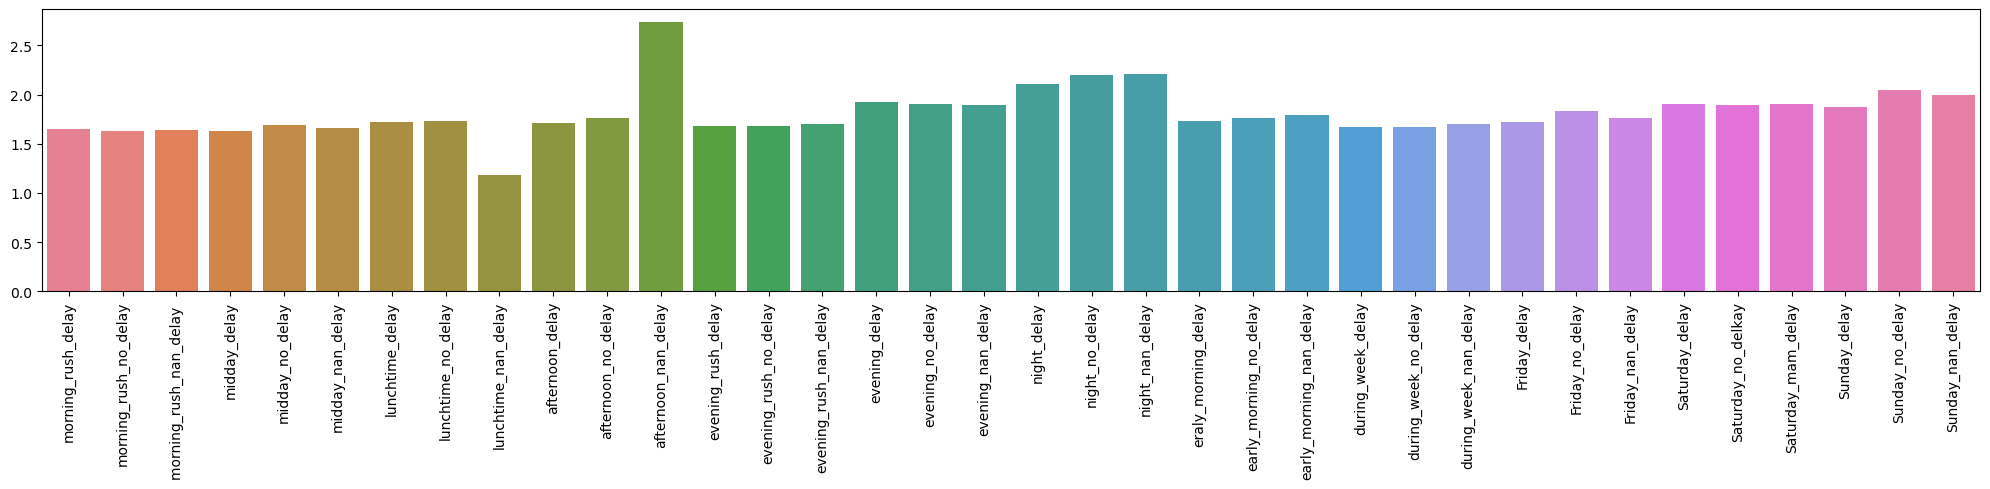

In [69]:
# Tier Trips Length
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[6]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_Length.png')
plt.show()

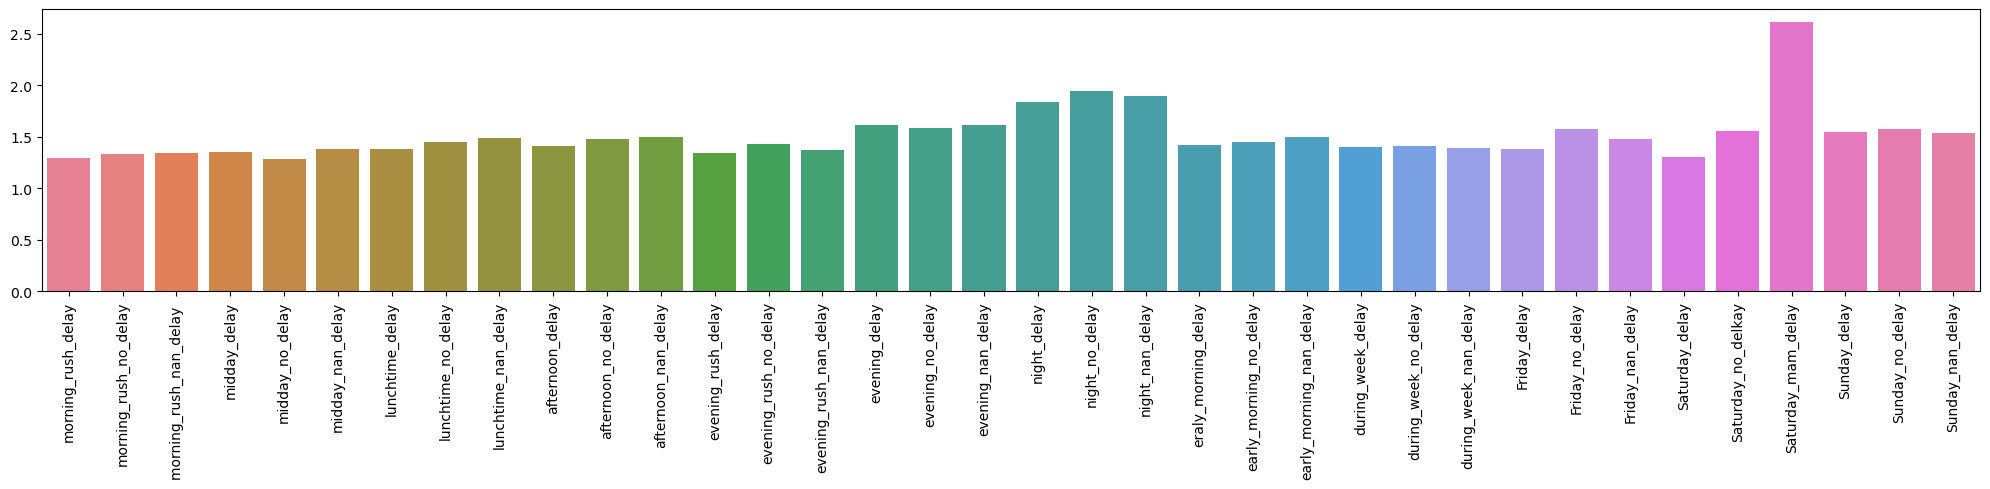

In [70]:
# Tier Trips End Length
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[11]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_End_Length.png')
plt.show()

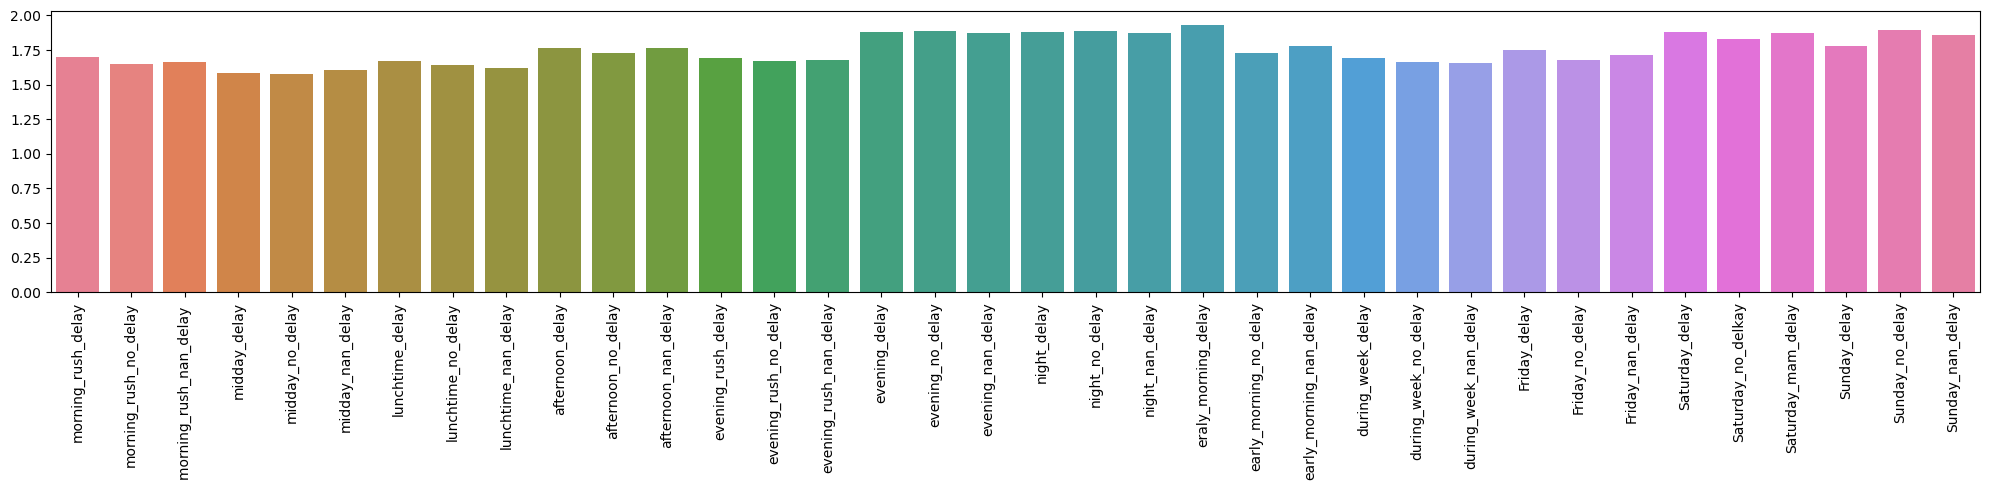

In [71]:
# Next Trips Length
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[20]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_Length.png')
plt.show()

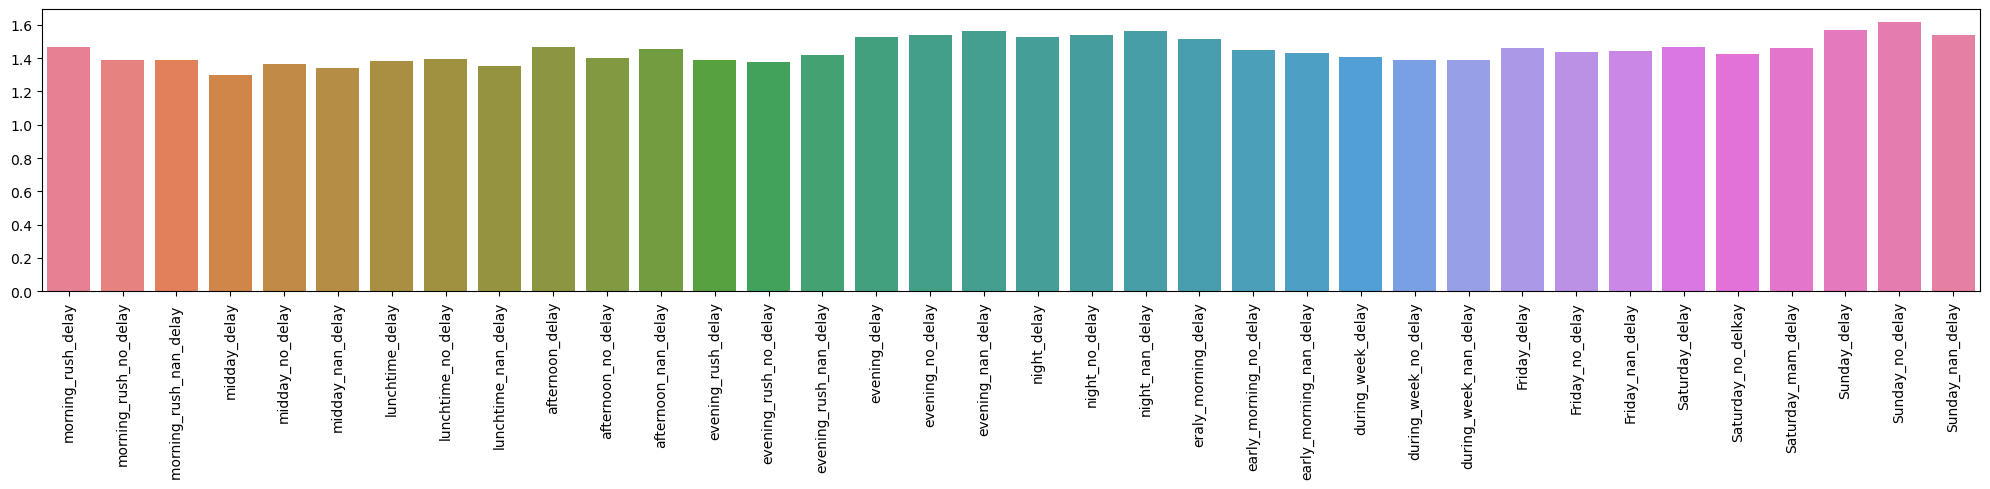

In [72]:
# Tier Trips End Length
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[25]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_End_Length.png')
plt.show()

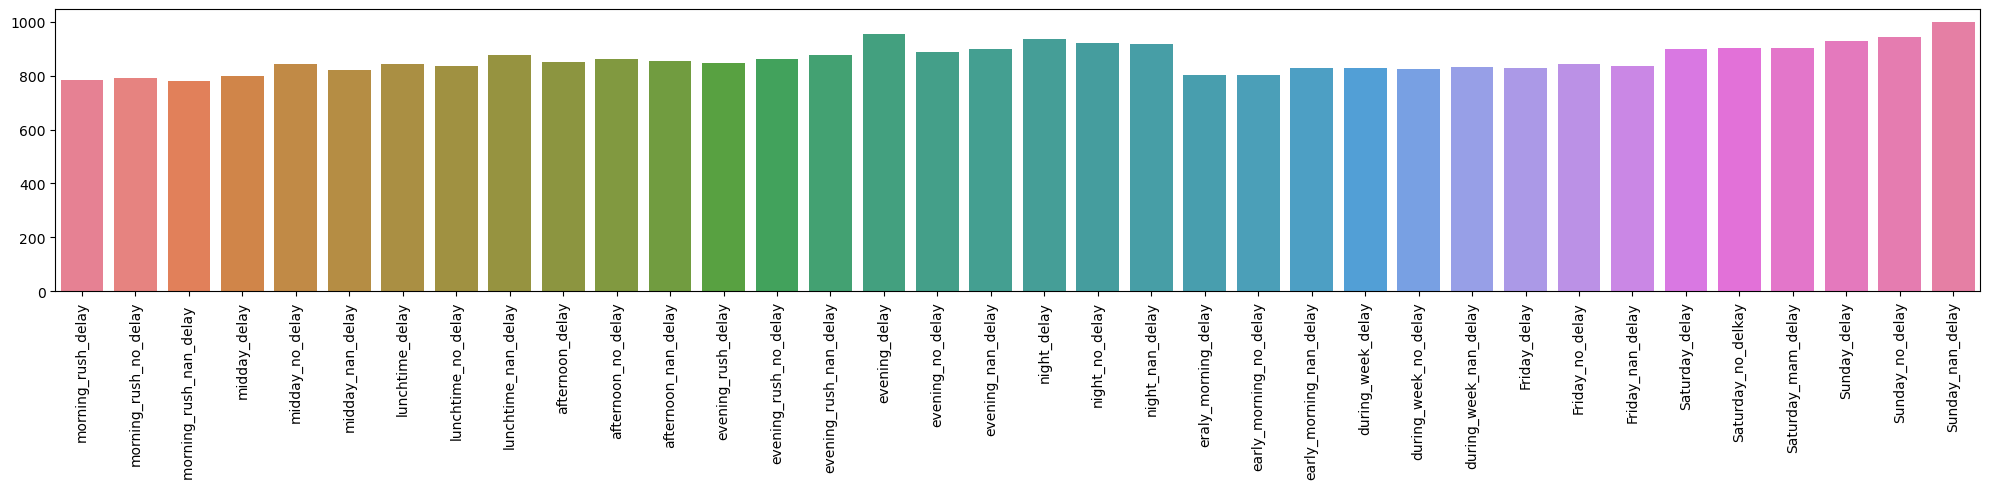

In [73]:
# Tier Trips Duration
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[8]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_Durations.png')
plt.show()

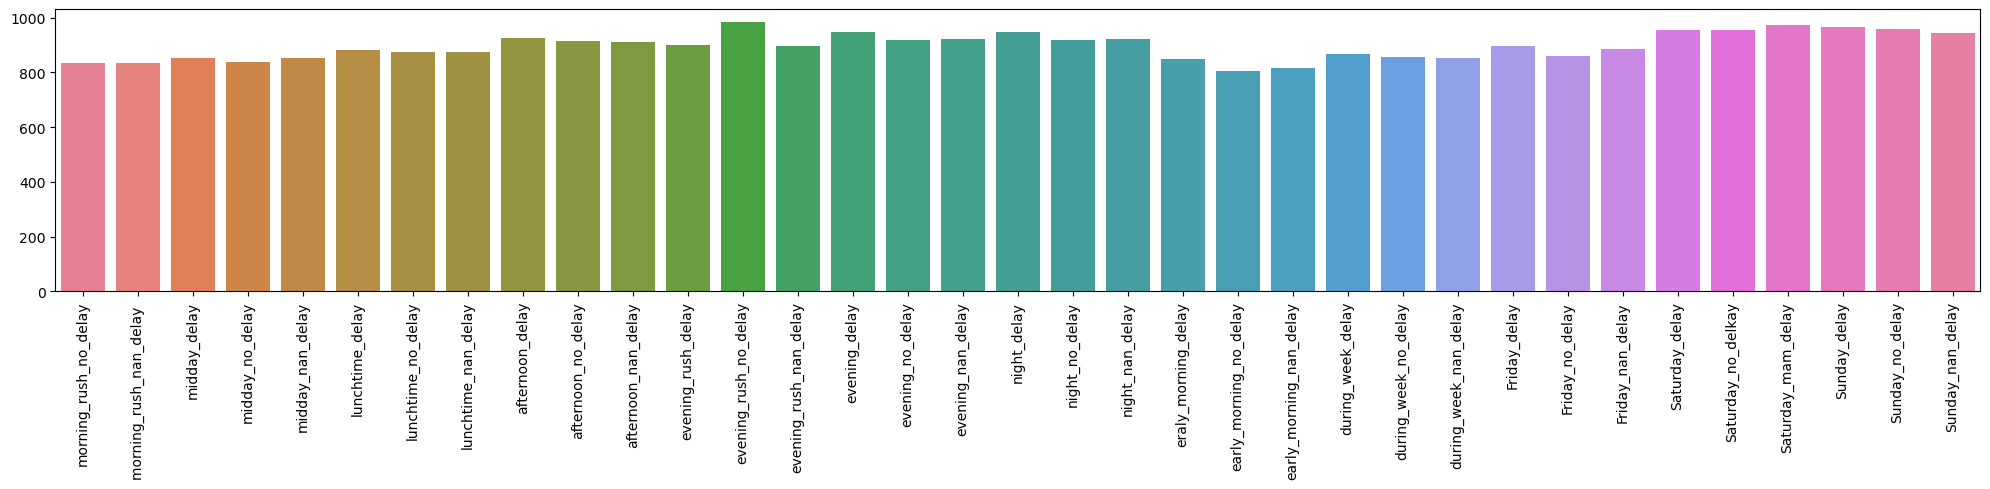

In [74]:
# Next Trips Duration
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[22]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_Duration.png')
plt.show()

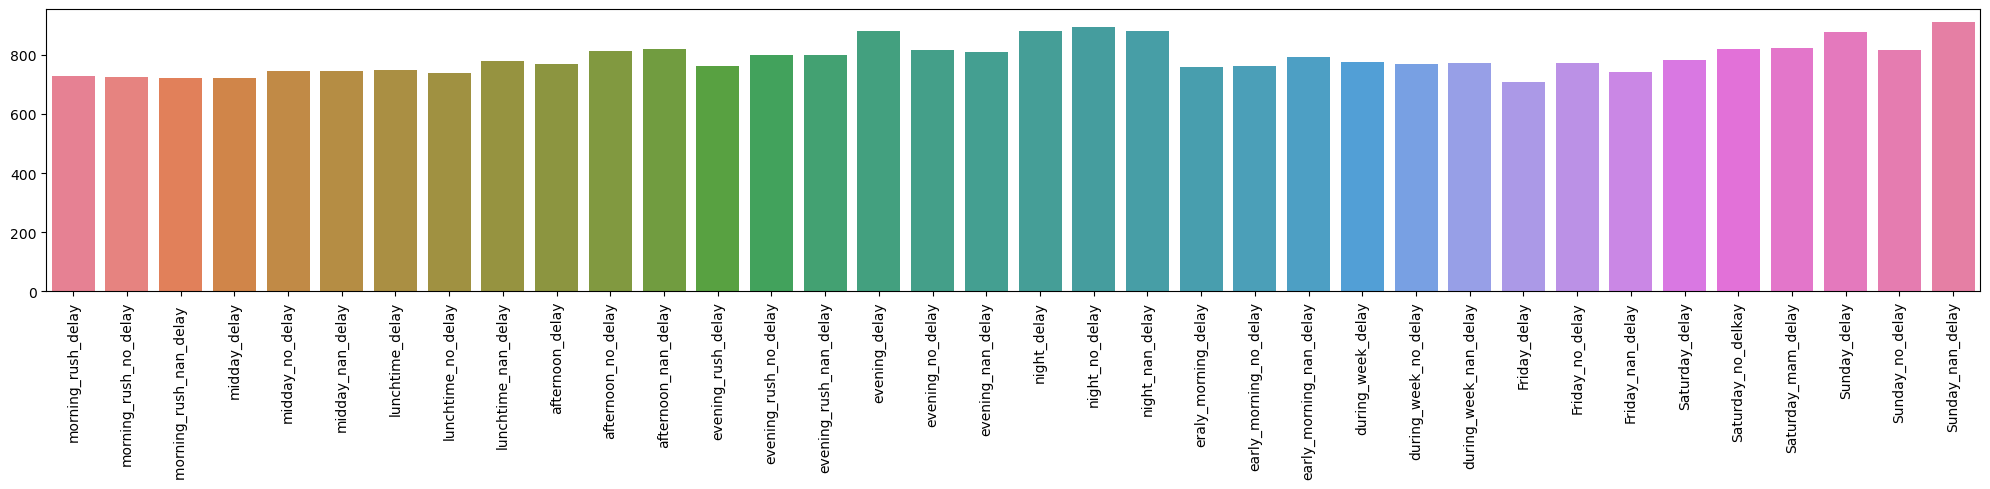

In [75]:
# Tier Trips End Duration
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[13]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_End_Duration.png')
plt.show()

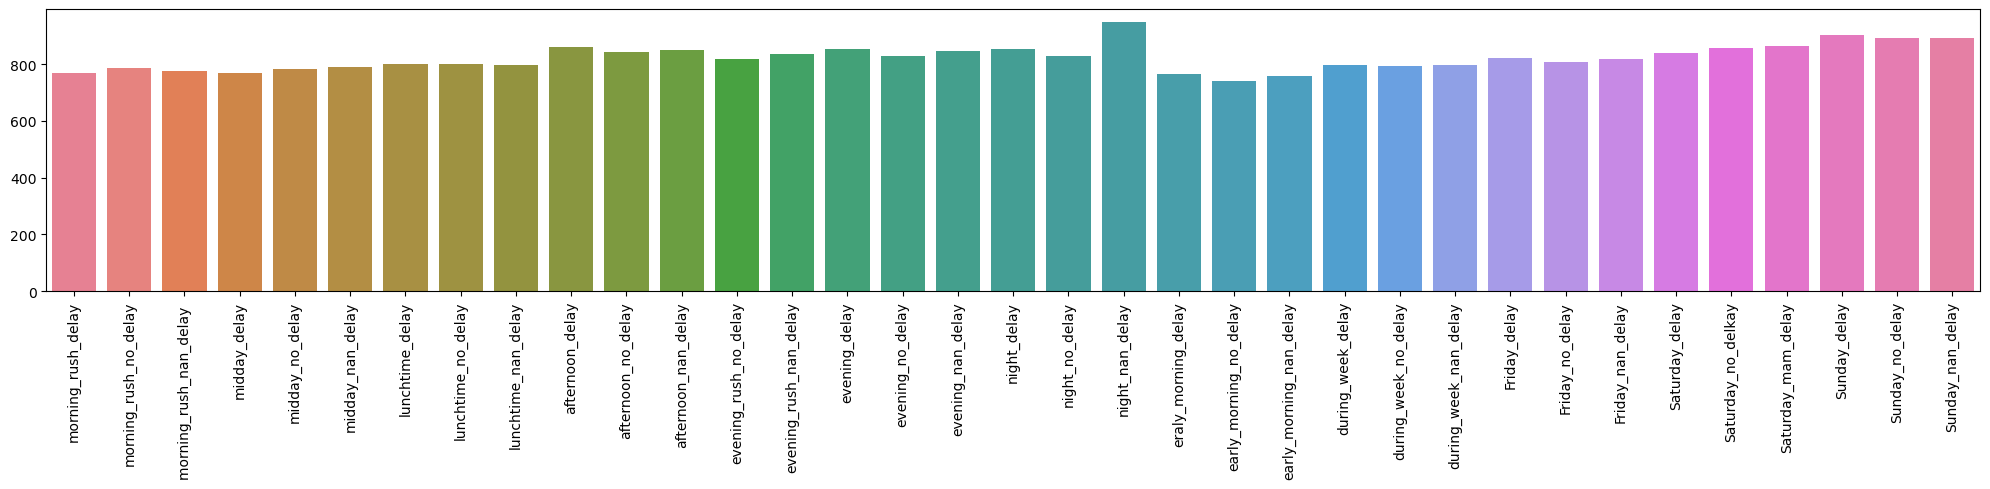

In [76]:
# Next Trips End duration
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_02.iloc[[27]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_End_Duration.png')
plt.show()

In [77]:
desc_02_New = desc_02_T[['(data) complete trips', '(data) tier trips count sum', '(tier) tier data trip', '(tier) trip start and end at station count', '(data) next trips count sum' ,'(next) nextdata trip', ' (next) trip start and end at station count']]

In [78]:
desc_02_New

Unnamed: 0              (data) complete trips (data) tier trips count sum  \
morning_rush_delay                     188472                        1841   
morning_rush_no_delay                  122186                        2188   
morning_rush_nan_delay                 222593                        2621   
midday_delay                           101954                        1261   
midday_no_delay                         64182                        1792   
midday_nan_delay                       127015                        2270   
lunchtime_delay                        167732                        2573   
lunchtime_no_delay                     105922                        3718   
lunchtime_nan_delay                    186150                        3940   
afternoon_delay                        110777                        2158   
afternoon_no_delay                      67154                        3005   
afternoon_nan_delay                    127187                        3340   
evening_rush_delay                     173541                        2557   
evening_rush_no_delay                  105539                        3952   
evening_rush_nan_delay                 171041                        3917   
evening_delay                           82723                        1039   
evening_no_delay                        54395                        1668   
evening_nan_delay                       76438                        1510   
night_delay                             95607                         815   
night_no_delay                          60743                        1534   
night_nan_delay                         63884                        1012   
eraly_morning_delay                     29190                         228   
early_morning_no_delay                 200057                         323   
early_morning_nan_delay                 31305                         357   
during_week_delay                      585948                        7534   
during_week_no_delay                   366722                       10442   
during_week_nan_delay                  623176                       11094   
Friday_delay                           132495                        2024   
Friday_no_delay                         83192                        2958   
Friday_nan_delay                       154162                        3298   
Saturday_delay                         146072                        2143   
Saturday_no_delkay                      97389                        3505   
Saturday_mam_delay                     167276                        2738   
Sunday_delay                            85751                         771   
Sunday_no_delay                         52875                        1275   
Sunday_nan_delay                        60999                         937   

Unnamed: 0              (tier) tier data trip  \
morning_rush_delay                       1180   
morning_rush_no_delay                     896   
morning_rush_nan_delay                   1299   
midday_delay                              903   
midday_no_delay                           732   
midday_nan_delay                         1125   
lunchtime_delay                          1781   
lunchtime_no_delay                       1472   
lunchtime_nan_delay                      2085   
afternoon_delay                          1485   
afternoon_no_delay                       1175   
afternoon_nan_delay                      1735   
evening_rush_delay                       1777   
evening_rush_no_delay                    1465   
evening_rush_nan_delay                   2035   
evening_delay                             763   
evening_no_delay                          672   
evening_nan_delay                         862   
night_delay                               583   
night_no_delay                            663   
night_nan_delay                           660   
eraly_morning_delay                       175   
early_morning_no_delay 

In [79]:
desc_02_New['possible trips tier'] =  desc_02_New['(data) tier trips count sum'] / desc_02_New['(tier) tier data trip']
desc_02_New['possible trips next'] =  desc_02_New['(data) next trips count sum'] / desc_02_New['(next) nextdata trip']
desc_02_New['tier end amount'] =  desc_02_New['(tier) trip start and end at station count'] / desc_02_New['(tier) tier data trip']
desc_02_New['next end amount'] =  desc_02_New[' (next) trip start and end at station count'] / desc_02_New['(next) nextdata trip']

desc_02_New['tier per trip '] =  desc_02_New['(tier) tier data trip'] / desc_02_New['(data) complete trips']
desc_02_New['tier end per trip '] =  desc_02_New['(tier) trip start and end at station count'] / desc_02_New['(data) complete trips']
desc_02_New['next per trip '] =  desc_02_New['(next) nextdata trip'] / desc_02_New['(data) complete trips']
desc_02_New['next end per trip '] =  desc_02_New[' (next) trip start and end at station count'] / desc_02_New['(data) complete trips']

/tmp/ipykernel_3118112/546908222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_02_New['possible trips tier'] =  desc_02_New['(data) tier trips count sum'] / desc_02_New['(tier) tier data trip']
/tmp/ipykernel_3118112/546908222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_02_New['possible trips next'] =  desc_02_New['(data) next trips count sum'] / desc_02_New['(next) nextdata trip']
/tmp/ipykernel_3118112/546908222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [80]:
len(desc_02_New)

36

In [81]:
inde = 0
desc_02_New['stops'] = 0

for i in range(0, int((len(desc_02_New)/4))):
    desc_02_New['stops'].iloc[inde] = len(data['stop_name'].unique())
    desc_02_New['stops'].iloc[inde+1] = len(delay['stop_name'].unique())
    desc_02_New['stops'].iloc[inde+2] = len(no_delay['stop_name'].unique())
    desc_02_New['stops'].iloc[inde+3] = len(nan_delay['stop_name'].unique())
    
    inde = inde + 4

/tmp/ipykernel_3118112/3452055204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_02_New['stops'] = 0
/tmp/ipykernel_3118112/3452055204.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a singl

In [82]:
desc_02_New['tier trip per station '] =  desc_02_New['(tier) tier data trip'] / desc_02_New['stops']
desc_02_New['next trip per station '] =  desc_02_New['(next) nextdata trip'] / desc_02_New['stops']

/tmp/ipykernel_3118112/4107134115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_02_New['tier trip per station '] =  desc_02_New['(tier) tier data trip'] / desc_02_New['stops']
/tmp/ipykernel_3118112/4107134115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_02_New['next trip per station '] =  desc_02_New['(next) nextdata trip'] / desc_02_New['stops']


In [83]:
desc_02_New

Unnamed: 0              (data) complete trips (data) tier trips count sum  \
morning_rush_delay                     188472                        1841   
morning_rush_no_delay                  122186                        2188   
morning_rush_nan_delay                 222593                        2621   
midday_delay                           101954                        1261   
midday_no_delay                         64182                        1792   
midday_nan_delay                       127015                        2270   
lunchtime_delay                        167732                        2573   
lunchtime_no_delay                     105922                        3718   
lunchtime_nan_delay                    186150                        3940   
afternoon_delay                        110777                        2158   
afternoon_no_delay                      67154                        3005   
afternoon_nan_delay                    127187                        3340   
evening_rush_delay                     173541                        2557   
evening_rush_no_delay                  105539                        3952   
evening_rush_nan_delay                 171041                        3917   
evening_delay                           82723                        1039   
evening_no_delay                        54395                        1668   
evening_nan_delay                       76438                        1510   
night_delay                             95607                         815   
night_no_delay                          60743                        1534   
night_nan_delay                         63884                        1012   
eraly_morning_delay                     29190                         228   
early_morning_no_delay                 200057                         323   
early_morning_nan_delay                 31305                         357   
during_week_delay                      585948                        7534   
during_week_no_delay                   366722                       10442   
during_week_nan_delay                  623176                       11094   
Friday_delay                           132495                        2024   
Friday_no_delay                         83192                        2958   
Friday_nan_delay                       154162                        3298   
Saturday_delay                         146072                        2143   
Saturday_no_delkay                      97389                        3505   
Saturday_mam_delay                     167276                        2738   
Sunday_delay                            85751                         771   
Sunday_no_delay                         52875                        1275   
Sunday_nan_delay                        60999                         937   

Unnamed: 0              (tier) tier data trip  \
morning_rush_delay                       1180   
morning_rush_no_delay                     896   
morning_rush_nan_delay                   1299   
midday_delay                              903   
midday_no_delay                           732   
midday_nan_delay                         1125   
lunchtime_delay                          1781   
lunchtime_no_delay                       1472   
lunchtime_nan_delay                      2085   
afternoon_delay                          1485   
afternoon_no_delay                       1175   
afternoon_nan_delay                      1735   
evening_rush_delay                       1777   
evening_rush_no_delay                    1465   
evening_rush_nan_delay                   2035   
evening_delay                             763   
evening_no_delay                          672   
evening_nan_delay                         862   
night_delay                               583   
night_no_delay                            663   
night_nan_delay                           660   
eraly_morning_delay                       175   
early_morning_no_delay 

In [84]:
T_02 = desc_02_New.T
T_02

morning_rush_delay  \
Unnamed: 0                                                       
(data) complete trips                                   188472   
(data) tier trips count sum                               1841   
(tier) tier data trip                                     1180   
(tier) trip start and end at station count                 537   
(data) next trips count sum                               5117   
(next) nextdata trip                                      3578   
 (next) trip start and end at station count               1788   
possible trips tier                                   1.560169   
possible trips next                                   1.430129   
tier end amount                                       0.455085   
next end amount                                       0.499721   
tier per trip                                         0.006261   
tier end per trip                                     0.002849   
next per trip                                         0.018984   
next end per trip                                     0.009487   
stops                                                      513   
tier trip per station                                 2.300195   
next trip per station                                 6.974659   

                                            morning_rush_no_delay  \
Unnamed: 0                                                          
(data) complete trips                                      122186   
(data) tier trips count sum                                  2188   
(tier) tier data trip                                         896   
(tier) trip start and end at station count                    409   
(data) next trips count sum                                  7176   
(next) nextdata trip                                         3189   
 (next) trip start and end at station count                  1644   
possible trips tier                                      2.441964   
possible trips next                                      2.250235   
tier end amount                                          0.456473   
next end amount                                          0.515522   
tier per trip                                            0.007333   
tier end per trip                                        0.003347   
next per trip                                              0.0261   
next end per trip                                        0.013455   
stops                                                         479   
tier trip per station                                    1.870564   
next trip per station                                     6.65762   

                                            morning_rush_nan_delay   \
Unnamed: 0                                                            
(data) complete trips                                        222593   
(data) tier trips count sum                                    2621   
(tier) tier data trip                                          1299   
(tier) trip start and end at station count                      596   
(data) next trips count sum                                    8759   
(next) nextdata trip                                           4678   
 (next) trip start and end at station count                    2382   
possible trips tier                                        2.017706   
possible trips next                                        1.872381   
tier end amount                                            0.458814   
next end amount                                            0.509192   
tier per trip                                              0.005836   
tier end per trip                                          0.002678   
next per trip                                              0.021016   
next end per trip                                          0.010701   
stops                                                           508   
tier trip per station                                      2.557

In [85]:
T_02.to_csv("Tables/T_02.csv")

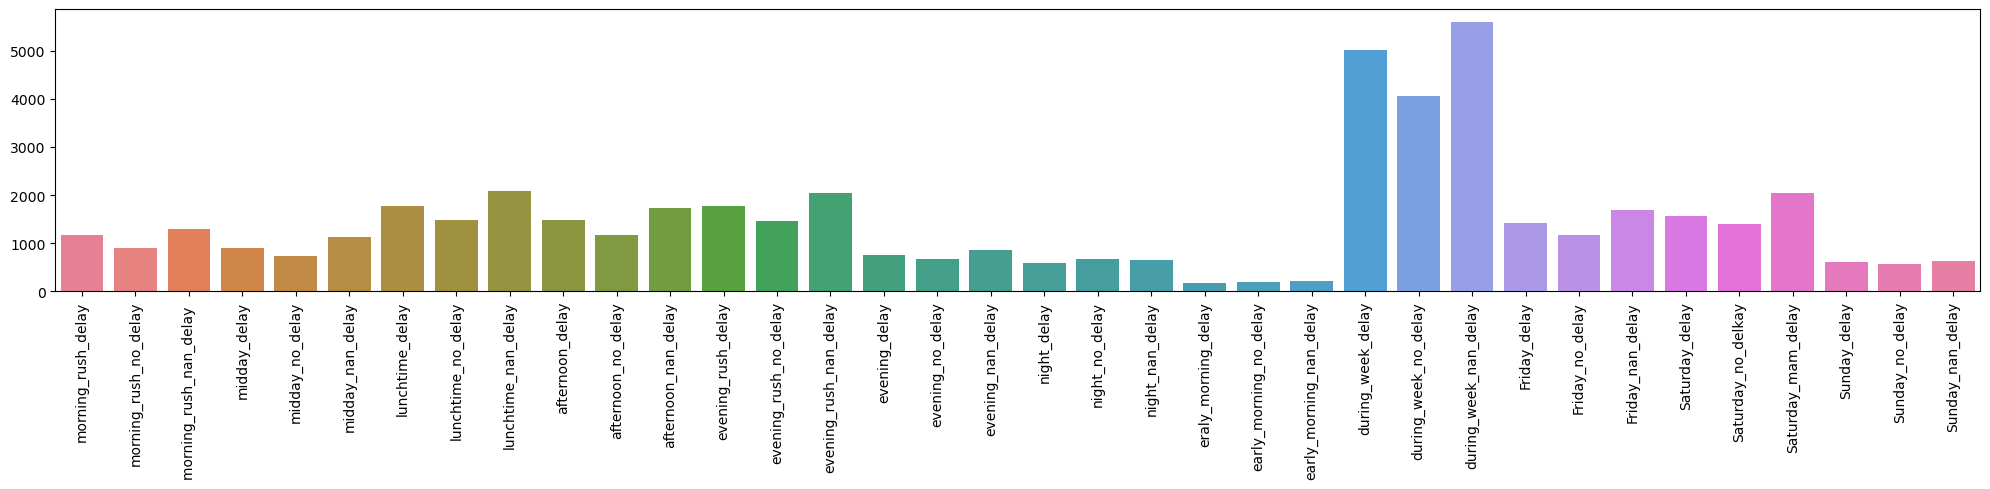

In [86]:
# Tier Trips
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[2]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_Count.png')
plt.show()

In [157]:
# need to change during week -> 4 days
T_02_2 = T_02.copy()
T_02_2['during_week_delay'].iloc[[2]] = T_02['during_week_delay'].iloc[[2]]/4
T_02_2['during_week_no_delay'].iloc[[2]] = T_02['during_week_no_delay'].iloc[[2]]/4
T_02_2['during_week_nan_delay'].iloc[[2]] = T_02['during_week_nan_delay'].iloc[[2]]/4

/tmp/ipykernel_3118112/4147138525.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[2]] = T_02['during_week_delay'].iloc[[2]]/4
/tmp/ipykernel_3118112/4147138525.py:3: FutureWarning: ChainedAssignmentError

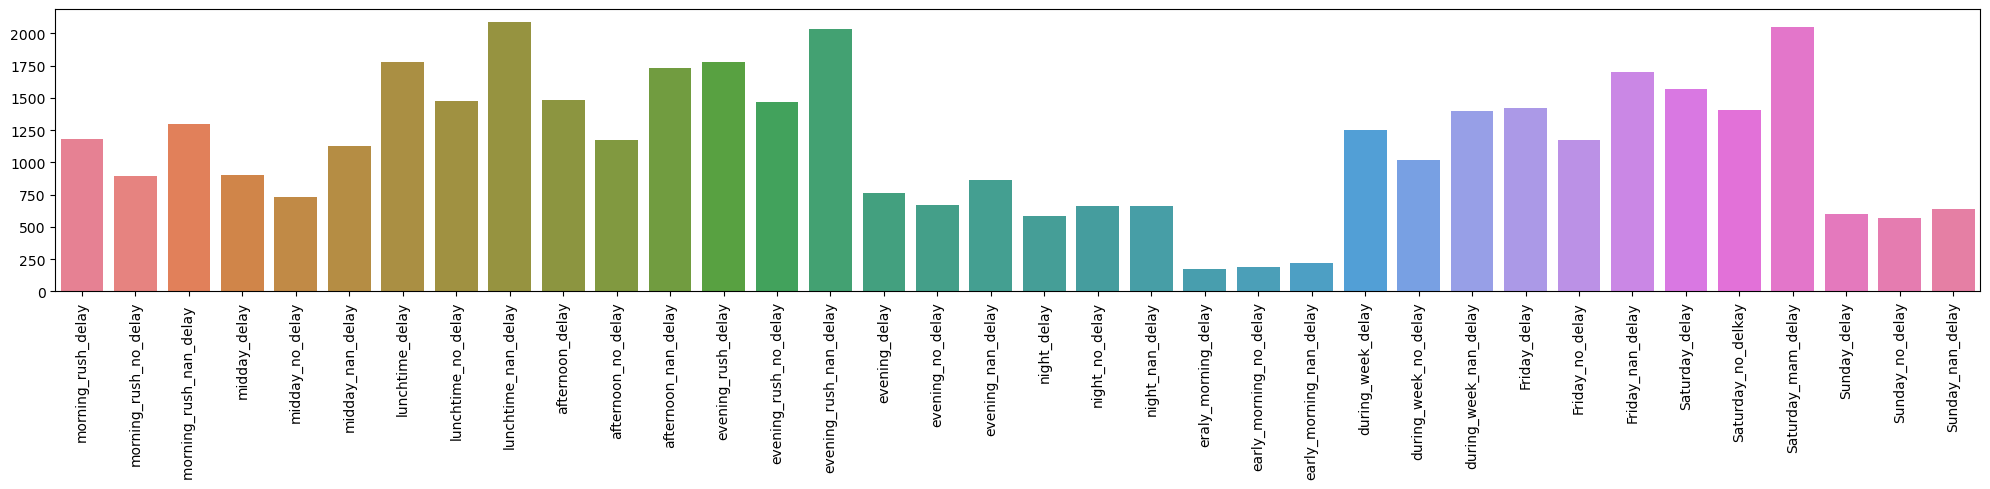

In [158]:
# Tier Trips
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[2]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_Count.png')
plt.show()

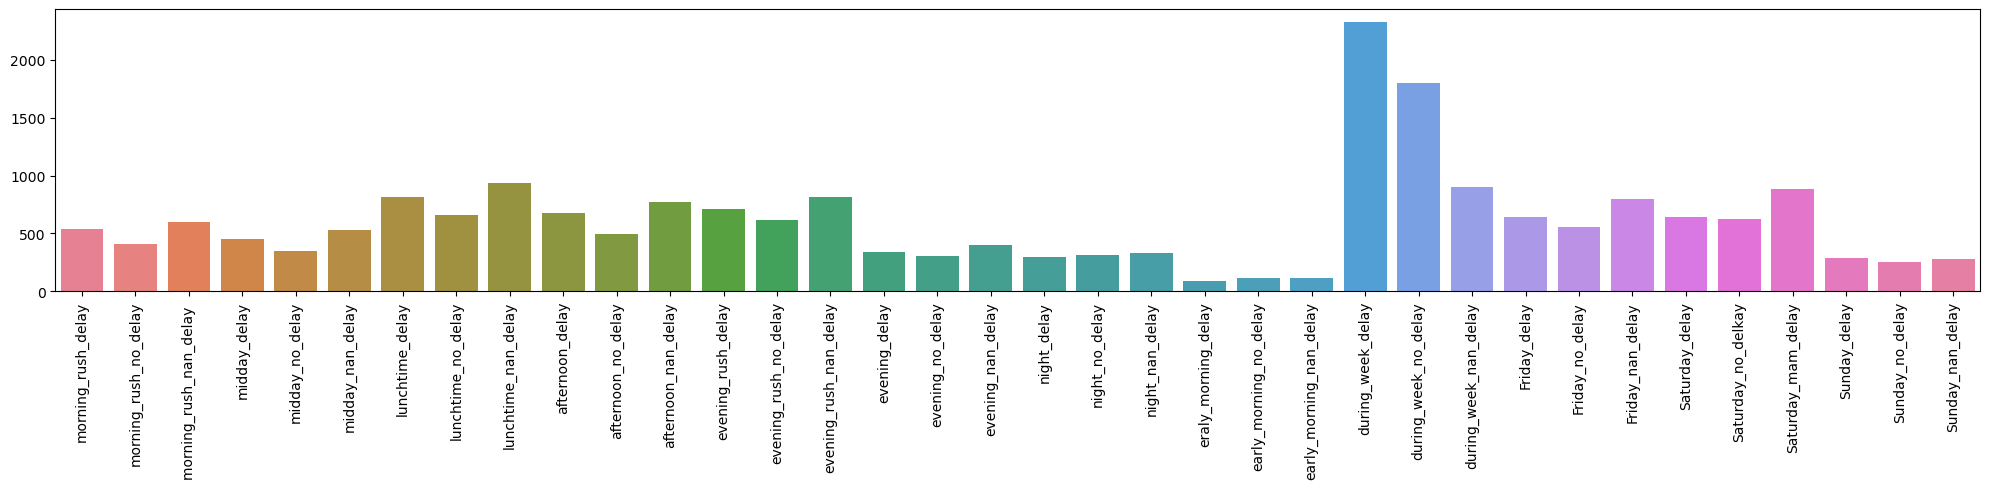

In [87]:
# Tier Trips End
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[3]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_End_Count.png')
plt.show()

In [159]:
# need to change during week -> 4 days
T_02_2 = T_02.copy()
T_02_2['during_week_delay'].iloc[[3]] = T_02['during_week_delay'].iloc[[3]]/4
T_02_2['during_week_no_delay'].iloc[[3]] = T_02['during_week_no_delay'].iloc[[3]]/4
T_02_2['during_week_nan_delay'].iloc[[3]] = T_02['during_week_nan_delay'].iloc[[3]]/4

/tmp/ipykernel_3118112/2012885697.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[3]] = T_02['during_week_delay'].iloc[[3]]/4
/tmp/ipykernel_3118112/2012885697.py:4: FutureWarning: ChainedAssignmentError

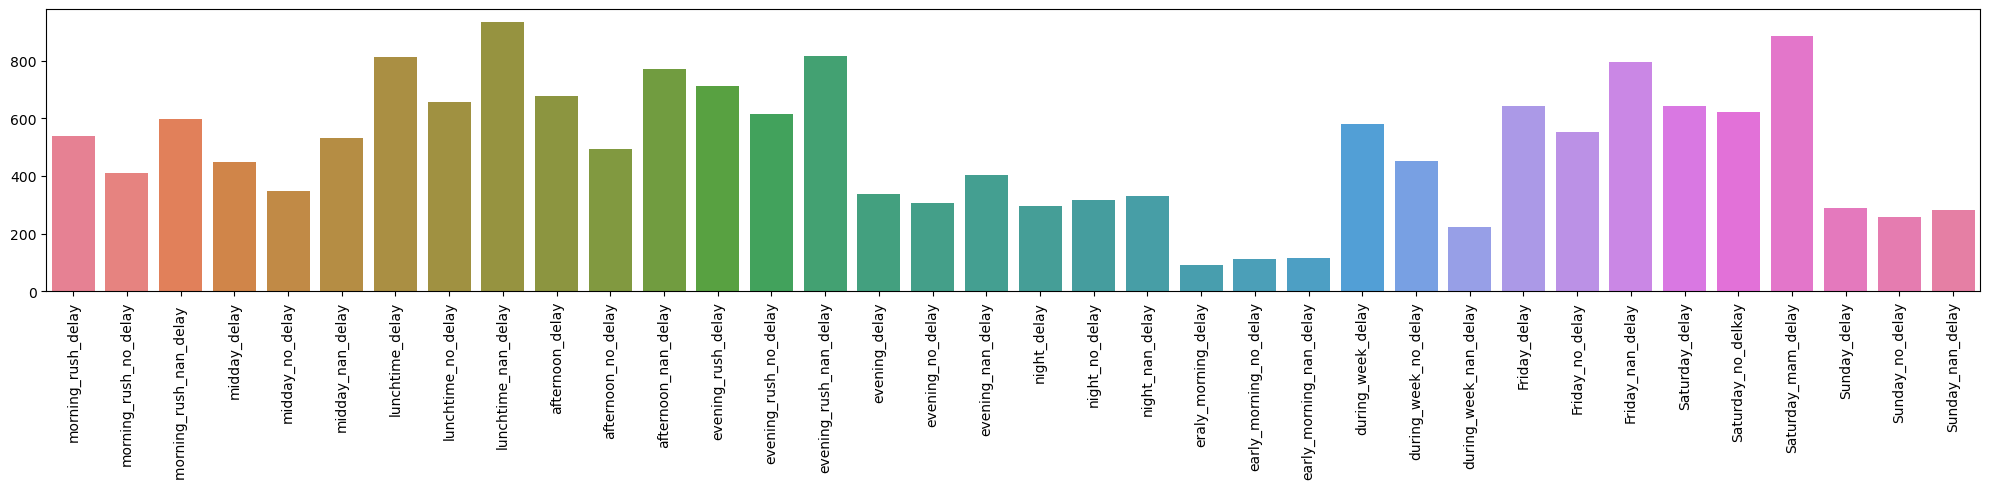

In [161]:
# Tier Trips End
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[3]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_End_Count.png')
plt.show()

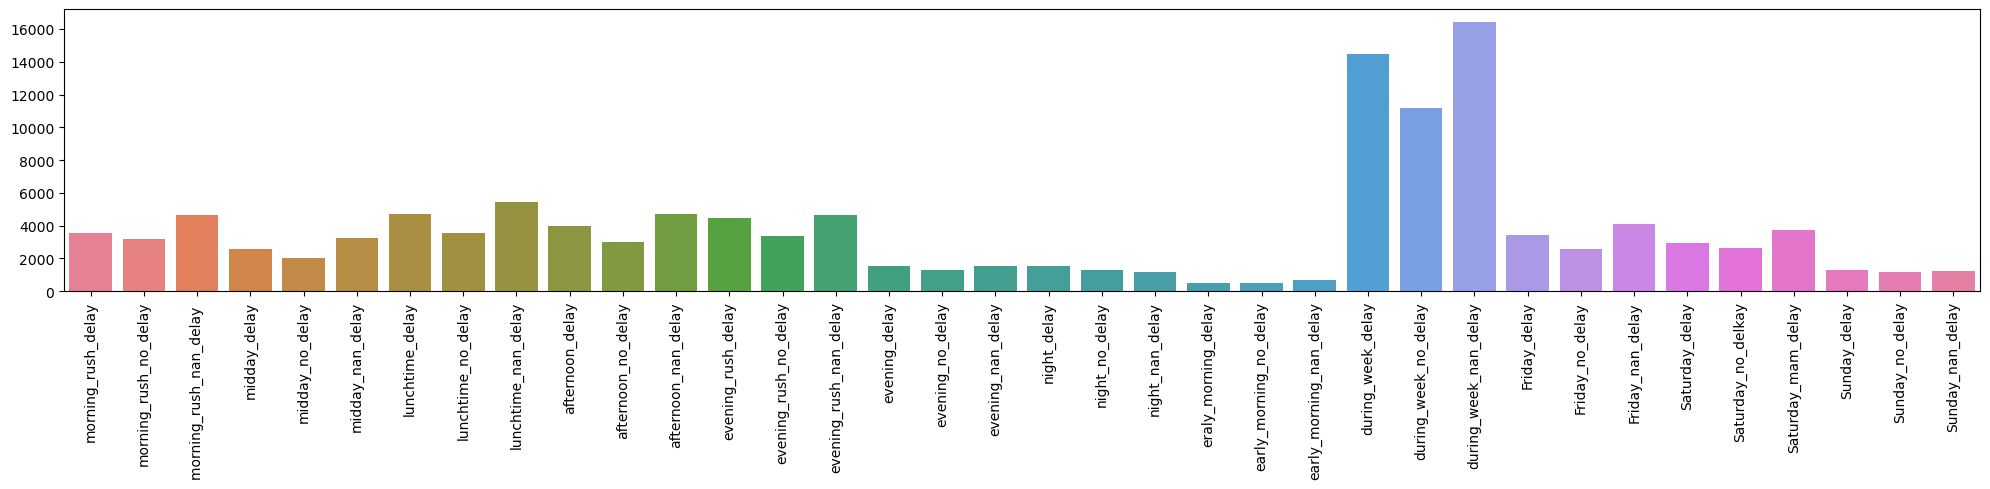

In [88]:
# Next Trips
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[5]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_Count.png')
plt.show()

In [162]:
# need to change during week -> 4 days
T_02_2 = T_02.copy()
T_02_2['during_week_delay'].iloc[[5]] = T_02['during_week_delay'].iloc[[5]]/4
T_02_2['during_week_no_delay'].iloc[[5]] = T_02['during_week_no_delay'].iloc[[5]]/4
T_02_2['during_week_nan_delay'].iloc[[5]] = T_02['during_week_nan_delay'].iloc[[5]]/4

/tmp/ipykernel_3118112/3736038543.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[5]] = T_02['during_week_delay'].iloc[[5]]/4
/tmp/ipykernel_3118112/3736038543.py:4: FutureWarning: ChainedAssignmentError

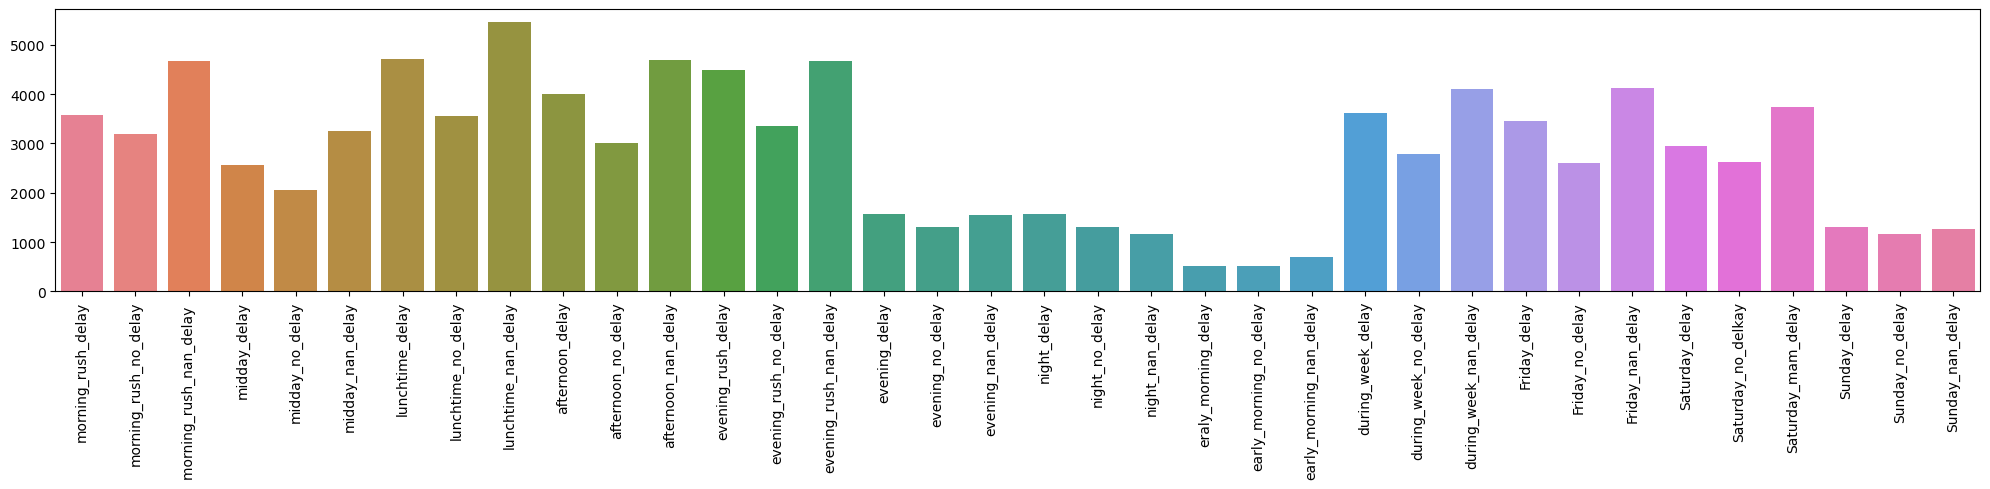

In [163]:
# Next Trips
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[5]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_Count.png')
plt.show()

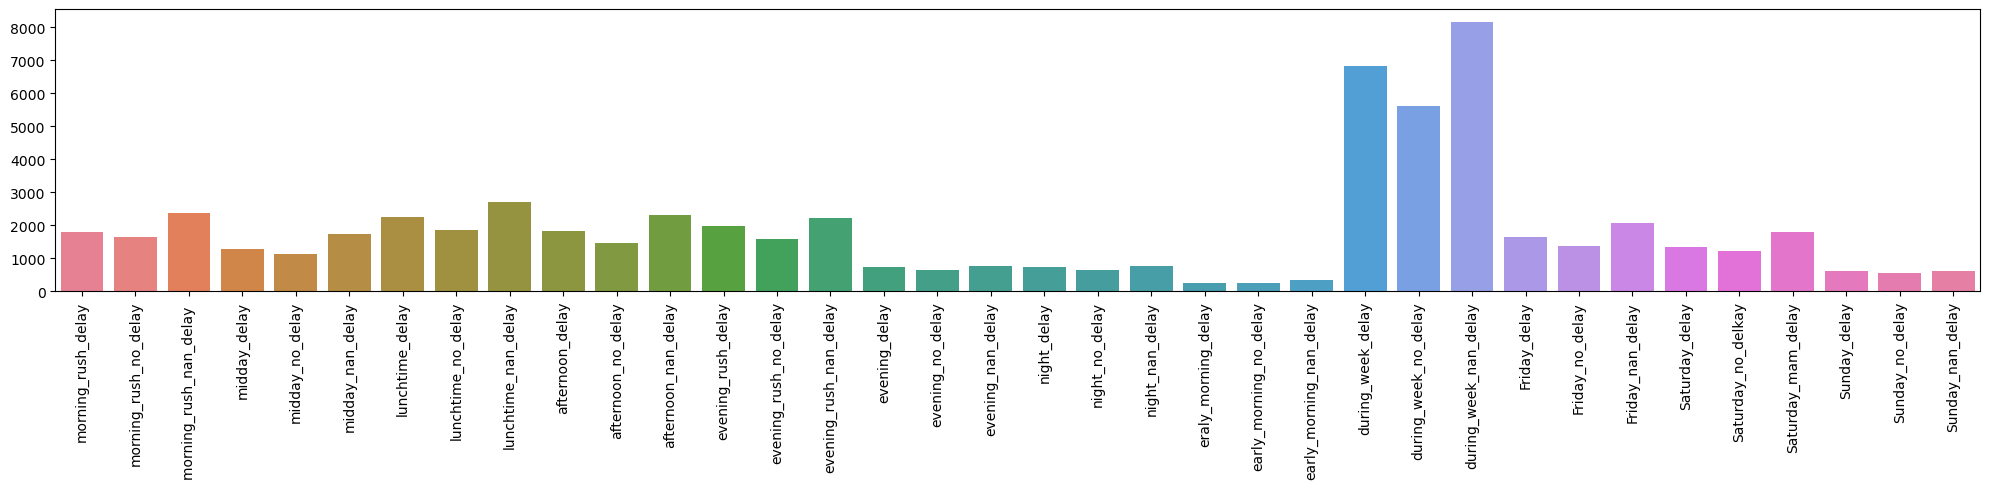

In [89]:
# Next Trips End
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[6]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_End_Count.png')
plt.show()

In [166]:
# need to change during week -> 4 days
T_02_2 = T_02.copy()
T_02_2['during_week_delay'].iloc[[6]] = T_02['during_week_delay'].iloc[[6]]/4
T_02_2['during_week_no_delay'].iloc[[6]] = T_02['during_week_no_delay'].iloc[[6]]/4
T_02_2['during_week_nan_delay'].iloc[[6]] = T_02['during_week_nan_delay'].iloc[[6]]/4

/tmp/ipykernel_3118112/3248189195.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[6]] = T_02['during_week_delay'].iloc[[6]]/4
/tmp/ipykernel_3118112/3248189195.py:4: FutureWarning: ChainedAssignmentError

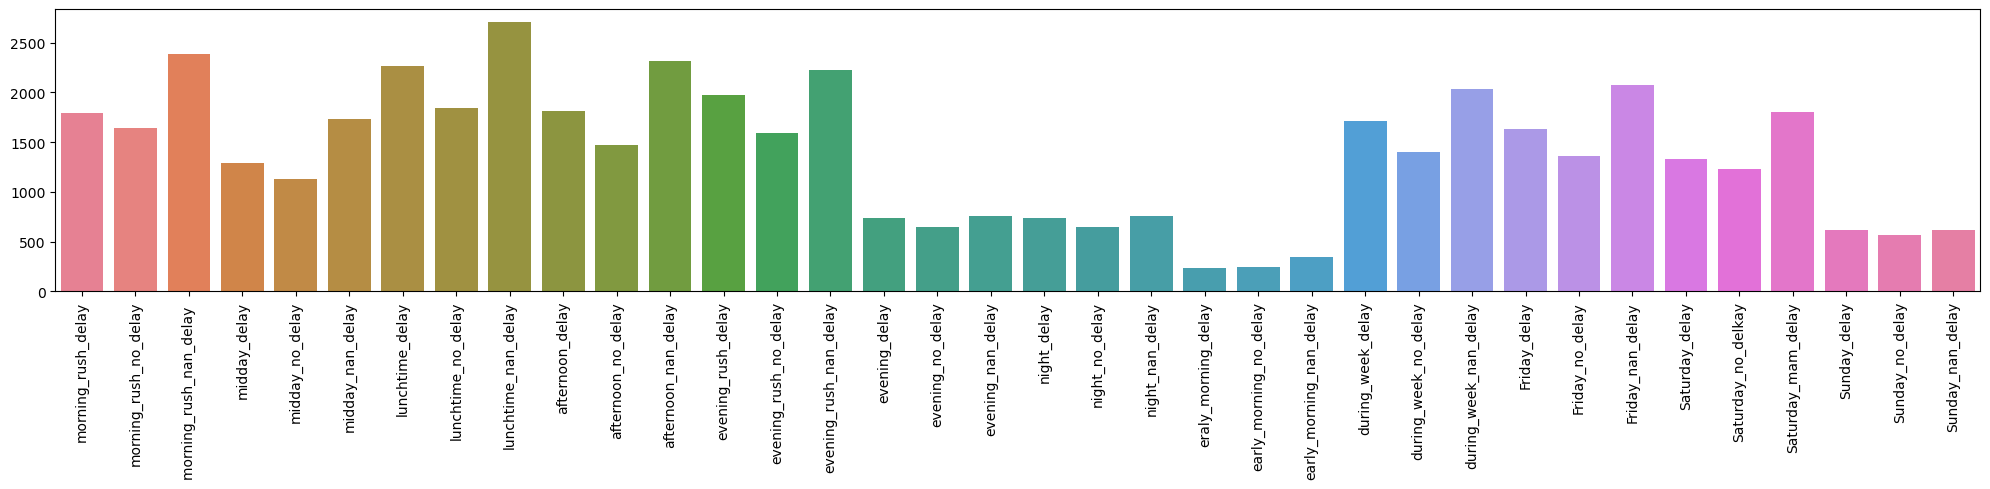

In [167]:
# Next Trips End
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[6]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_Trips_End_Count.png')
plt.show()

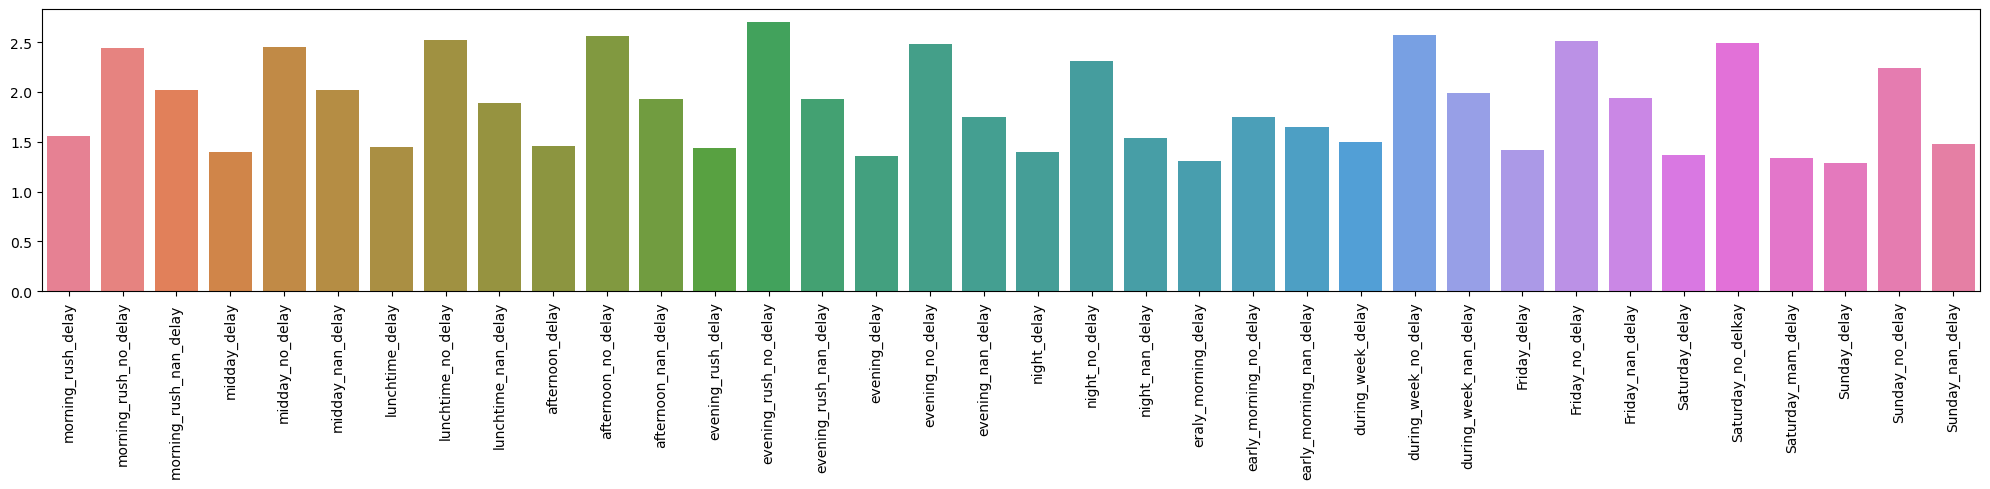

In [90]:
# Possible Tier Trips # Not so imporatnt chart
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[7]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_Trips_Possible_Trips.png')
plt.show()

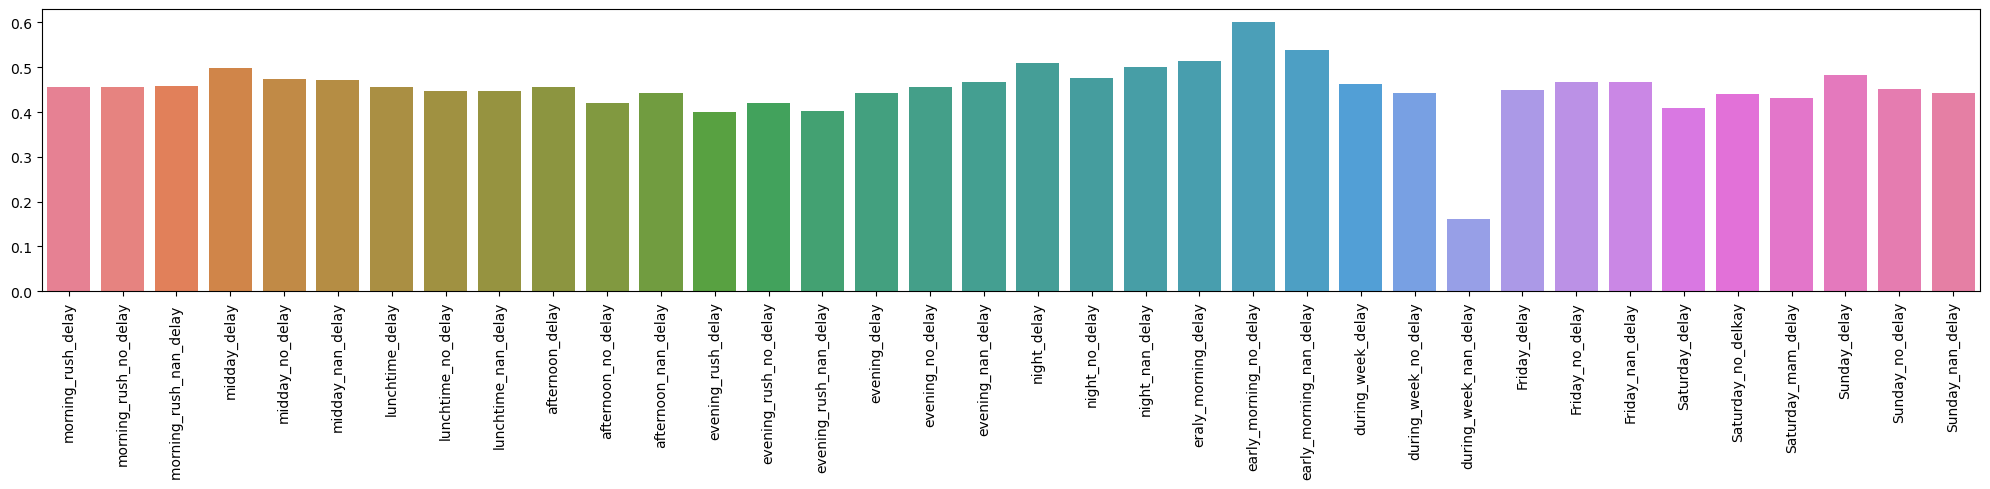

In [91]:
# Possible Tier End Amount 
#f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[9]]) 
#sns.barplot(data=desc_02.iloc[[6]] , ax=axes[1]) 

# Set the same y-axis limits for both plots
#axes[0].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
#axes[1].set_ylim(0, max(T_01.iloc[[5, 6]].max()) +500)
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_End_Percent.png')
plt.show()

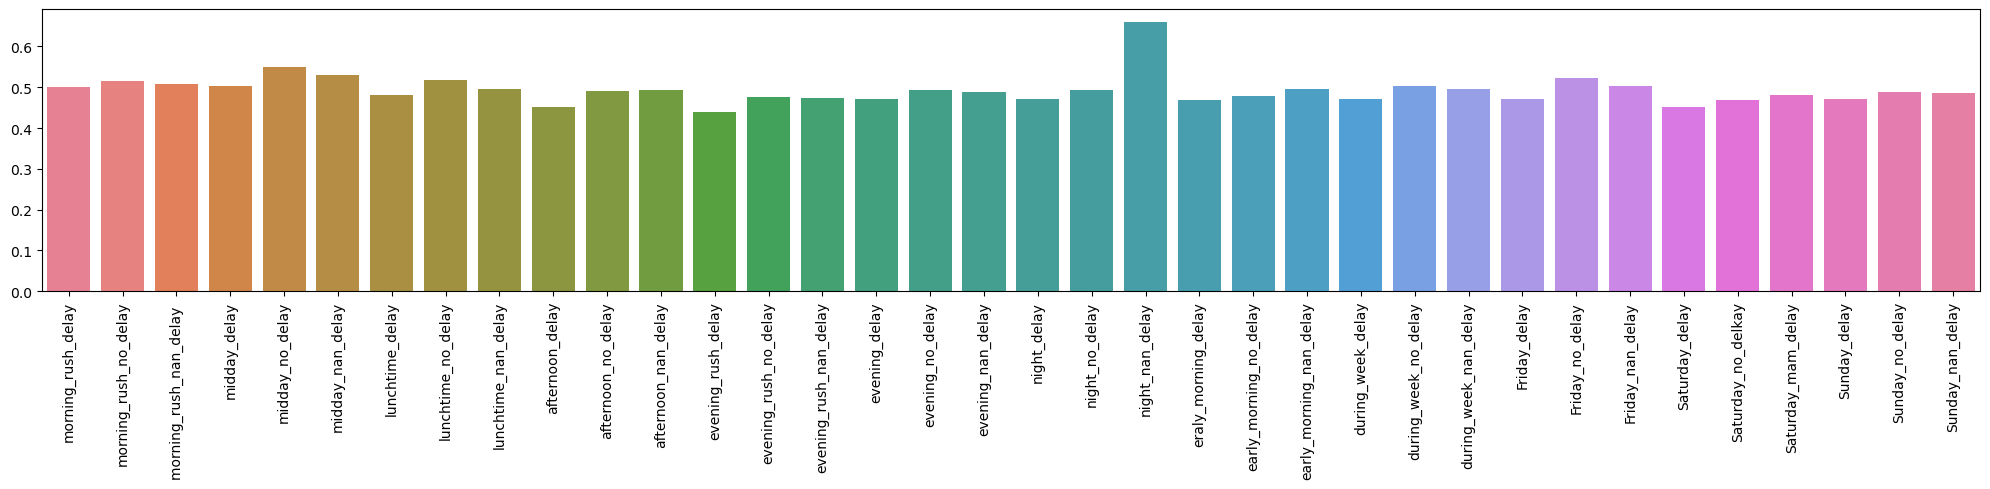

In [92]:
# Possible Next End Amount 
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[10]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_End_Percent.png')
plt.show()

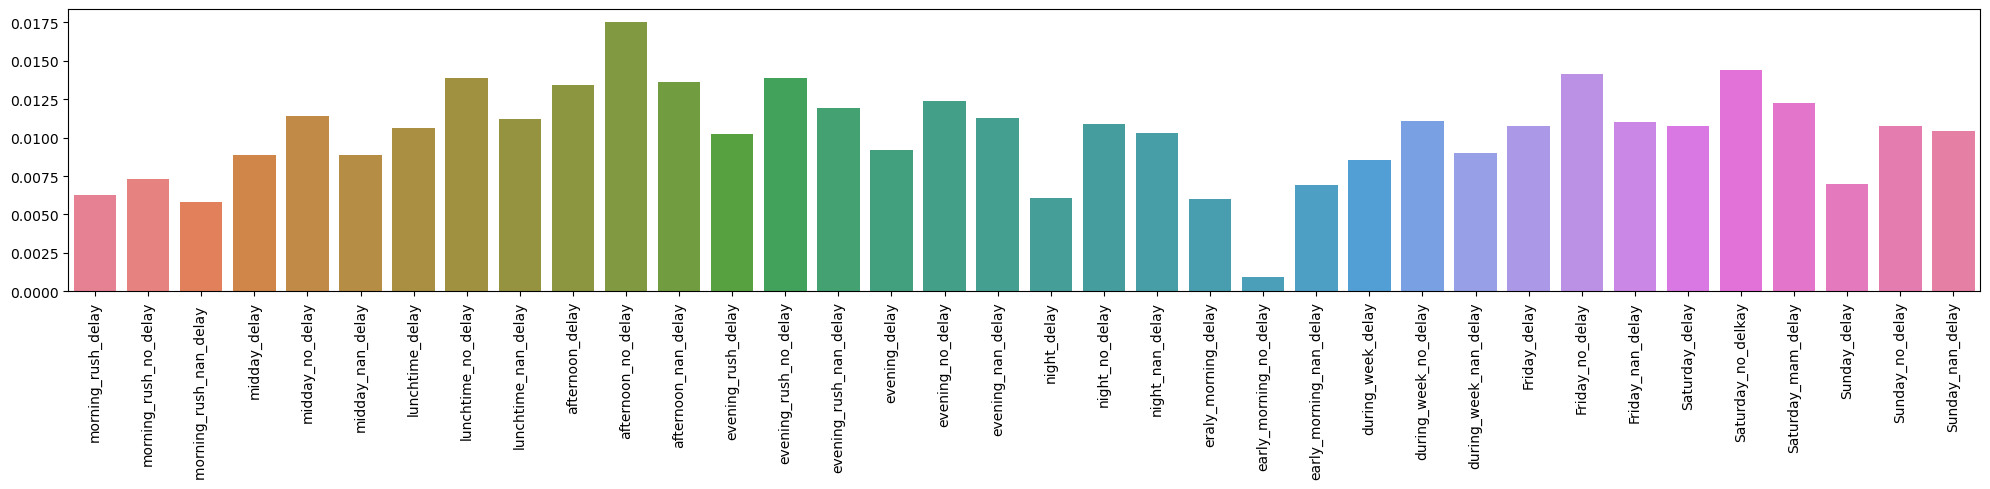

In [93]:
# Tier per Trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[11]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_per_PT_trip.png')
plt.show()

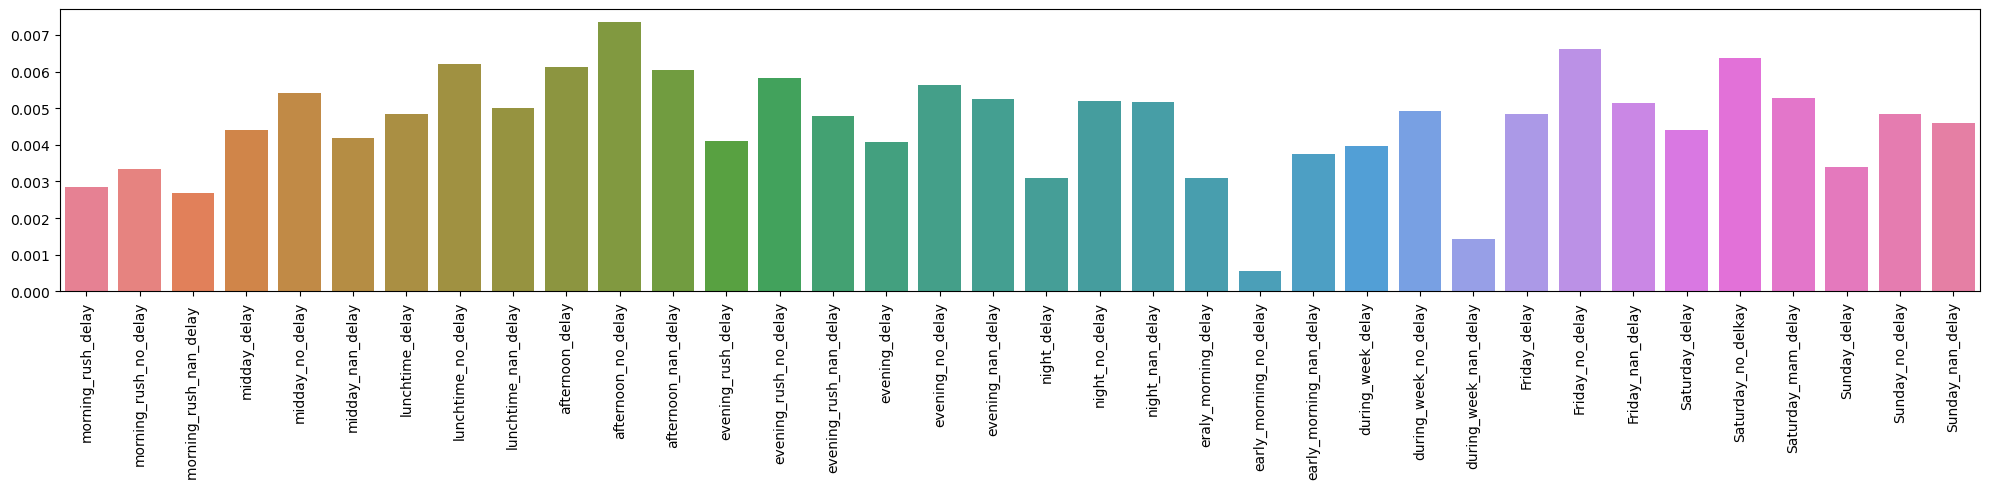

In [94]:
# Tier End per Trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[12]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_End_per_PT_trip.png')
plt.show()

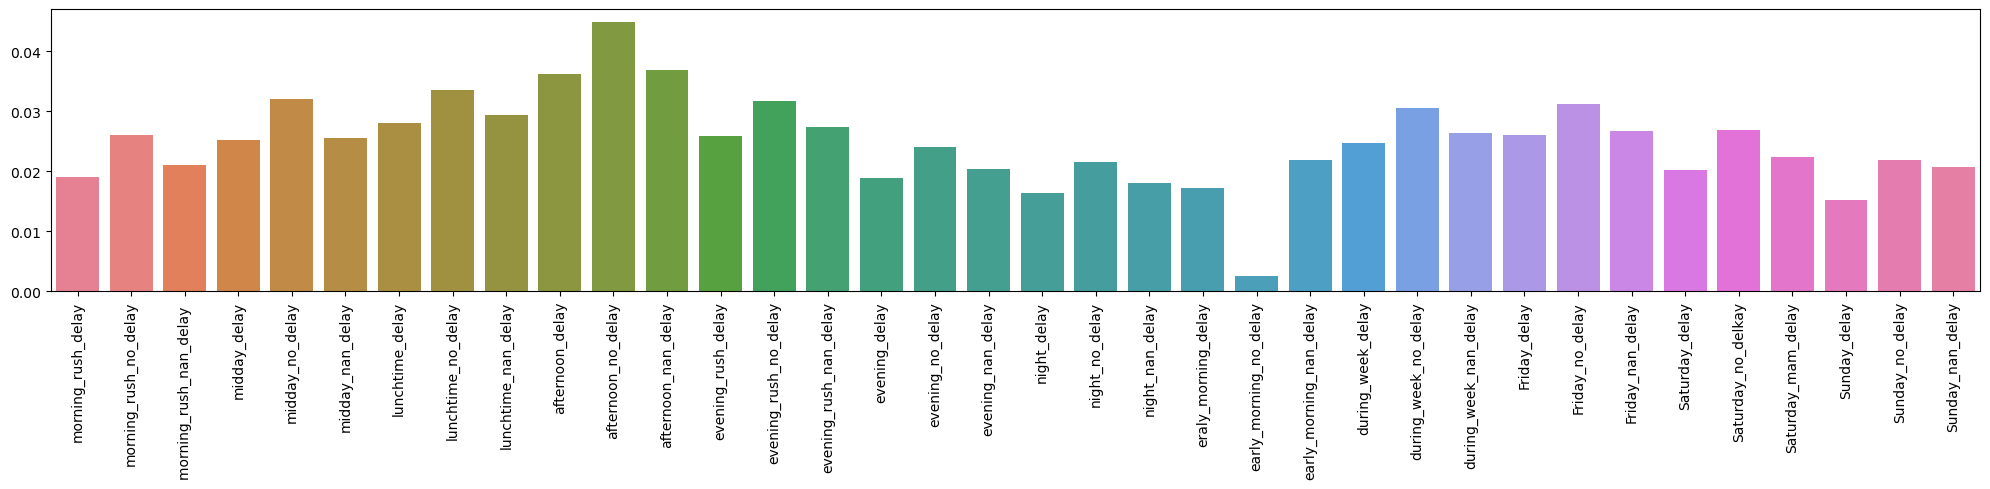

In [95]:
# Next per Trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[13]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_per_PT_trip.png')
plt.show()

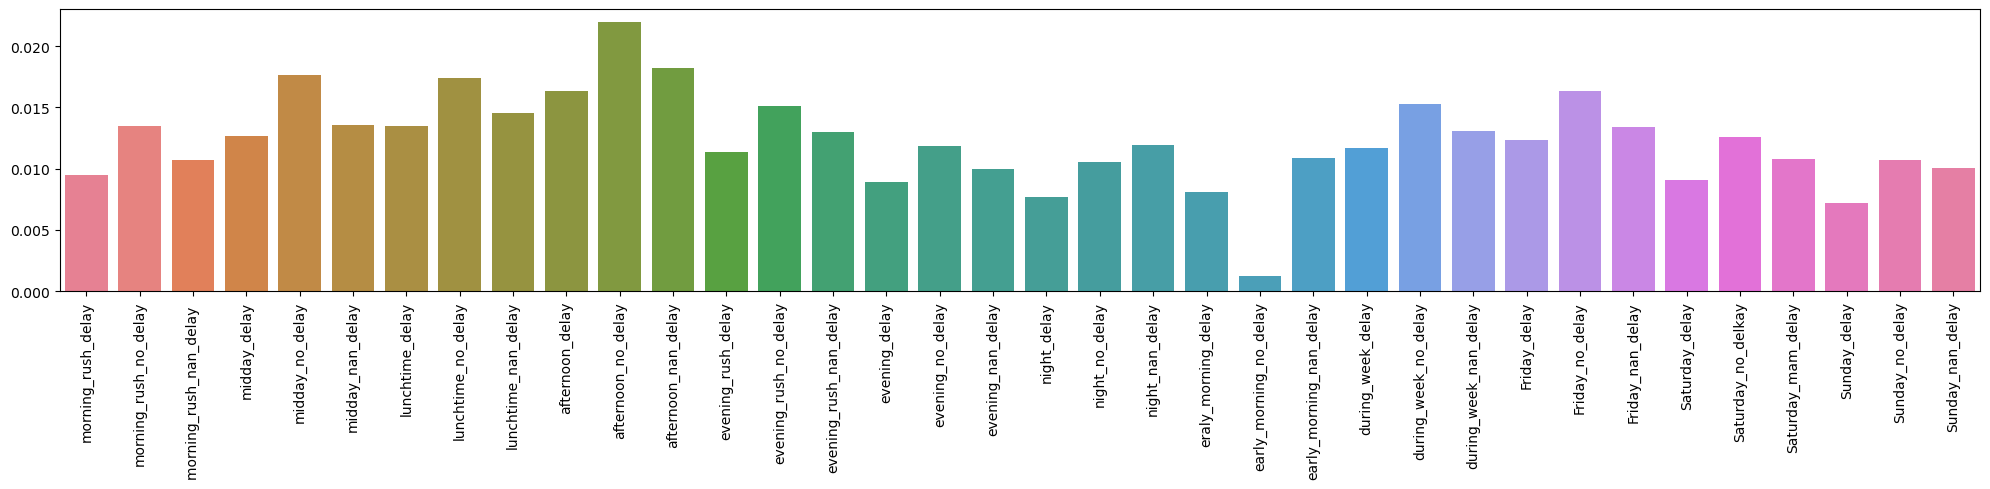

In [96]:
# Next End per Trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[14]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_End_per_PT_trip.png')
plt.show()

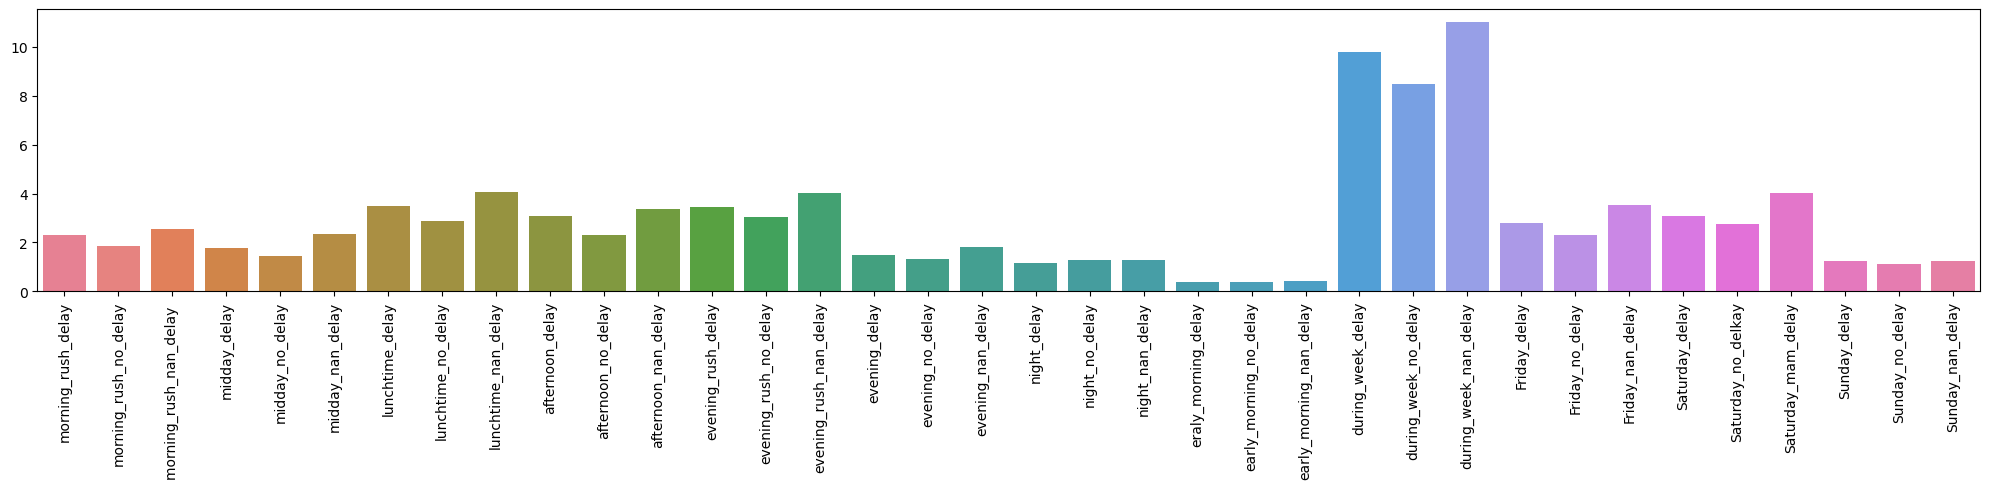

In [97]:
# Tier per Station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[16]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_per_Station.png')
plt.show()

In [168]:
T_02_2['during_week_delay'].iloc[[16]] = T_02['during_week_delay'].iloc[[16]]/4
T_02_2['during_week_no_delay'].iloc[[16]] = T_02['during_week_no_delay'].iloc[[16]]/4
T_02_2['during_week_nan_delay'].iloc[[16]] = T_02['during_week_nan_delay'].iloc[[16]]/4

/tmp/ipykernel_3118112/2756113554.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[16]] = T_02['during_week_delay'].iloc[[16]]/4
/tmp/ipykernel_3118112/2756113554.py:2: FutureWarning: ChainedAssignmentErr

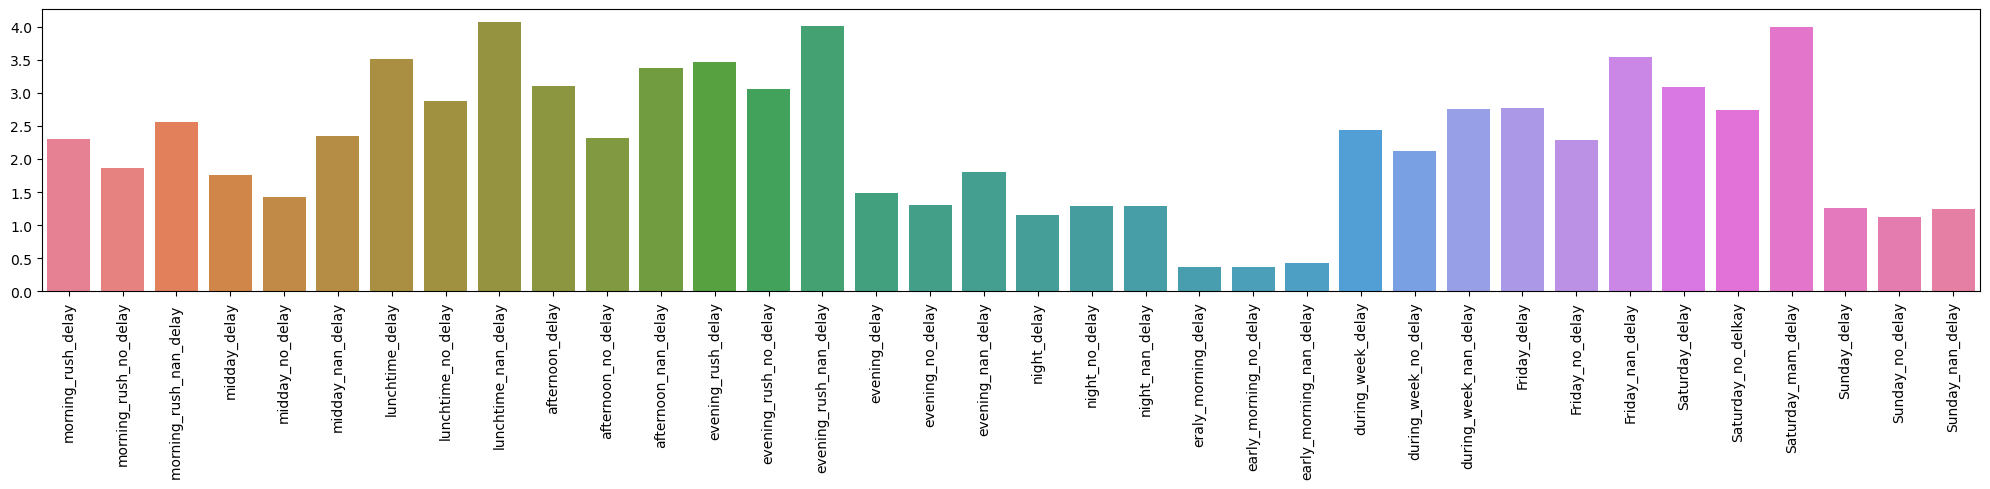

In [174]:
# Tier per Station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[16]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Tier_per_Station.png')
plt.show()

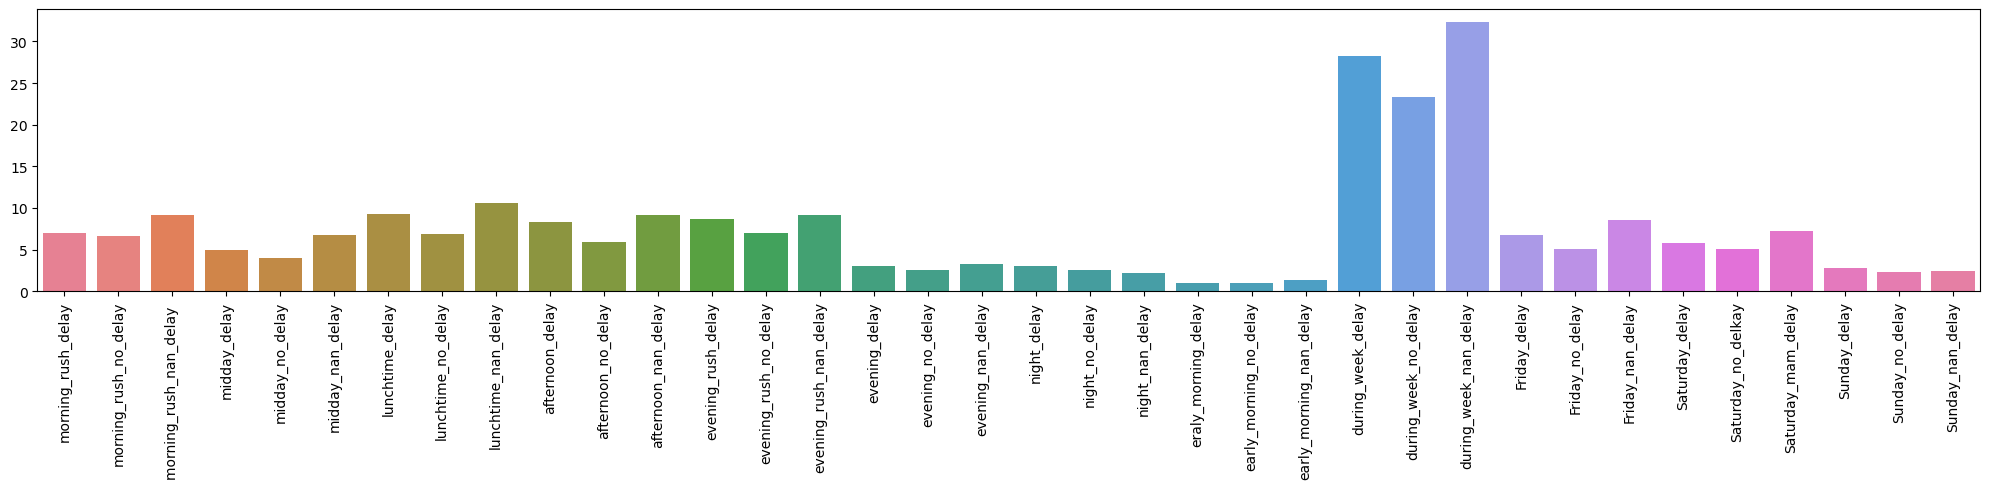

In [98]:
# Next per Station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02.iloc[[17]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_per_Station.png')
plt.show()

In [175]:
T_02_2['during_week_delay'].iloc[[17]] = T_02['during_week_delay'].iloc[[17]]/4
T_02_2['during_week_no_delay'].iloc[[17]] = T_02['during_week_no_delay'].iloc[[17]]/4
T_02_2['during_week_nan_delay'].iloc[[17]] = T_02['during_week_nan_delay'].iloc[[17]]/4

/tmp/ipykernel_3118112/4026877558.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T_02_2['during_week_delay'].iloc[[17]] = T_02['during_week_delay'].iloc[[17]]/4
/tmp/ipykernel_3118112/4026877558.py:2: FutureWarning: ChainedAssignmentErr

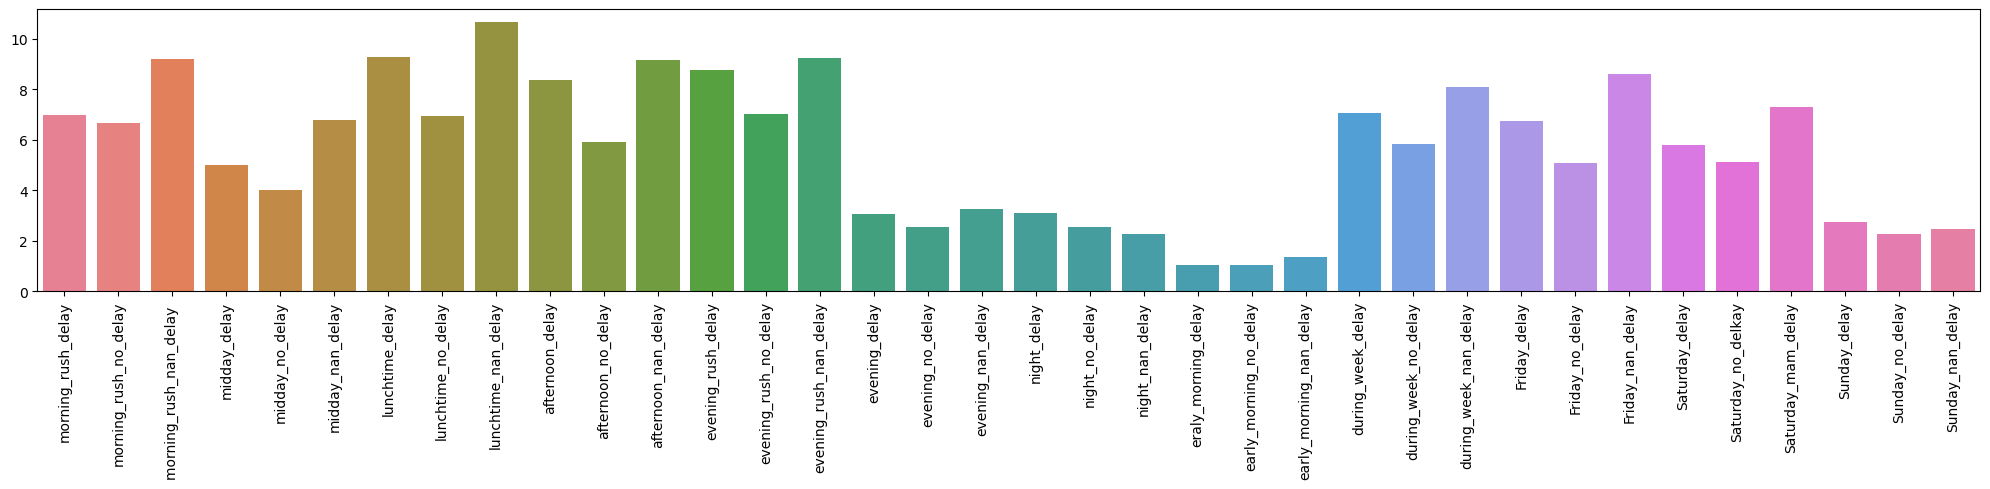

In [176]:
# Nextper Station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_02_2.iloc[[17]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/02_Next_per_Station.png')
plt.show()

## Desc 03

In [99]:
desc_03

Unnamed: 0          warm_delay  \
0                               (data) complete trips              399470   
1                         (data) tier trips count sum                4003   
2                              (data) tier trips mean                0.01   
3          (data) tier trips end at station count sum                3279   
4          (data) tier trips end at station count sum              0.0082   
5                               (tier) tier data trip                2766   
6                               (tier) trip avg lengt               1.717   
7                            (tier) trip length range       0,1 - 13,9087   
8                            (tier) trip duration avg            833.1887   
9                          (tier) trip duration range         300 - 6300    
10         (tier) trip start and end at station count                1277   
11   (tier) trip start and end at station mean length              1.4554   
12  (tier) trip start and end at station range length        0,1 - 6,4287   
13  (tier) trip start and end at station mean dura...            800.1566   
14  (tier) trip start and end at station range dur...  300 - 6000 seconds   
15                        (data) next trips count sum               10275   
16                            (data) next trips mean               0.0257   
17               (data) next end at station count sum                8761   
18              (data) next end at station count mean              0.0219   
19                               (next) nextdata trip                7121   
20                              (next) trip avg lengt              1.7771   
21                           (next) trip length range       0,1 - 13,1722   
22                      (next) trip duration average             866.3306   
23                         (next) trip duration range           300 -7200   
24         (next) trip start and end at station count                3352   
25   (next) trip start and end at station mean length              1.4647   
26  (next) trip start and end at station range length        0,1 - 9,6407   
27  (next) trip start and end at station mean dura...            793.1205   
28  (next) trip start and end at station range dur...          300 - 4800   

    warm_no_delay warm_nan_delay      hot_delay   hot_no_delay  hot_nan_delay  \
0          258974         431069         550796         341204         574544   
1            6130           6535           8469          12050          12532   
2          0.0237         0.0152        0.01538         0.0353        0.02181   
3            4978           5332           6908           9674          10062   
4          0.0192         0.0124         0.0125         0.0284         0.0175   
5            2462           3339           5852           4762           6658   
6          1.7938         1.7538         1.7418         1.7566         1.7831   
7   0,1 - 11,3768  0,1 - 13,9ß87  0,1 - 11,8531  0,1 - 12,4020  0,1 - 13,5832   
8        841.6084       833.6927       853.4723       856.5309       869.4683   
9      300 - 7200     300 - 6300     300 - 6900     300 - 6900     300 - 6900   
10           1114           1523           2623           2122           2959   
11         1.5256           1.49         1.4075         1.4549         1.4731   
12   0,1 - 6,7624   0,1 - 8,7431   0,1 - 9,0938   0,1 - 8,8875  0,1 - 13,5832   
13       798.1508       790.4793       761.1742       774.5994       785.9618   
14     300 - 6000     300 - 6000     300 - 6300     300 - 6900     300 - 6900   
15          14067          16800          23209          27138          31398   
16         0.0543          0.039         0.0421         0.0795         0.0546   
17          11928          14161          19396          22502          26034   
18         0.0461       0.032851         0.0352         0.0659         0.0453   
19           6197           8968          15108          11388          16573   
20         1.7463         1.727

In [100]:
desc_03 = desc_03.set_index(desc_03.columns[0])

In [101]:
desc_03.to_csv("Tables/Desc_03.csv")

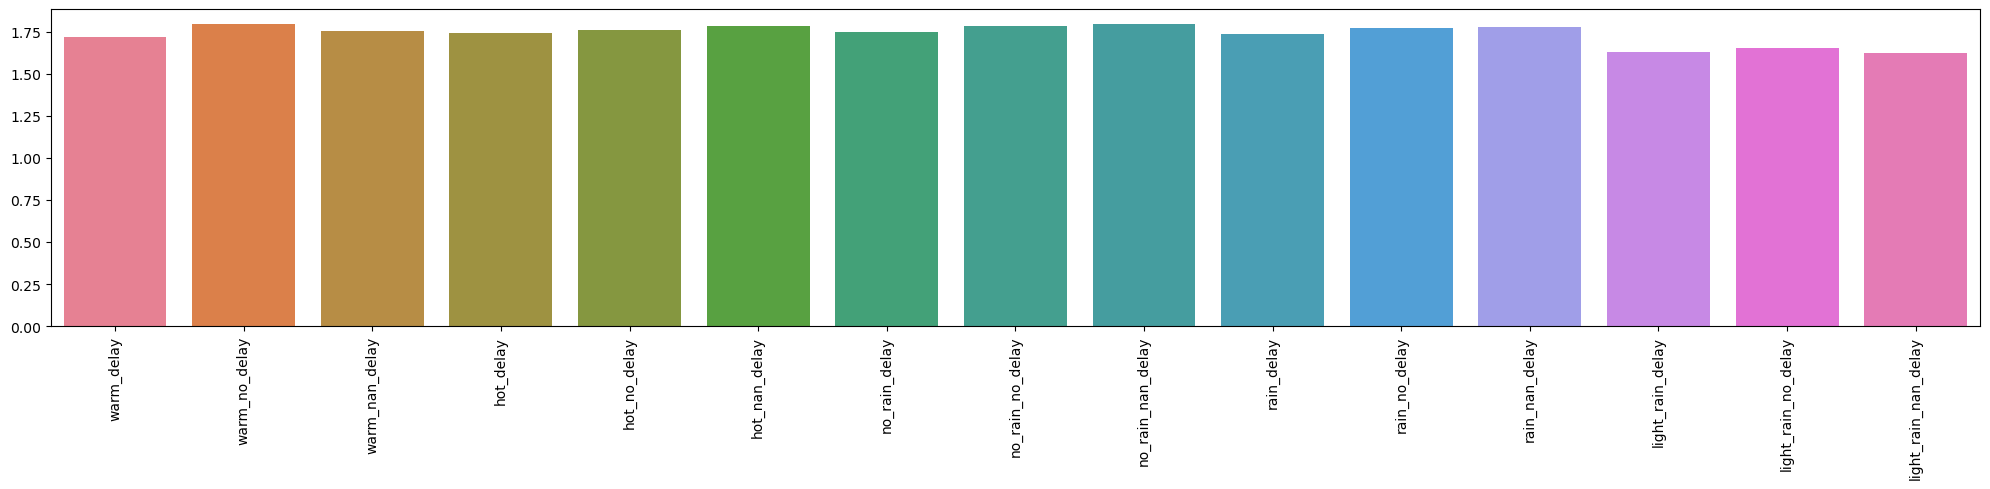

In [102]:
# Tier Trip Length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[6]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_Length.png')
plt.show()

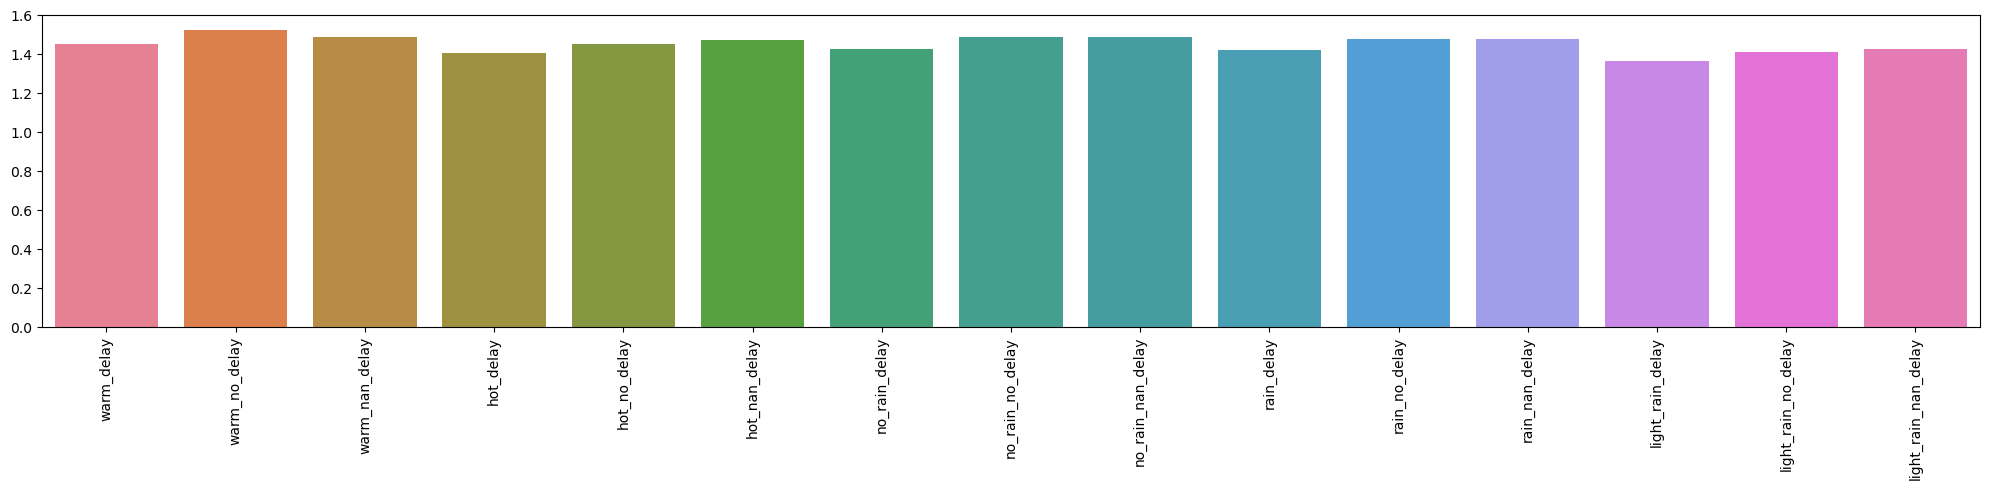

In [103]:
# Tier Trip Length End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[11]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_End_Lenght.png')
plt.show()

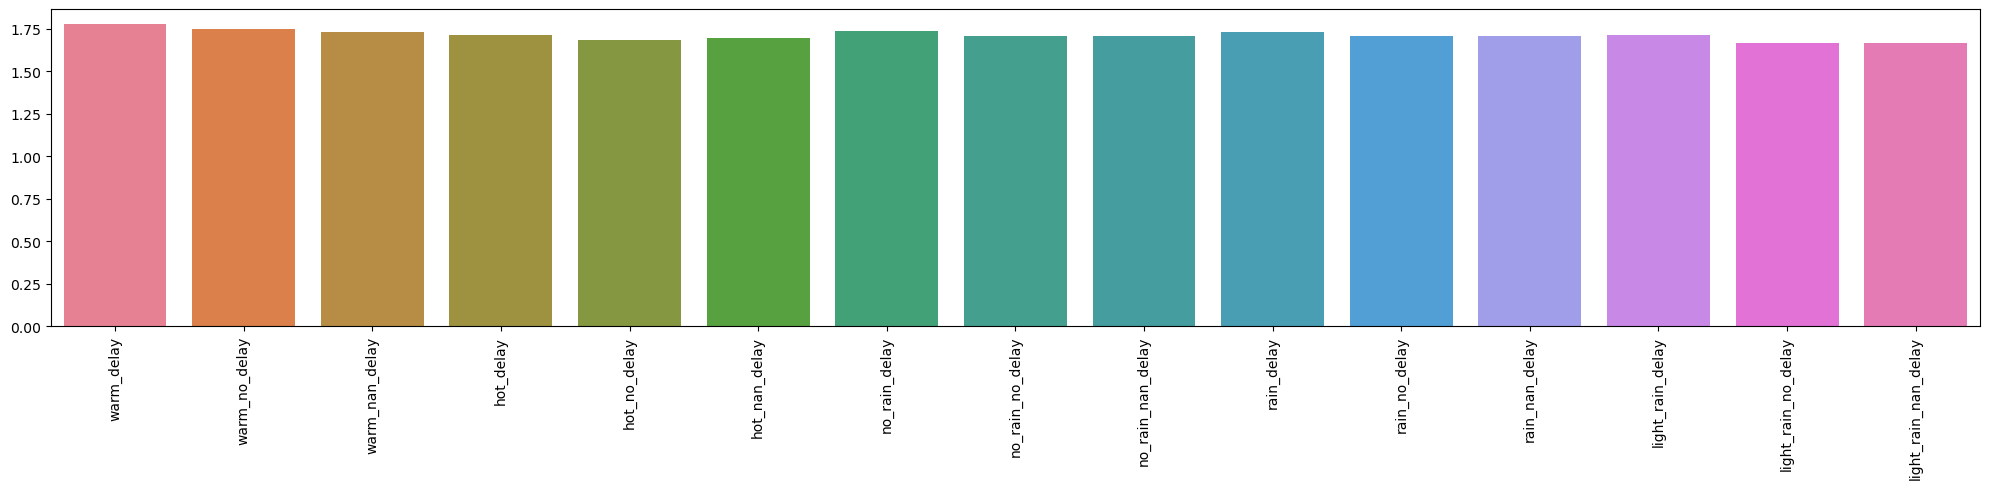

In [104]:
# Next Trip Length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[20]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_End.png')
plt.show()

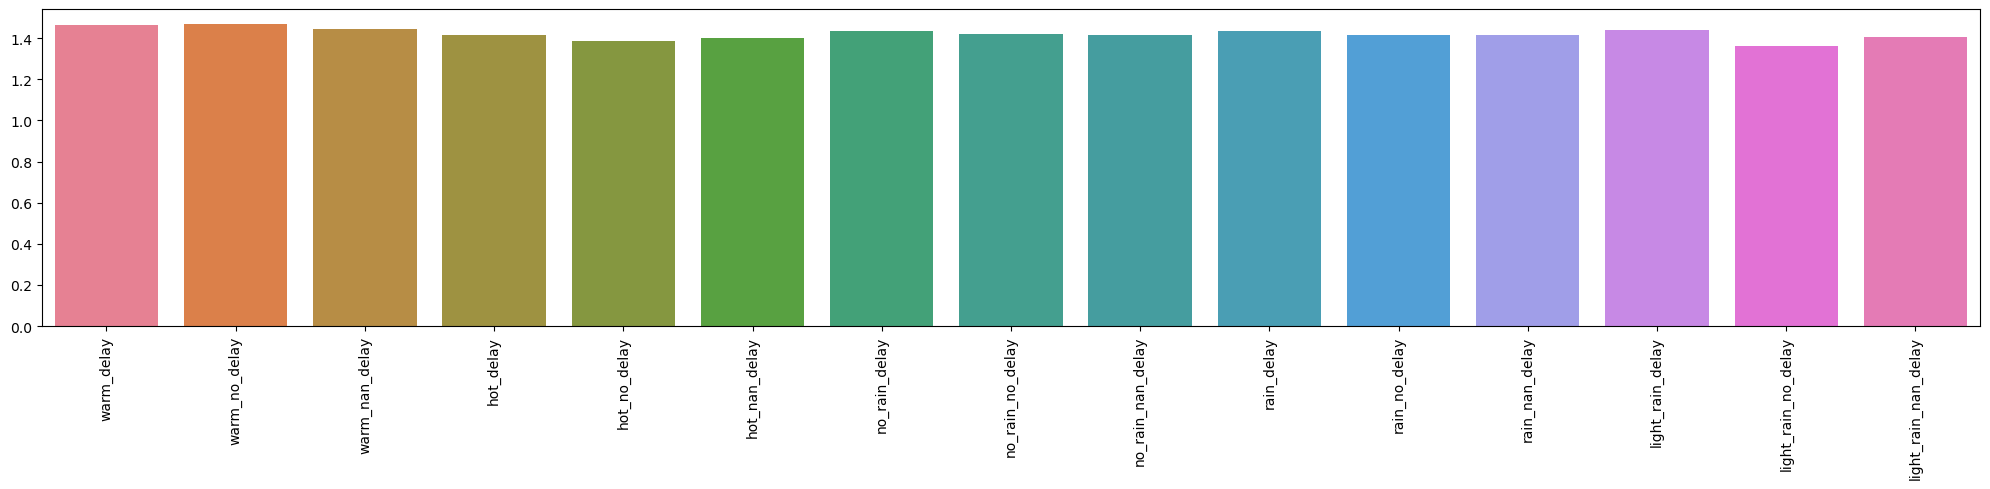

In [105]:
# Next Trip Length End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[25]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_End_Length.png')
plt.show()

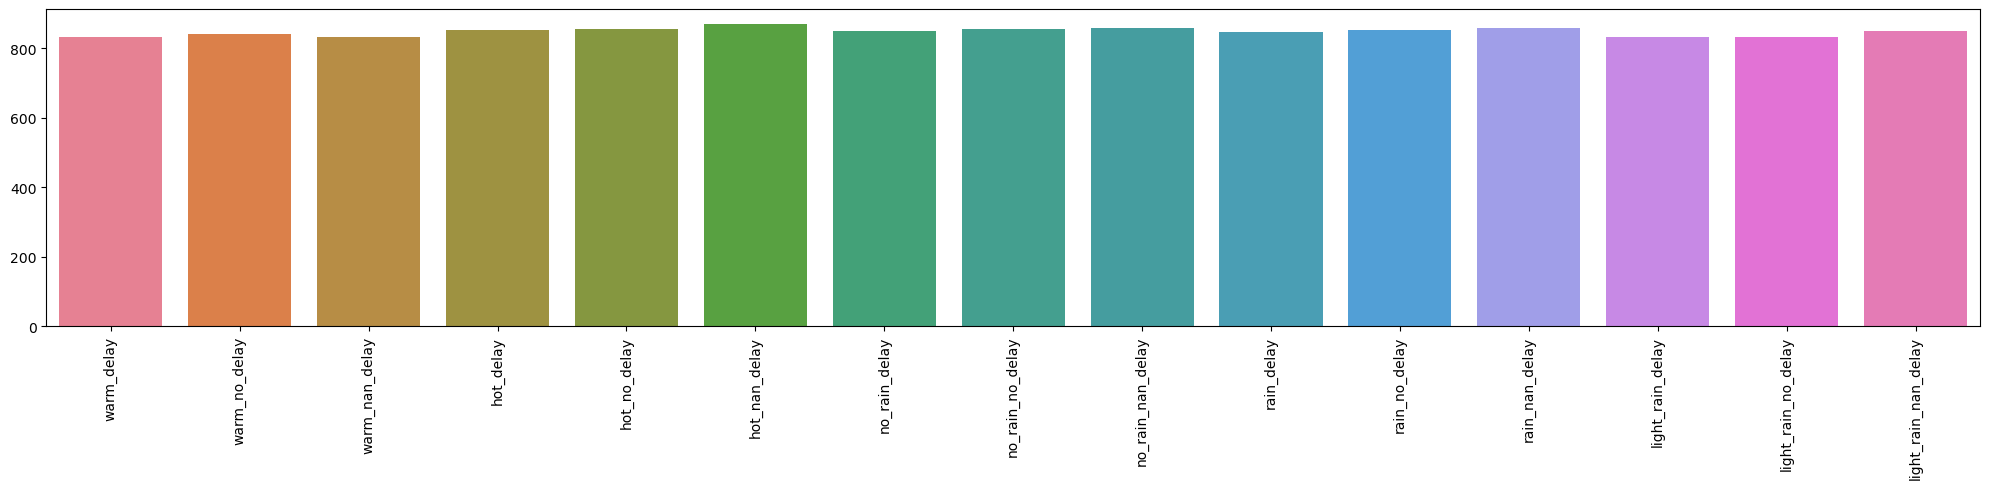

In [106]:
# Tier Trip Duration
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[8]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_Duration.png')
plt.show()

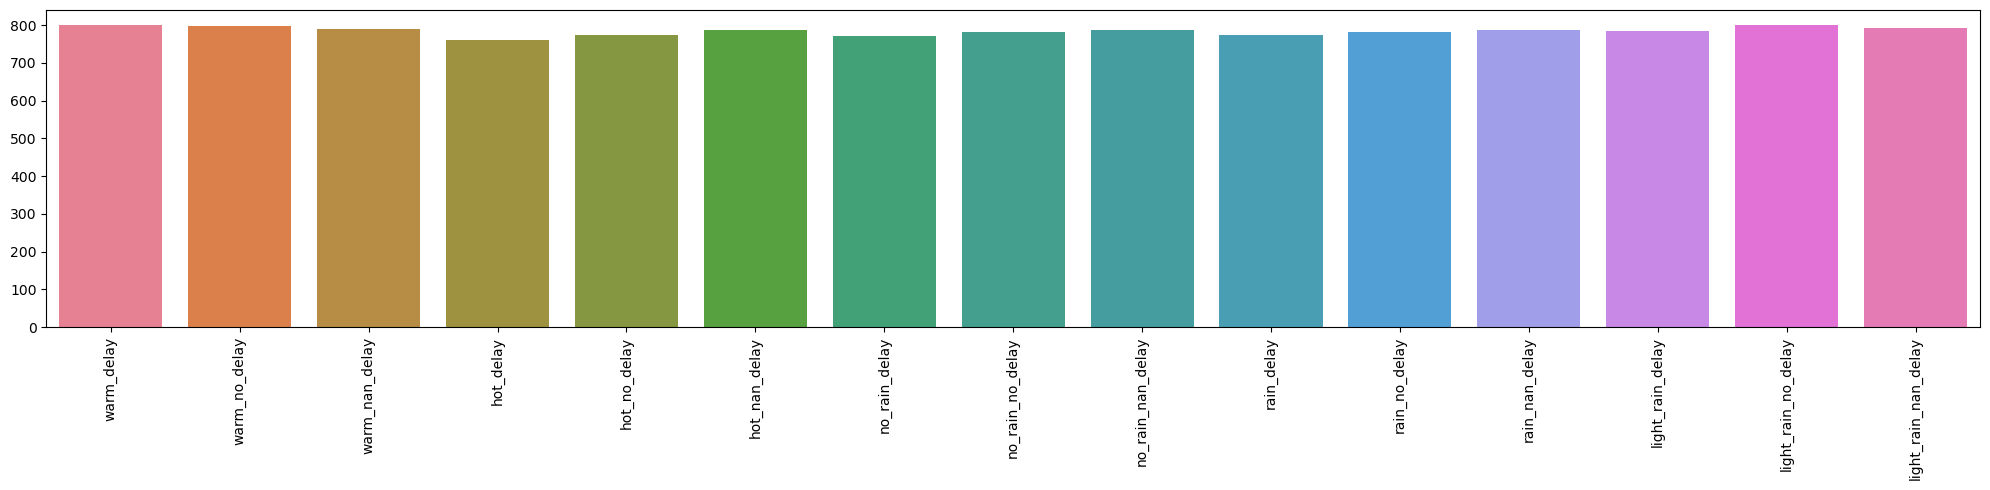

In [107]:
# Tier Trip Duration End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[13]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_End_Duration.png')
plt.show()

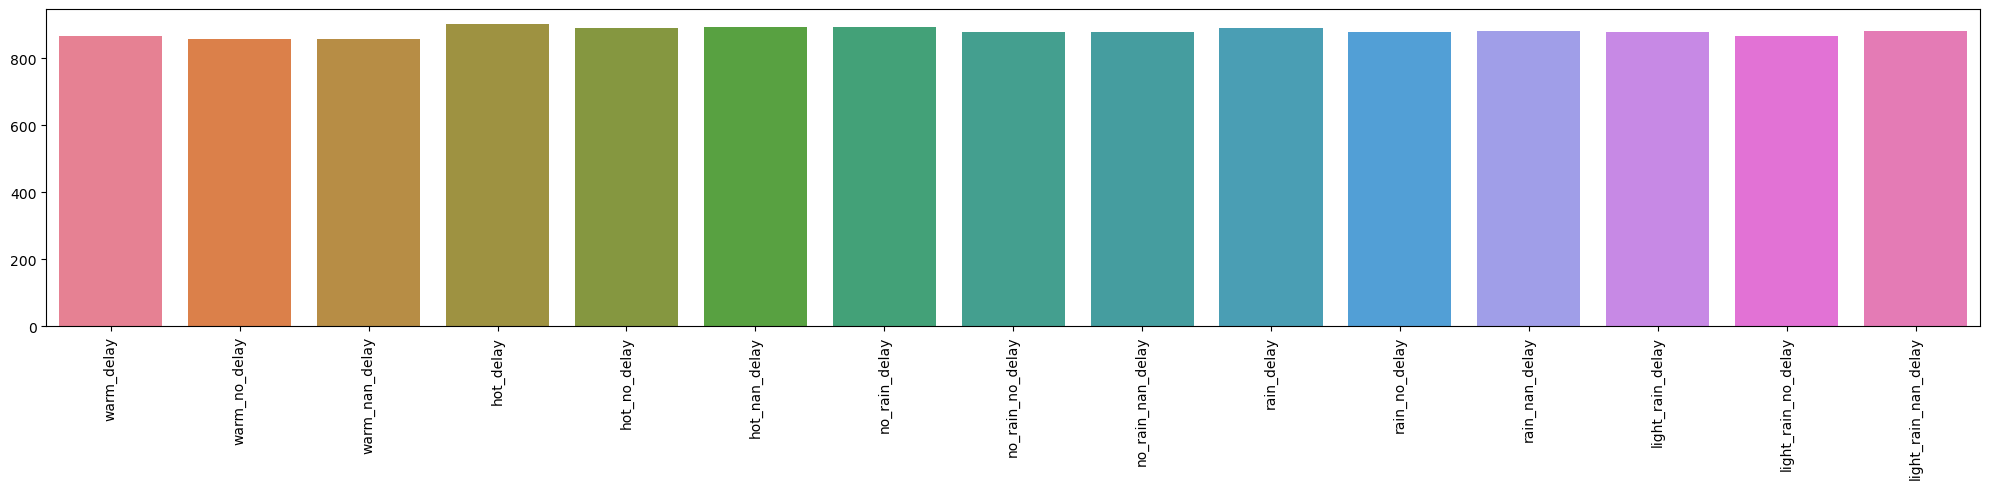

In [108]:
# Next Trip Duration
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[22]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_Duration.png')
plt.show()

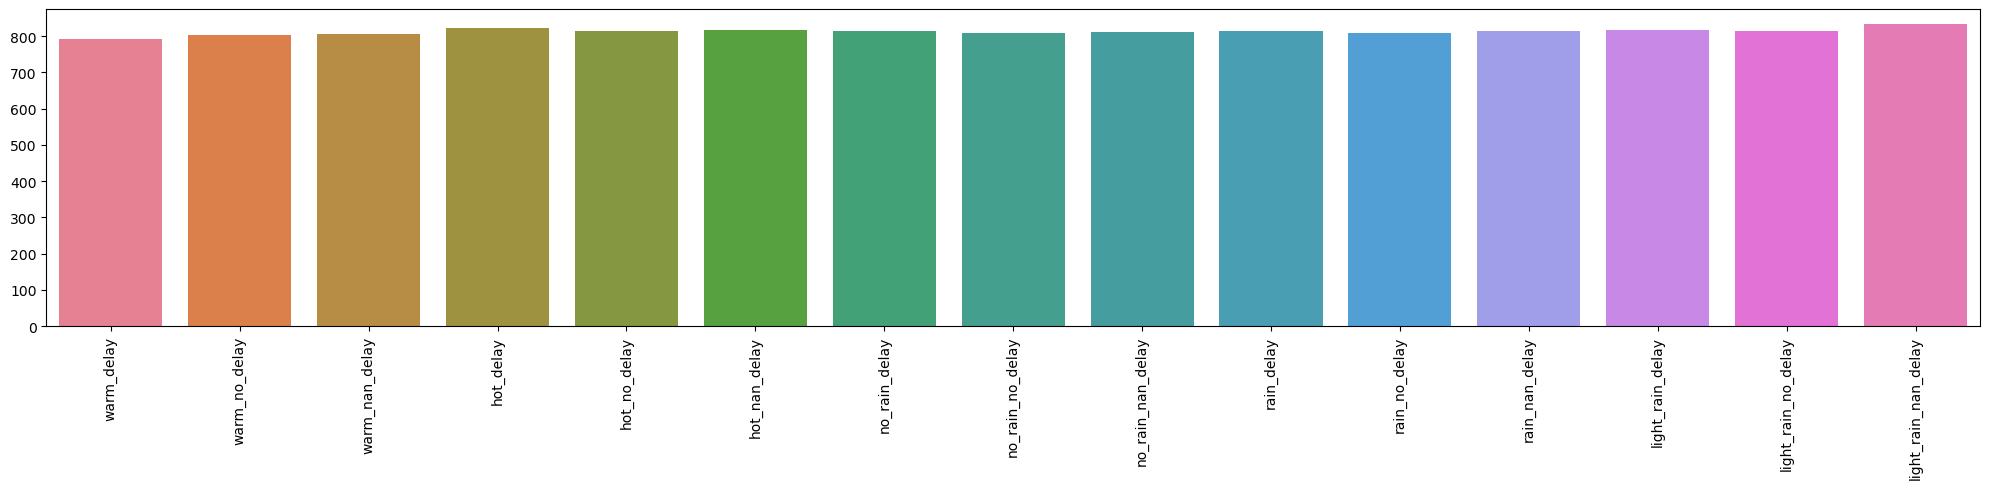

In [109]:
# Next Trip Duration End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_03.iloc[[27]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_End_Duration.png')
plt.show()

In [110]:
desc_03_T = desc_03.T

In [111]:
desc_03_New = desc_03_T[['(data) complete trips', '(data) tier trips count sum', '(tier) tier data trip', '(tier) trip start and end at station count', '(data) next trips count sum' ,'(next) nextdata trip', ' (next) trip start and end at station count']]

In [112]:
desc_03_New['possible trips tier'] =  desc_03_New['(data) tier trips count sum'] / desc_03_New['(tier) tier data trip']
desc_03_New['possible trips next'] =  desc_03_New['(data) next trips count sum'] / desc_03_New['(next) nextdata trip']
desc_03_New['tier end amount'] =  desc_03_New['(tier) trip start and end at station count'] / desc_03_New['(tier) tier data trip']
desc_03_New['next end amount'] =  desc_03_New[' (next) trip start and end at station count'] / desc_03_New['(next) nextdata trip']

desc_03_New['tier per trip '] =  desc_03_New['(tier) tier data trip'] / desc_03_New['(data) complete trips']
desc_03_New['tier end per trip '] =  desc_03_New['(tier) trip start and end at station count'] / desc_03_New['(data) complete trips']
desc_03_New['next per trip '] =  desc_03_New['(next) nextdata trip'] / desc_03_New['(data) complete trips']
desc_03_New['next end per trip '] =  desc_03_New[' (next) trip start and end at station count'] / desc_03_New['(data) complete trips']

/tmp/ipykernel_3118112/2010212401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_03_New['possible trips tier'] =  desc_03_New['(data) tier trips count sum'] / desc_03_New['(tier) tier data trip']
/tmp/ipykernel_3118112/2010212401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_03_New['possible trips next'] =  desc_03_New['(data) next trips count sum'] / desc_03_New['(next) nextdata trip']
/tmp/ipykernel_3118112/2010212401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [113]:
inde = 0
desc_03_New['stops'] = 0

for i in range(0, int((len(desc_03_New)/3))):
    desc_03_New['stops'].iloc[inde] = len(delay['stop_name'].unique())
    desc_03_New['stops'].iloc[inde+1] = len(no_delay['stop_name'].unique())
    desc_03_New['stops'].iloc[inde+2] = len(nan_delay['stop_name'].unique())
    
    inde = inde + 3

/tmp/ipykernel_3118112/232760720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_03_New['stops'] = 0
/tmp/ipykernel_3118112/232760720.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single 

In [114]:
desc_03_New

Unnamed: 0           (data) complete trips (data) tier trips count sum  \
warm_delay                          399470                        4003   
warm_no_delay                       258974                        6130   
warm_nan_delay                      431069                        6535   
hot_delay                           550796                        8469   
hot_no_delay                        341204                       12050   
hot_nan_delay                       574544                       12532   
no_rain_delay                       815264                       11048   
no_rain_no_delay                    513631                       16063   
no_rain_nan_delay                   853143                       16570   
rain_delay                          950266                       12472   
rain_no_delay                       600178                       18180   
rain_nan_delay                     1005613                       19067   
light_rain_delay                    108219                        1117   
light_rain_no_delay                  69130                        1750   
light_rain_nan_delay                122679                        2085   

Unnamed: 0           (tier) tier data trip  \
warm_delay                            2766   
warm_no_delay                         2462   
warm_nan_delay                        3339   
hot_delay                             5852   
hot_no_delay                          4762   
hot_nan_delay                         6658   
no_rain_delay                         7618   
no_rain_no_delay                      6397   
no_rain_nan_delay                     8720   
rain_delay                            8611   
rain_no_delay                         7212   
rain_nan_delay                        9977   
light_rain_delay                       801   
light_rain_no_delay                    705   
light_rain_nan_delay                  1087   

Unnamed: 0           (tier) trip start and end at station count  \
warm_delay                                                 1277   
warm_no_delay                                              1114   
warm_nan_delay                                             1523   
hot_delay                                                  2623   
hot_no_delay                                               2122   
hot_nan_delay                                              2959   
no_rain_delay                                              3464   
no_rain_no_delay                                           2869   
no_rain_nan_delay                                          3930   
rain_delay                                                 3896   
rain_no_delay                                              3228   
rain_nan_delay                                             4472   
light_rain_delay                                            344   
light_rain_no_delay                                         316   
light_rain_nan_delay                                        468   

Unnamed: 0           (data) next trips count sum (next) nextdata trip  \
warm_delay                                 10275                 7121   
warm_no_delay                              14067                 6197   
warm_nan_delay                             16800                 8968   
hot_delay                                  23209                15108   
hot_no_delay                               27138                11388   
hot_nan_delay                              31398                16573   
no_rain_delay                              30086                19859   
no_rain_no_delay                           36715                15618   
no_rain_nan_delay                          42752                22726   
rain_delay                                 33484                22212   
rain_no_delay                              41205                17551   
rain_nan_delay                             48198                25521   
light_rain_delay                            2702        

In [115]:
desc_03_New['tier trip per station '] =  desc_03_New['(tier) tier data trip'] / desc_03_New['stops']
desc_03_New['next trip per station '] =  desc_03_New['(next) nextdata trip'] / desc_03_New['stops']

/tmp/ipykernel_3118112/1400643834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_03_New['tier trip per station '] =  desc_03_New['(tier) tier data trip'] / desc_03_New['stops']
/tmp/ipykernel_3118112/1400643834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_03_New['next trip per station '] =  desc_03_New['(next) nextdata trip'] / desc_03_New['stops']


In [116]:
desc_03_New

Unnamed: 0           (data) complete trips (data) tier trips count sum  \
warm_delay                          399470                        4003   
warm_no_delay                       258974                        6130   
warm_nan_delay                      431069                        6535   
hot_delay                           550796                        8469   
hot_no_delay                        341204                       12050   
hot_nan_delay                       574544                       12532   
no_rain_delay                       815264                       11048   
no_rain_no_delay                    513631                       16063   
no_rain_nan_delay                   853143                       16570   
rain_delay                          950266                       12472   
rain_no_delay                       600178                       18180   
rain_nan_delay                     1005613                       19067   
light_rain_delay                    108219                        1117   
light_rain_no_delay                  69130                        1750   
light_rain_nan_delay                122679                        2085   

Unnamed: 0           (tier) tier data trip  \
warm_delay                            2766   
warm_no_delay                         2462   
warm_nan_delay                        3339   
hot_delay                             5852   
hot_no_delay                          4762   
hot_nan_delay                         6658   
no_rain_delay                         7618   
no_rain_no_delay                      6397   
no_rain_nan_delay                     8720   
rain_delay                            8611   
rain_no_delay                         7212   
rain_nan_delay                        9977   
light_rain_delay                       801   
light_rain_no_delay                    705   
light_rain_nan_delay                  1087   

Unnamed: 0           (tier) trip start and end at station count  \
warm_delay                                                 1277   
warm_no_delay                                              1114   
warm_nan_delay                                             1523   
hot_delay                                                  2623   
hot_no_delay                                               2122   
hot_nan_delay                                              2959   
no_rain_delay                                              3464   
no_rain_no_delay                                           2869   
no_rain_nan_delay                                          3930   
rain_delay                                                 3896   
rain_no_delay                                              3228   
rain_nan_delay                                             4472   
light_rain_delay                                            344   
light_rain_no_delay                                         316   
light_rain_nan_delay                                        468   

Unnamed: 0           (data) next trips count sum (next) nextdata trip  \
warm_delay                                 10275                 7121   
warm_no_delay                              14067                 6197   
warm_nan_delay                             16800                 8968   
hot_delay                                  23209                15108   
hot_no_delay                               27138                11388   
hot_nan_delay                              31398                16573   
no_rain_delay                              30086                19859   
no_rain_no_delay                           36715                15618   
no_rain_nan_delay                          42752                22726   
rain_delay                                 33484                22212   
rain_no_delay                              41205                17551   
rain_nan_delay                             48198                25521   
light_rain_delay                            2702        

In [117]:
T_03 = desc_03_New.T
T_03

warm_delay warm_no_delay  \
Unnamed: 0                                                             
(data) complete trips                           399470        258974   
(data) tier trips count sum                       4003          6130   
(tier) tier data trip                             2766          2462   
(tier) trip start and end at station count        1277          1114   
(data) next trips count sum                      10275         14067   
(next) nextdata trip                              7121          6197   
 (next) trip start and end at station count       3352          3087   
possible trips tier                           1.447216      2.489846   
possible trips next                           1.442915      2.269969   
tier end amount                               0.461678      0.452478   
next end amount                                0.47072      0.498144   
tier per trip                                 0.006924      0.009507   
tier end per trip                             0.003197      0.004302   
next per trip                                 0.017826      0.023929   
next end per trip                             0.008391       0.01192   
stops                                              479           508   
tier trip per station                          5.77453      4.846457   
next trip per station                        14.866388     12.198819   

                                            warm_nan_delay  hot_delay  \
Unnamed: 0                                                              
(data) complete trips                               431069     550796   
(data) tier trips count sum                           6535       8469   
(tier) tier data trip                                 3339       5852   
(tier) trip start and end at station count            1523       2623   
(data) next trips count sum                          16800      23209   
(next) nextdata trip                                  8968      15108   
 (next) trip start and end at station count           4420       7068   
possible trips tier                               1.957173   1.447198   
possible trips next                               1.873327   1.536206   
tier end amount                                   0.456125   0.448223   
next end amount                                   0.492864   0.467832   
tier per trip                                     0.007746   0.010625   
tier end per trip                                 0.003533   0.004762   
next per trip                                     0.020804   0.027429   
next end per trip                                 0.010254   0.012832   
stops                                                  513        479   
tier trip per station                             6.508772  12.217119   
next trip per station                            17.481481   31.54071   

                                            hot_no_delay hot_nan_delay  \
Unnamed: 0                                                               
(data) complete trips                             341204        574544   
(data) tier trips count sum                        12050         12532   
(tier) tier data trip                               4762          6658   
(tier) trip start and end at station count          2122          2959   
(data) next trips count sum                        27138         31398   
(next) nextdata trip                               11388         16573   
 (next) trip start and end at station count         5695          8223   
possible trips tier                             2.530449      1.882247   
possible trips next                             2.383035      1.894527   
tier end amount                                 0.445611      0.444428   
next end amount                                 0.500088      0.496168   
tier per trip                                   0.013956      0.011588   
tier end per trip                               0.006219       0.00515   
next per trip                   

In [118]:
T_03.to_csv("Tables/T_03.csv")

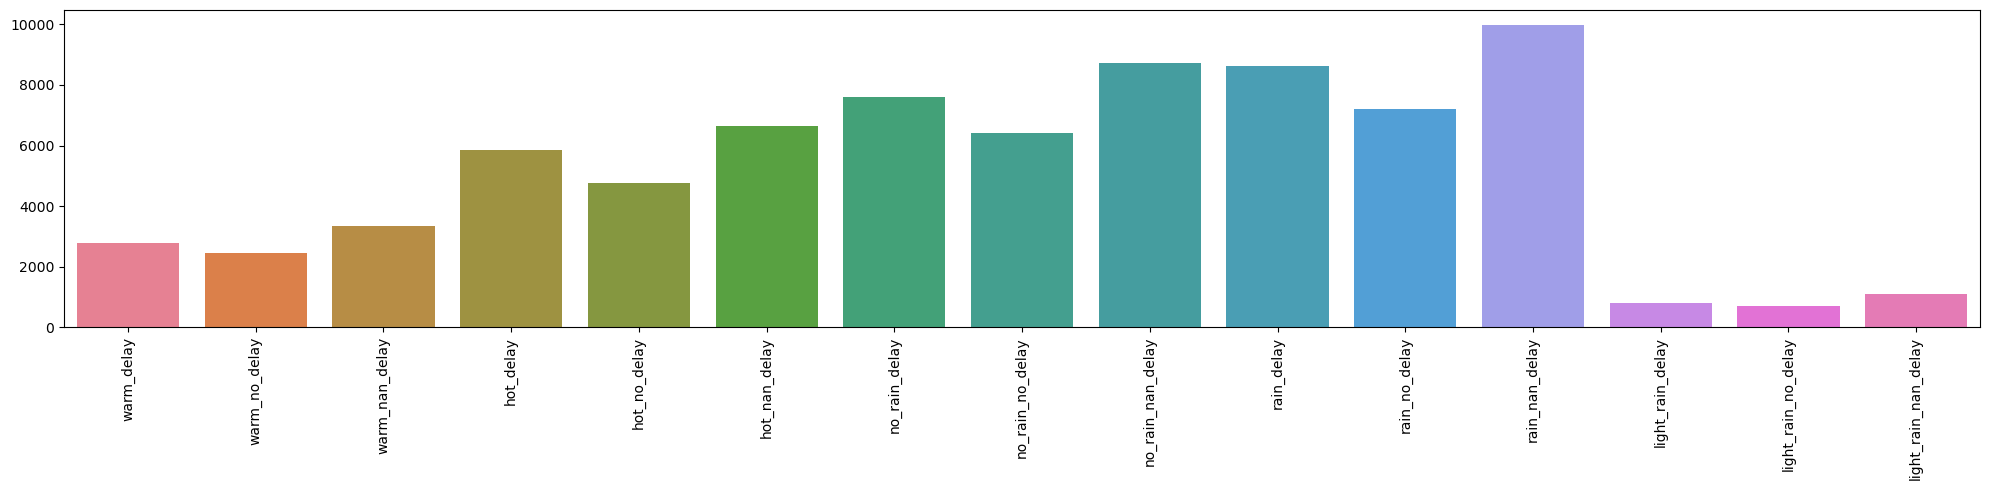

In [119]:
# Tier Trip Count
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[2]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_Count.png')
plt.show()

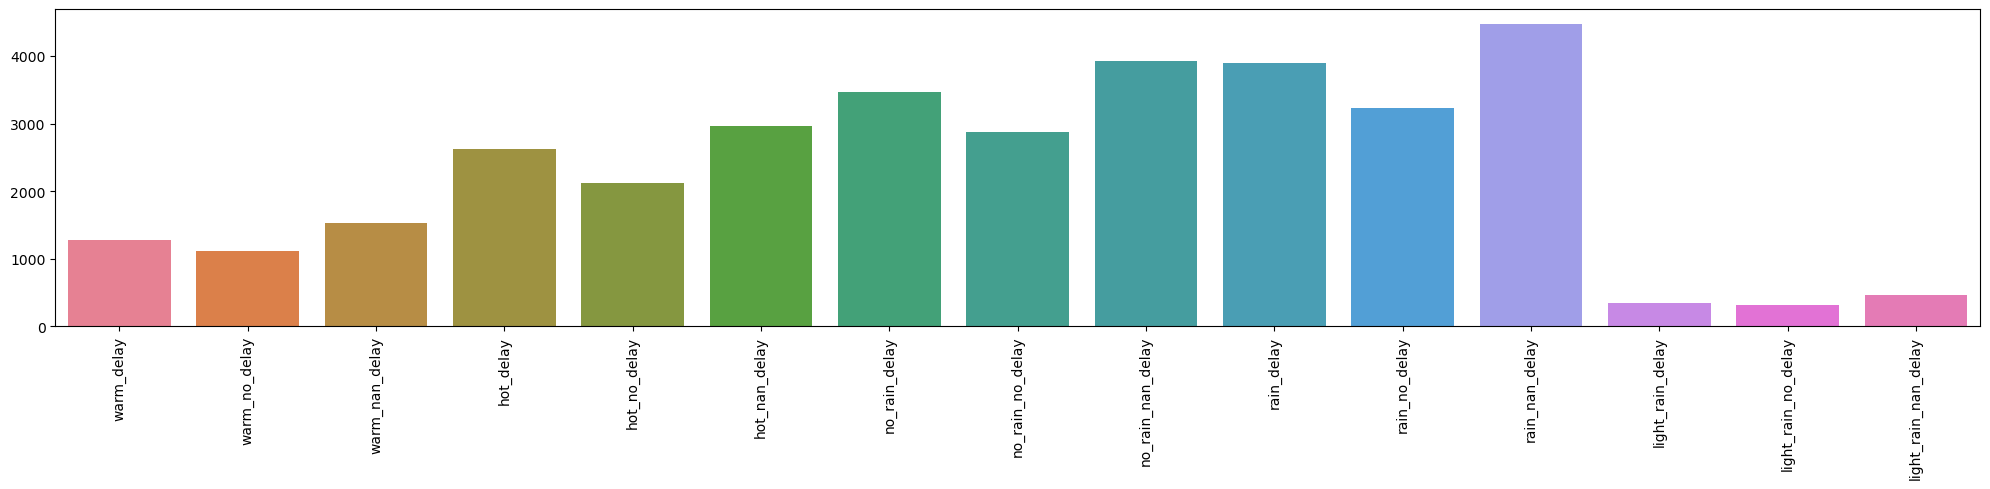

In [120]:
# Tier Trip Count End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[3]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_End_Count.png')
plt.show()

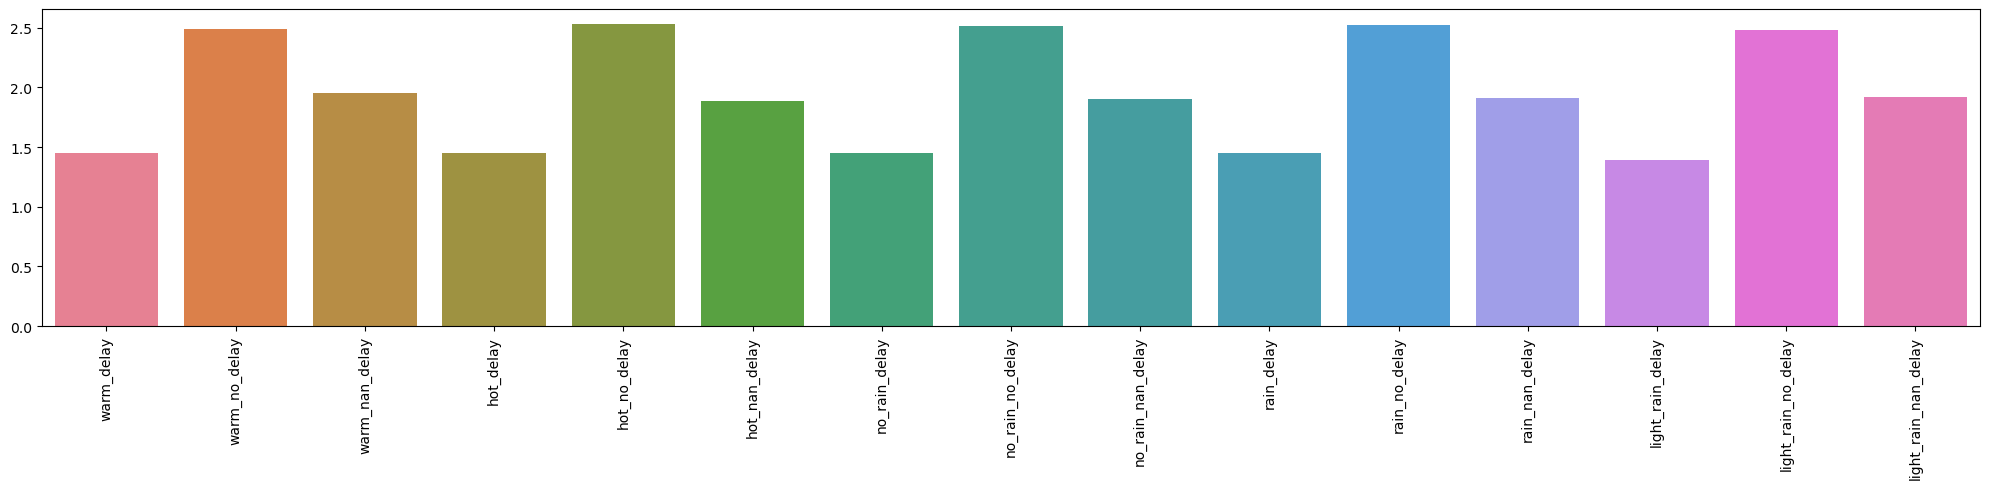

In [121]:
# Possible tier trips
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[7]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_Possible_PT_Trips.png')
plt.show()

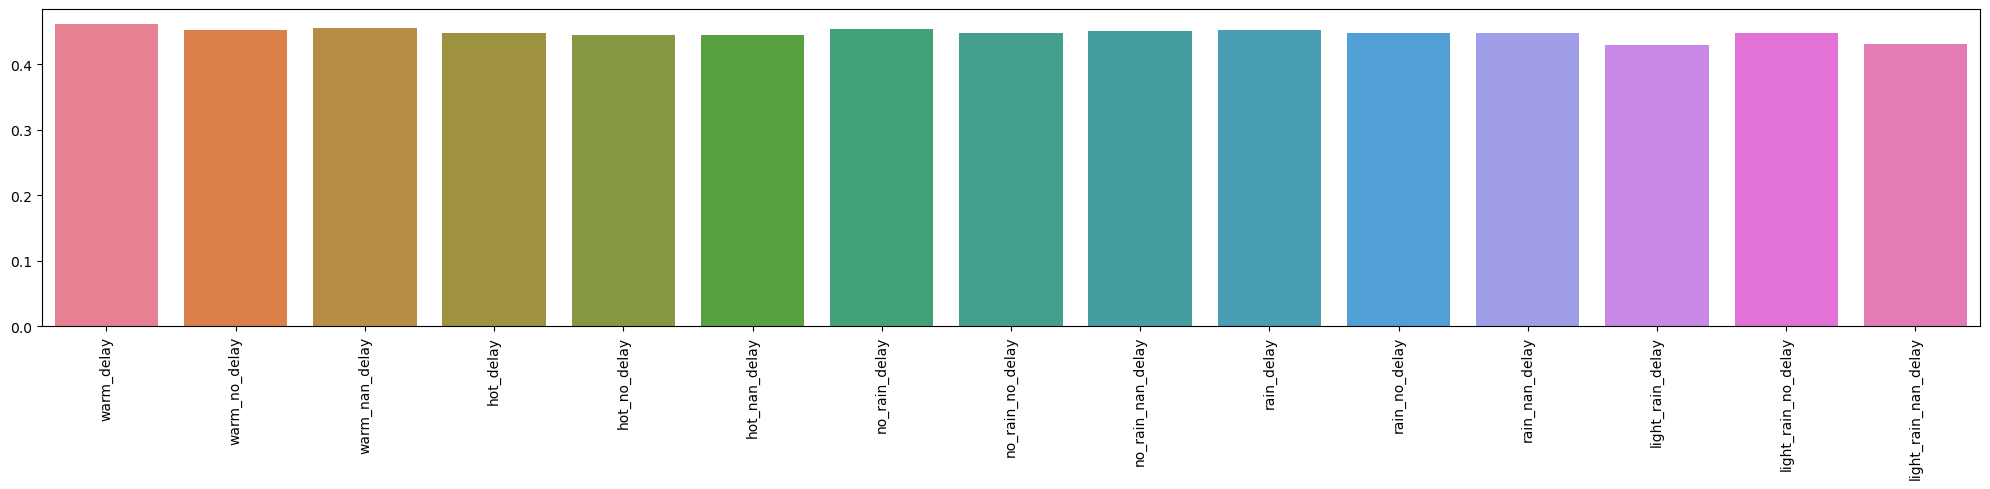

In [122]:
# Tier end amount
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[9]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_End_Percentage.png')
plt.show()

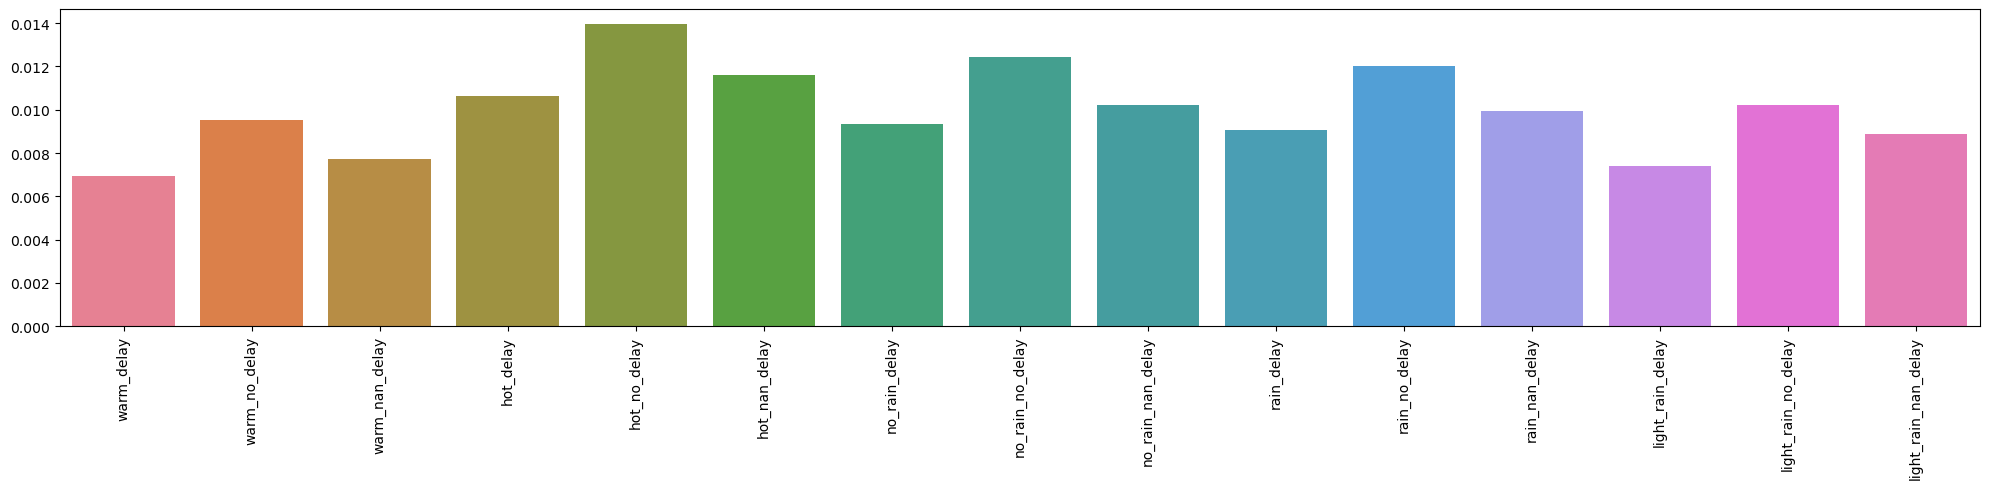

In [123]:
# Tier per trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[11]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_per_PT_Trip.png')
plt.show()

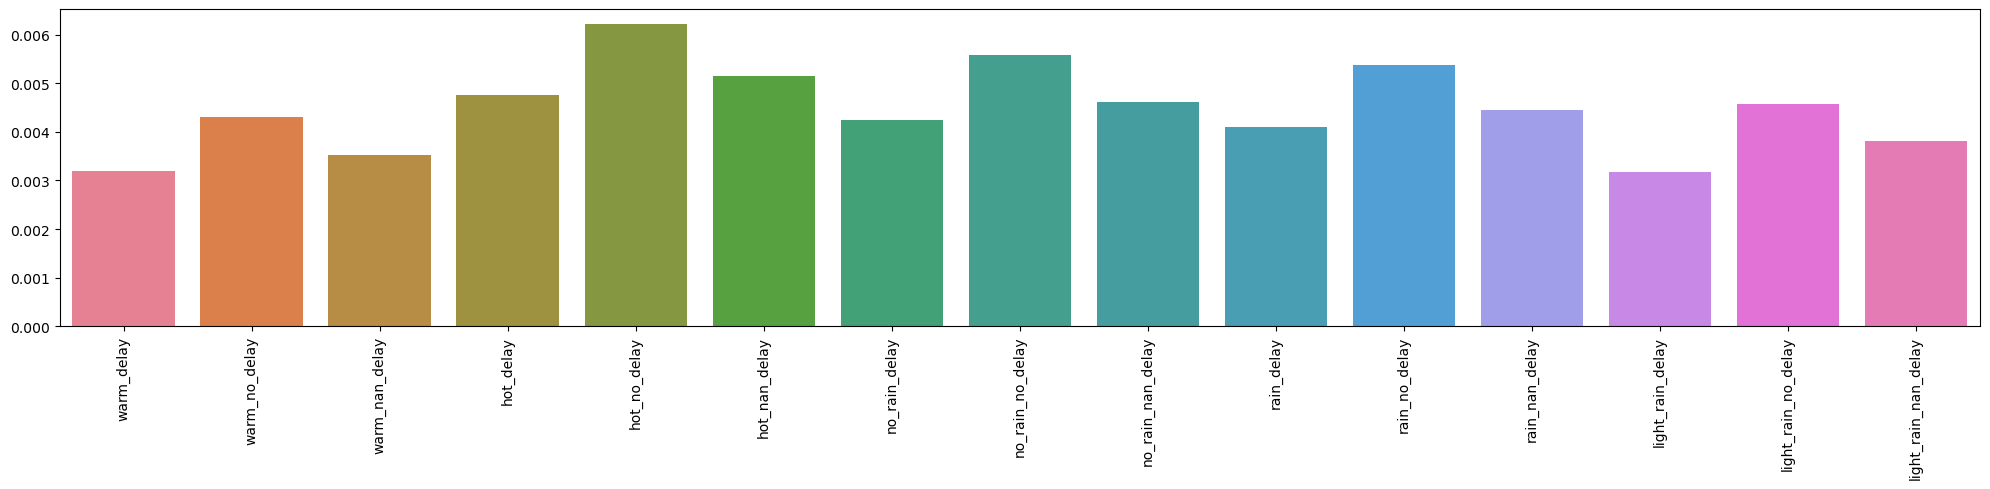

In [124]:
# Tier per trip end
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[12]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_End_per_Trip.png')
plt.show()

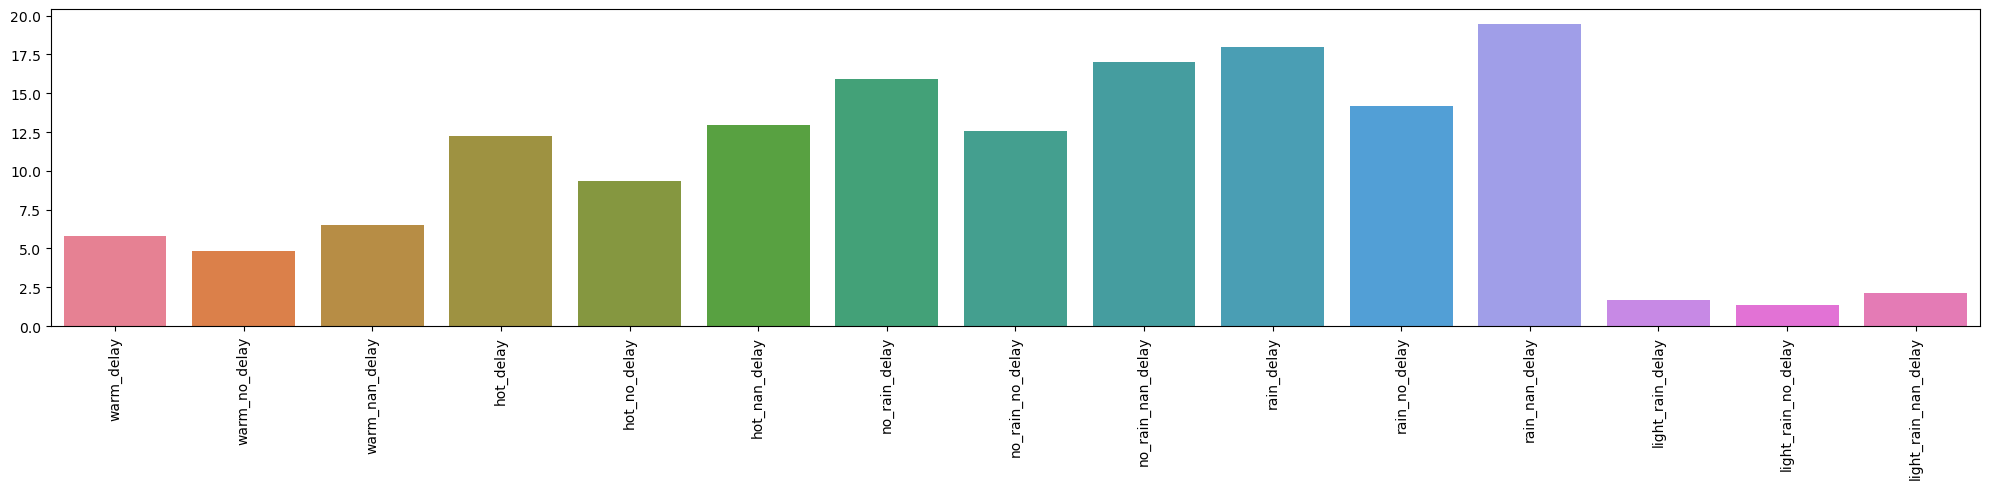

In [125]:
# Tiertrip per station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[16]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Tier_per_Station.png')
plt.show()

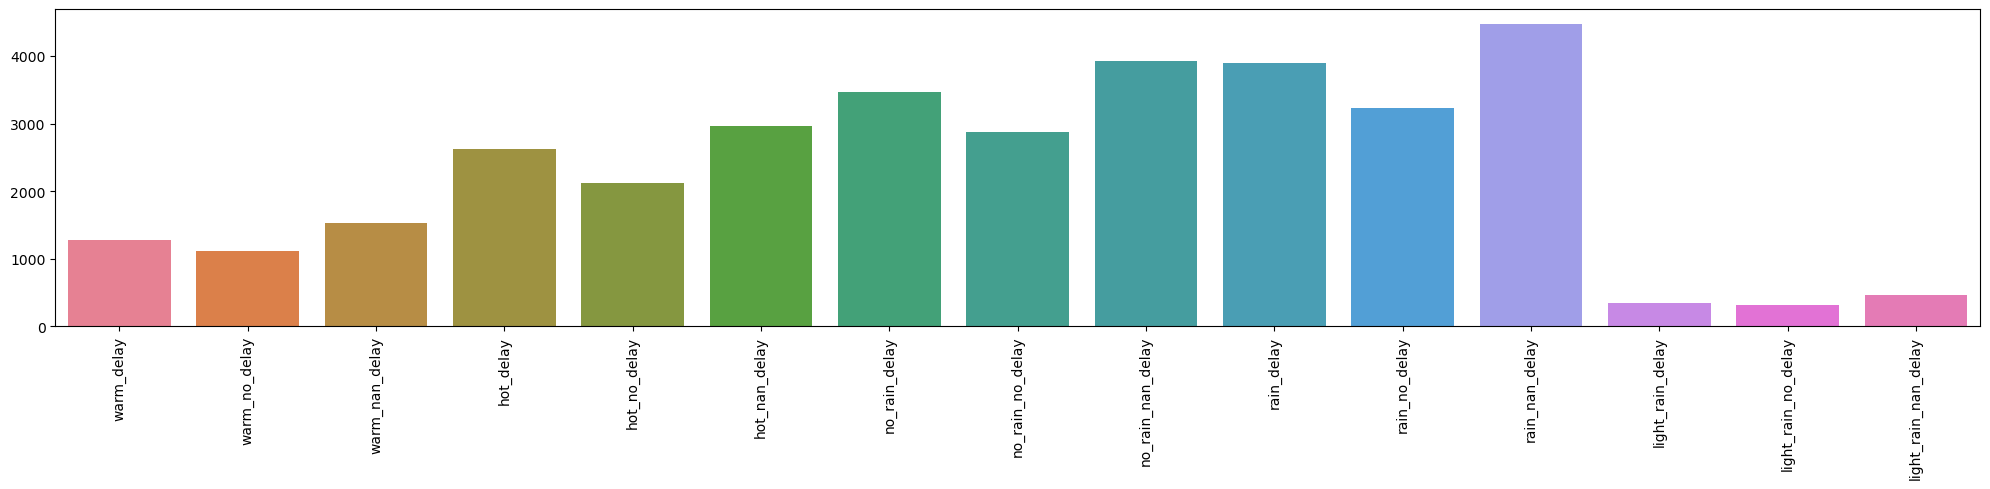

In [126]:
# Next Trip Count
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[3]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_Count.png')
plt.show()

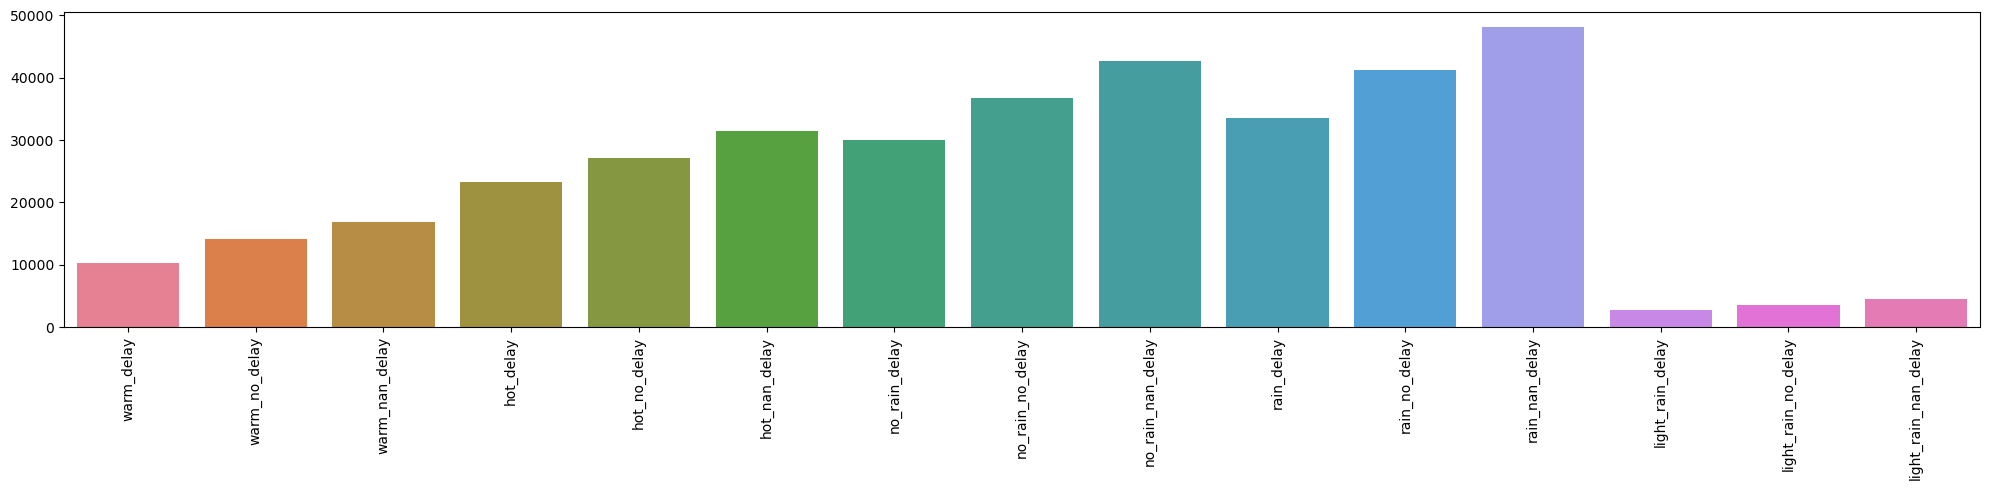

In [127]:
# Next Trip Count End
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[4]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_End_Count.png')
plt.show()

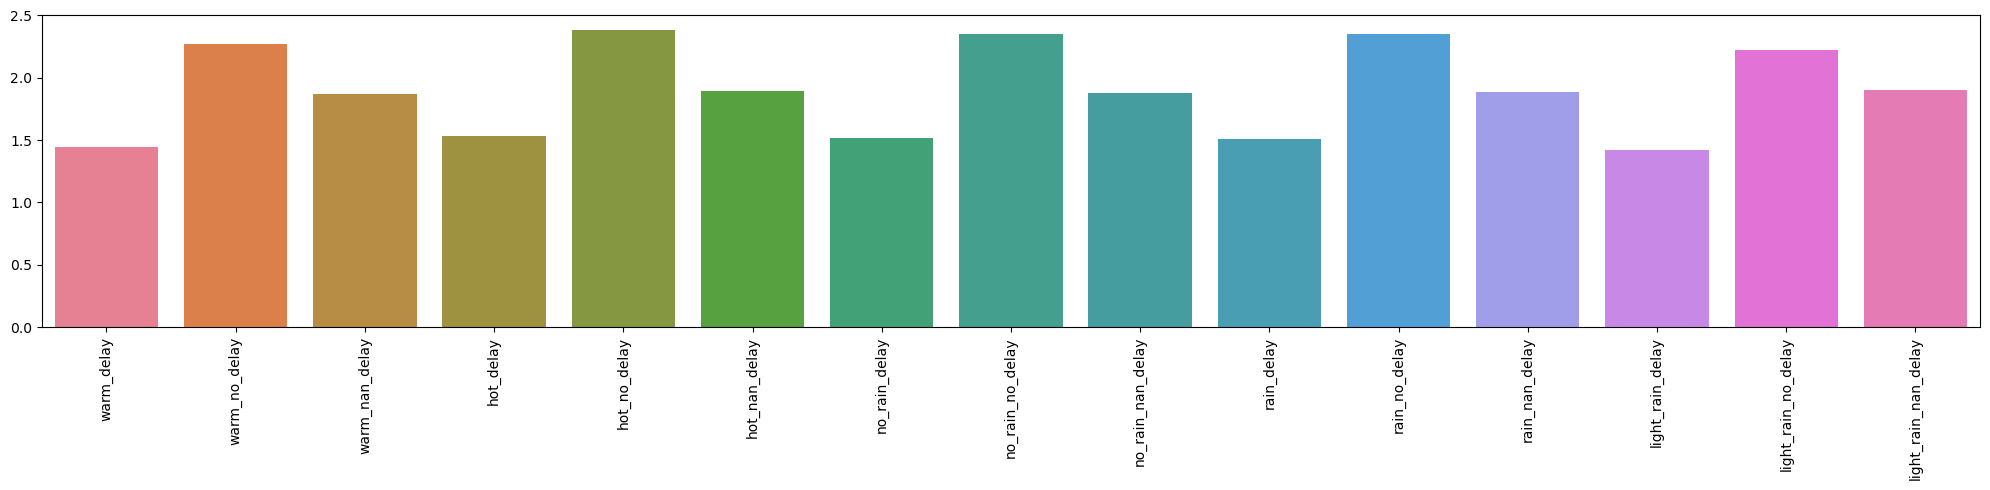

In [128]:
# Possible tier trips
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[8]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_Possible_PT_trips.png')
plt.show()

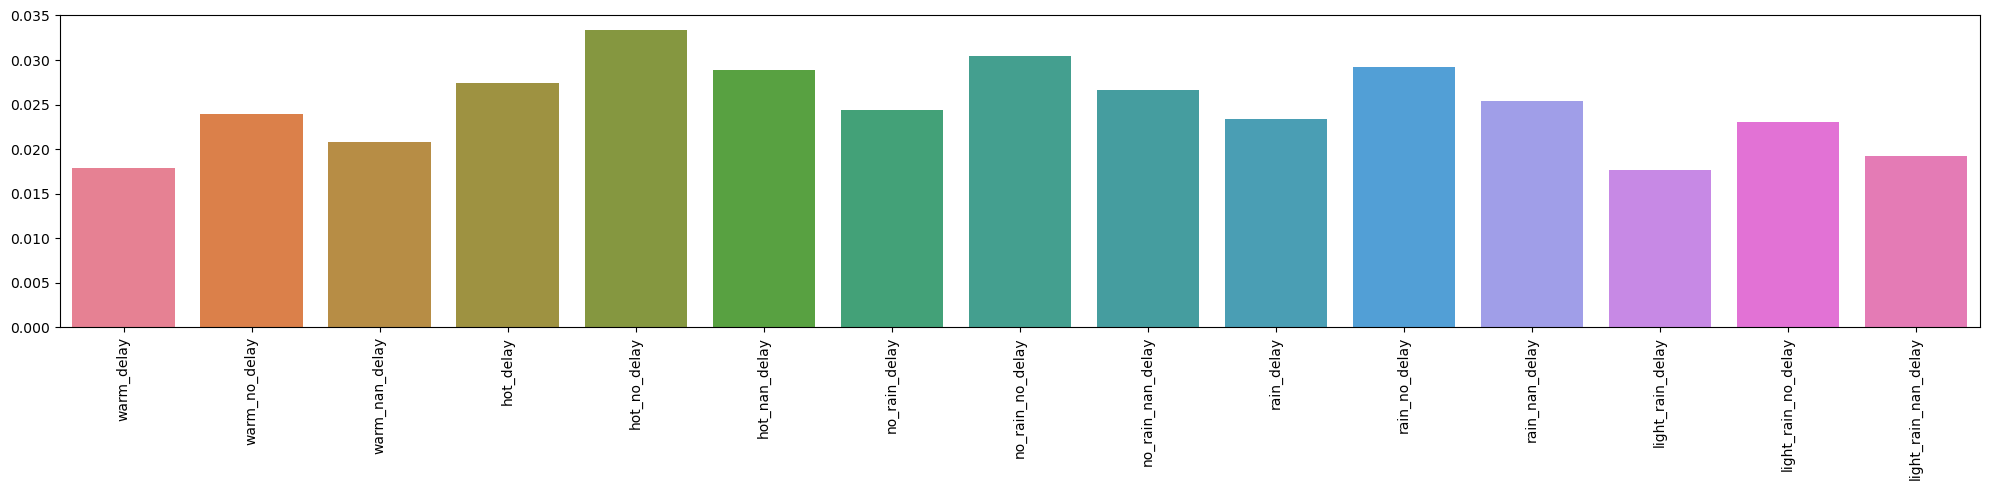

In [129]:
# Next per trip
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[13]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_per_PT_Trip.png')
plt.show()

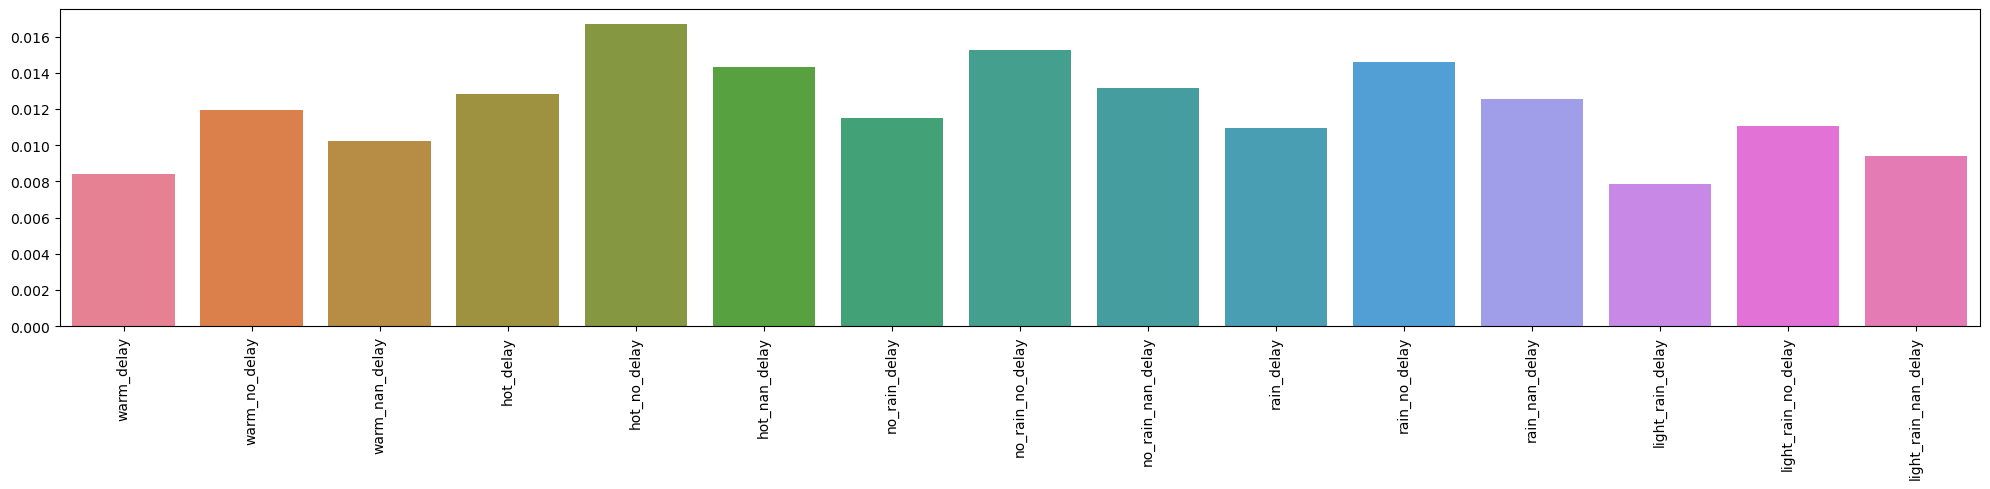

In [130]:
# next per trip end
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[14]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_End_per_PT_trip.png')
plt.show()

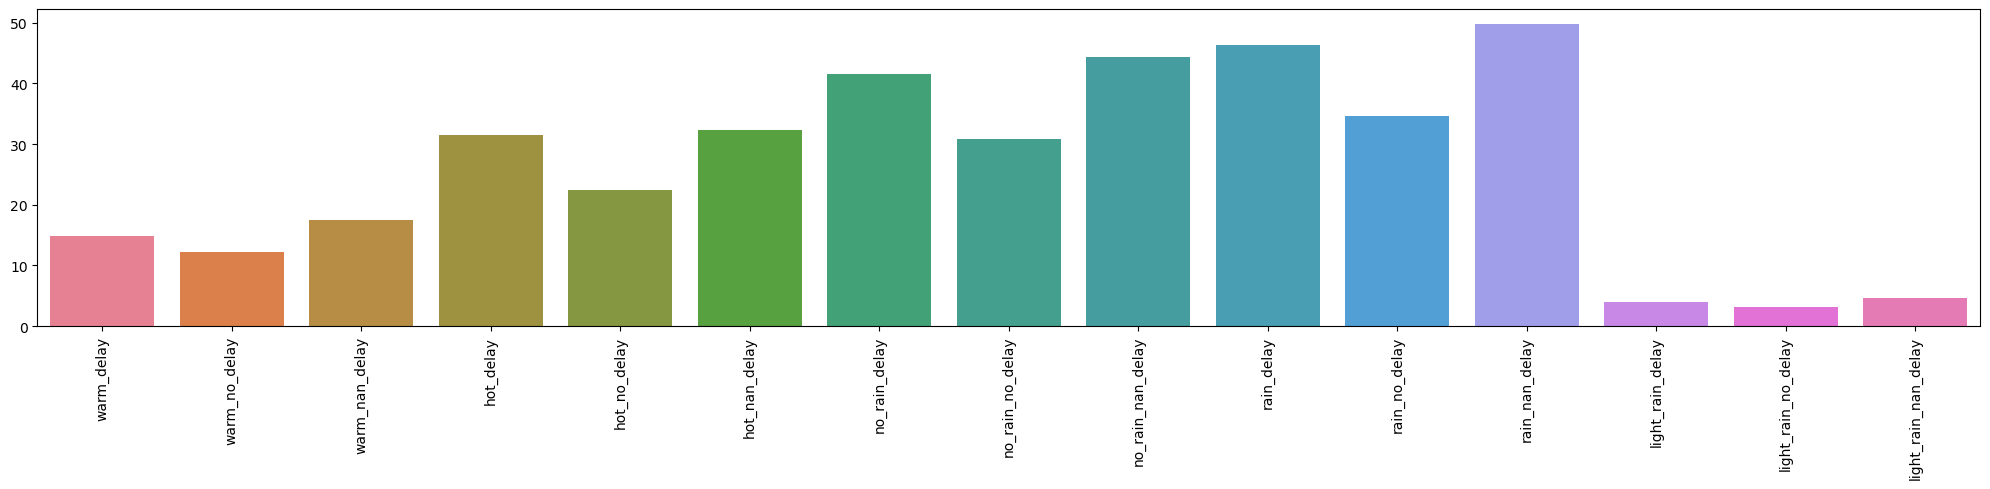

In [131]:
# next trip per station
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=T_03.iloc[[17]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_per_Station.png')
plt.show()

### Desc 04

In [132]:
desc_04

Unnamed: 0      delay_0_5  \
0                               (data) complete trips         941443   
1                         (data) tier trips count sum          12358   
2                              (data) tier trips mean         0.0131   
3          (data) tier trips end at station count sum          10086   
4          (data) tier trips end at station count sum         0.0107   
5                               (tier) tier data trip           8532   
6                               (tier) trip avg lengt         1.7321   
7                            (tier) trip length range  0,1 - 13,9087   
8                            (tier) trip duration avg        846.744   
9                          (tier) trip duration range     300 - 6900   
10         (tier) trip start and end at station count           3859   
11   (tier) trip start and end at station mean length         1.4194   
12  (tier) trip start and end at station range length   0,1 - 9,0938   
13  (tier) trip start and end at station mean dura...       773.1433   
14  (tier) trip start and end at station range dur...     300 - 6300   
15                        (data) next trips count sum          33367   
16                            (data) next trips mean          0.0354   
17               (data) next end at station count sum          28067   
18              (data) next end at station count mean         0.0298   
19                               (next) nextdata trip          22128   
20                              (next) trip avg lengt         1.7328   
21                           (next) trip length range  0,1 - 14,1433   
22                      (next) trip duration average        891.2039   
23                         (next) trip duration range     300 - 7200   
24         (next) trip start and end at station count          10377   
25   (next) trip start and end at station mean length         1.4315   
26  (next) trip start and end at station range length   0,1 - 9,6407   
27  (next) trip start and end at station mean dura...       813.2929   
28  (next) trip start and end at station range dur...     300 - 7200   

          delay_5_10     delay_10_15    delay_15_20      delay_20_30  \
0               2454             762           1520             1602   
1                 22               3             27                8   
2              0.009          0.0039         0.0178            0.005   
3                 19               3             22                7   
4             0.0077          0.0039         0.0145           0.0044   
5                 22               3             27                7   
6             2.4108          1.0185         1.5274           1.3549   
7   0,7309 - 10,1238  0,6302 - 1,364   0,13 - 3,127   0,277 - 2,2994   
8           845.4545            1100       944.4444         771.4286   
9         300 - 2400      600 - 2100     300 - 5700        600 - 900   
10                11               0              0                1   
11            1.4586               0              0           1.2795   
12   0,4365 - 3,1635               0              0           1.2795   
13          681.8181               0              0              900   
14        300 - 1200               0              0              900   
15                52               1             18               20   
16            0.0212          0.0013         0.0118           0.0125   
17                43               0             10               13   
18            0.0175               0         0.0066           0.0081   
19                52               1             18               20   
20             1.781          0.1543         1.7196           1.5913   
21    0,165 - 5,7622          0.1543  0,16 - 5,1706  0,3767 - 4,1415   
22          842.3077             300       866.6667              825   
23        300 - 2100             300     300 - 2400       300 - 1500   
24                29               0              0                3   
25        

In [133]:
desc_04 = desc_04.set_index(desc_04.columns[0])

In [134]:
desc_04.to_csv("Tables/Desc_04.csv")

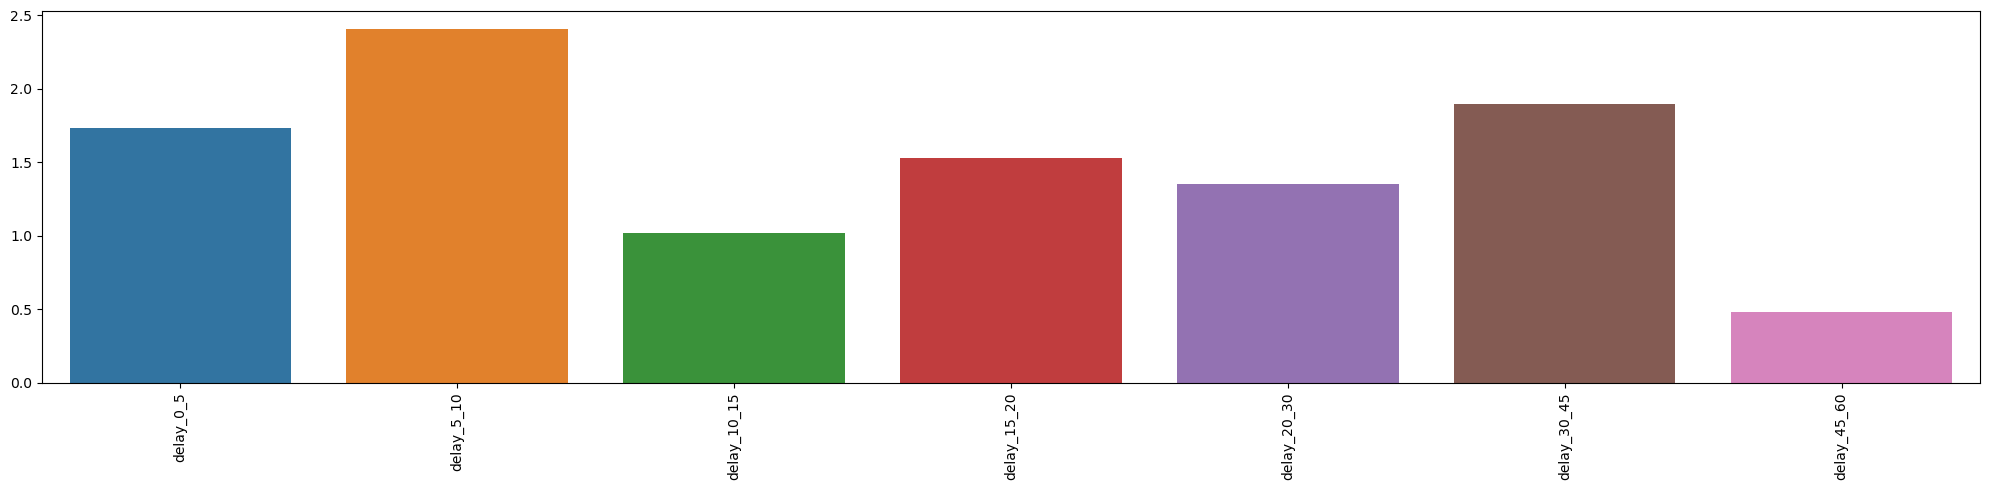

In [135]:
# Tier trips length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[6]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Tier_Length.png')
plt.show()

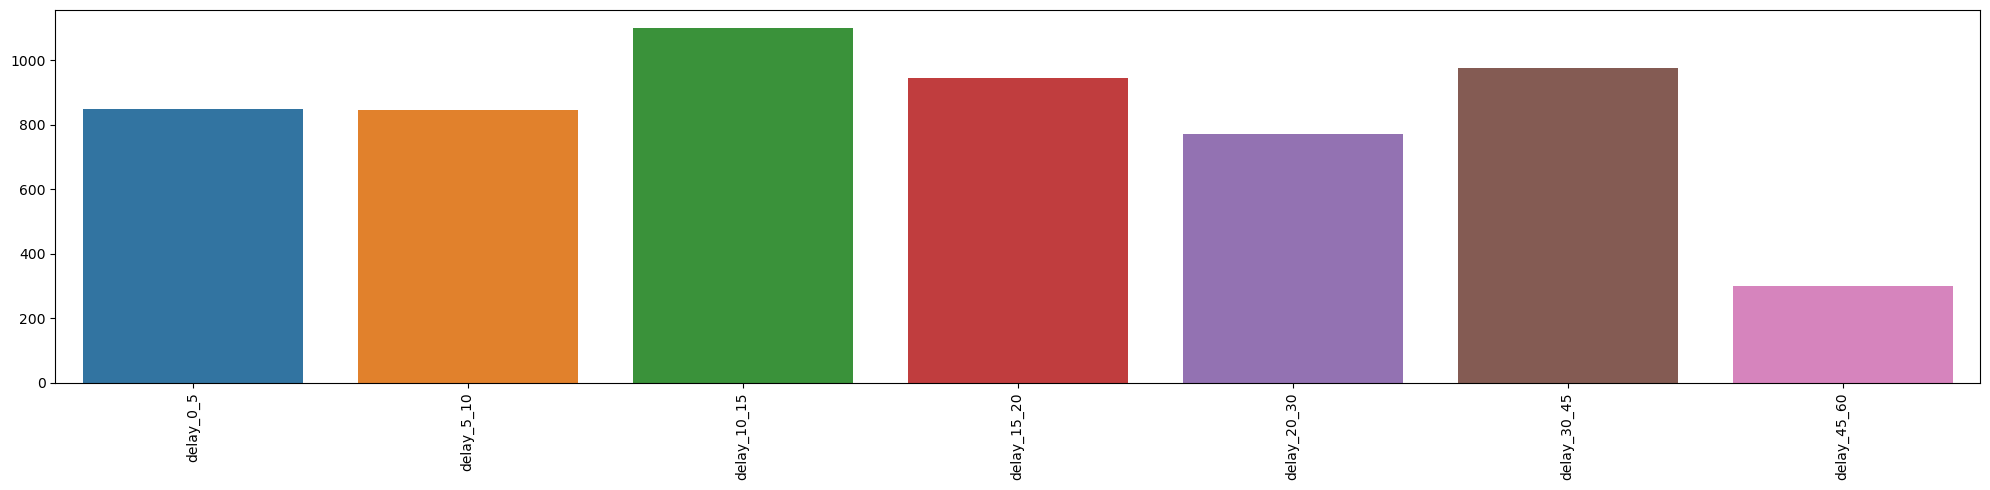

In [136]:
# Tier trips duration
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[8]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Tier_Duration.png')
plt.show()

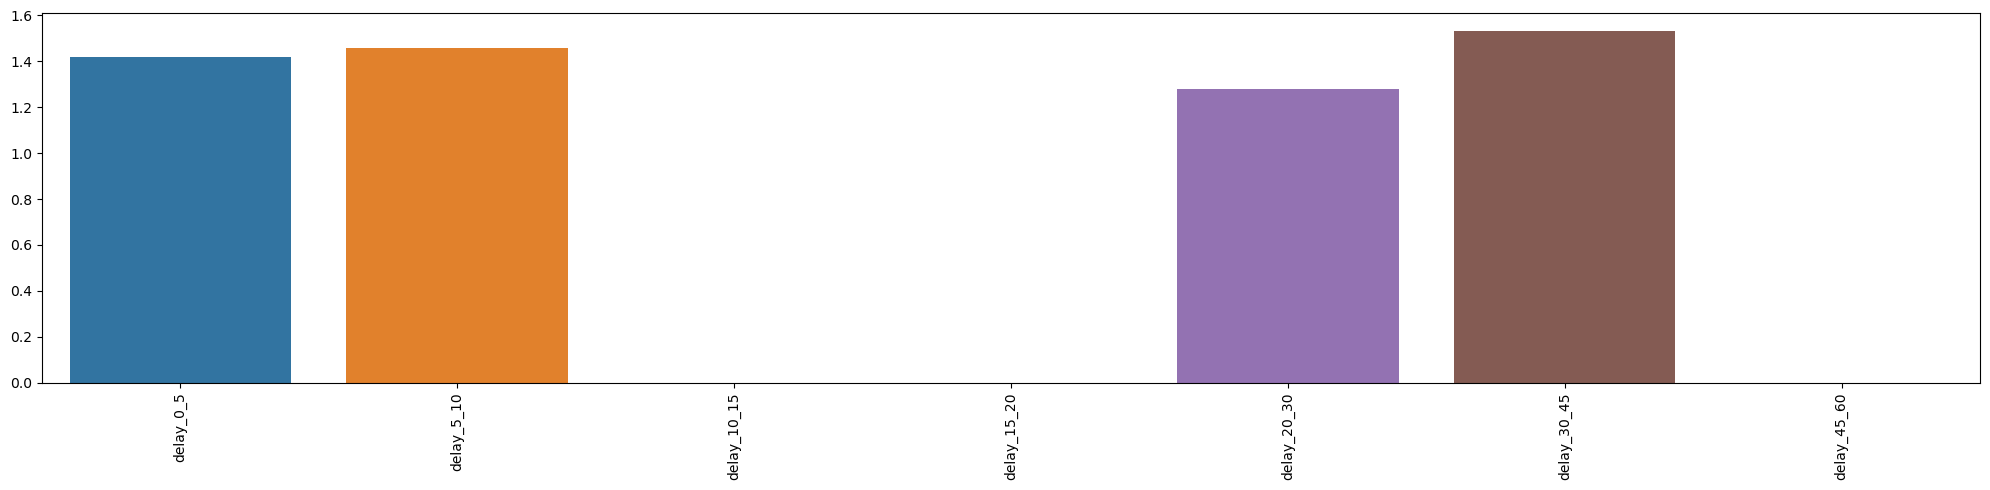

In [137]:
# Tier trips length end
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[11]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Tier_End_Length.png')
plt.show()

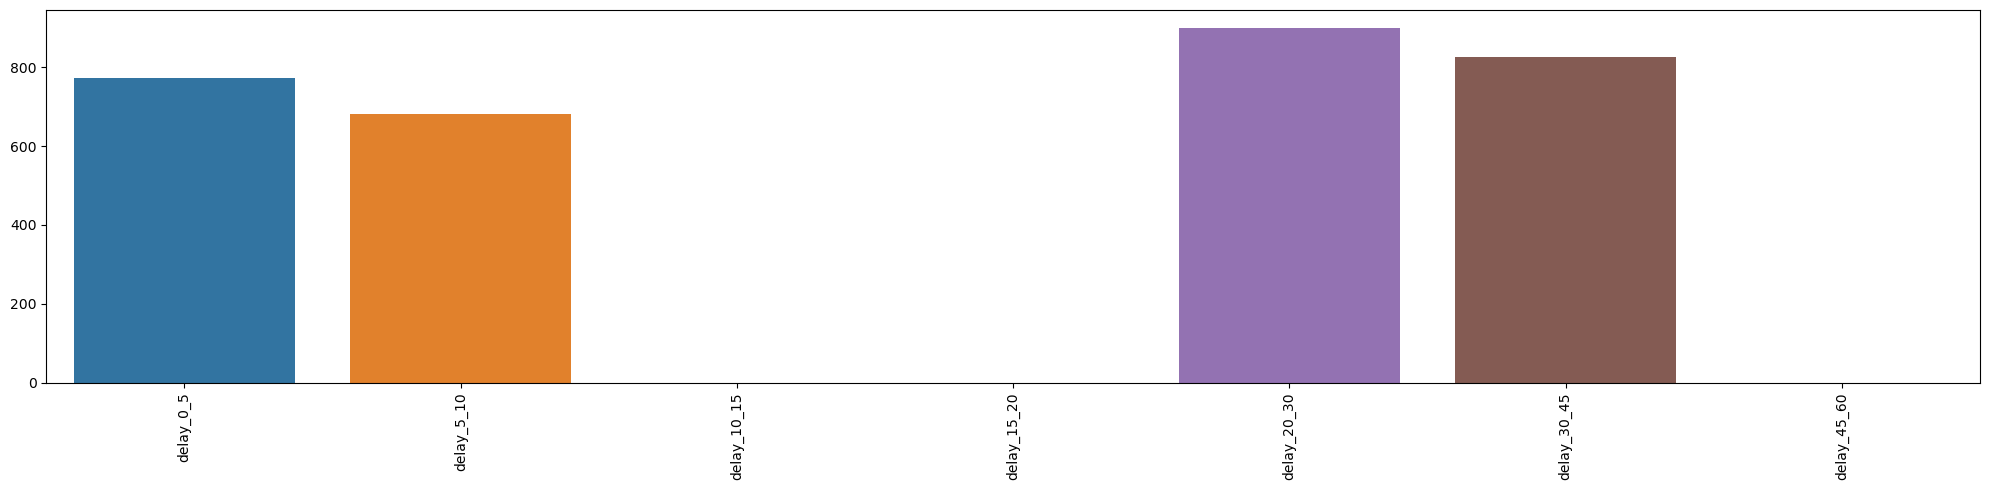

In [138]:
# Tier trips length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[13]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Tier_End_Duration.png')
plt.show()

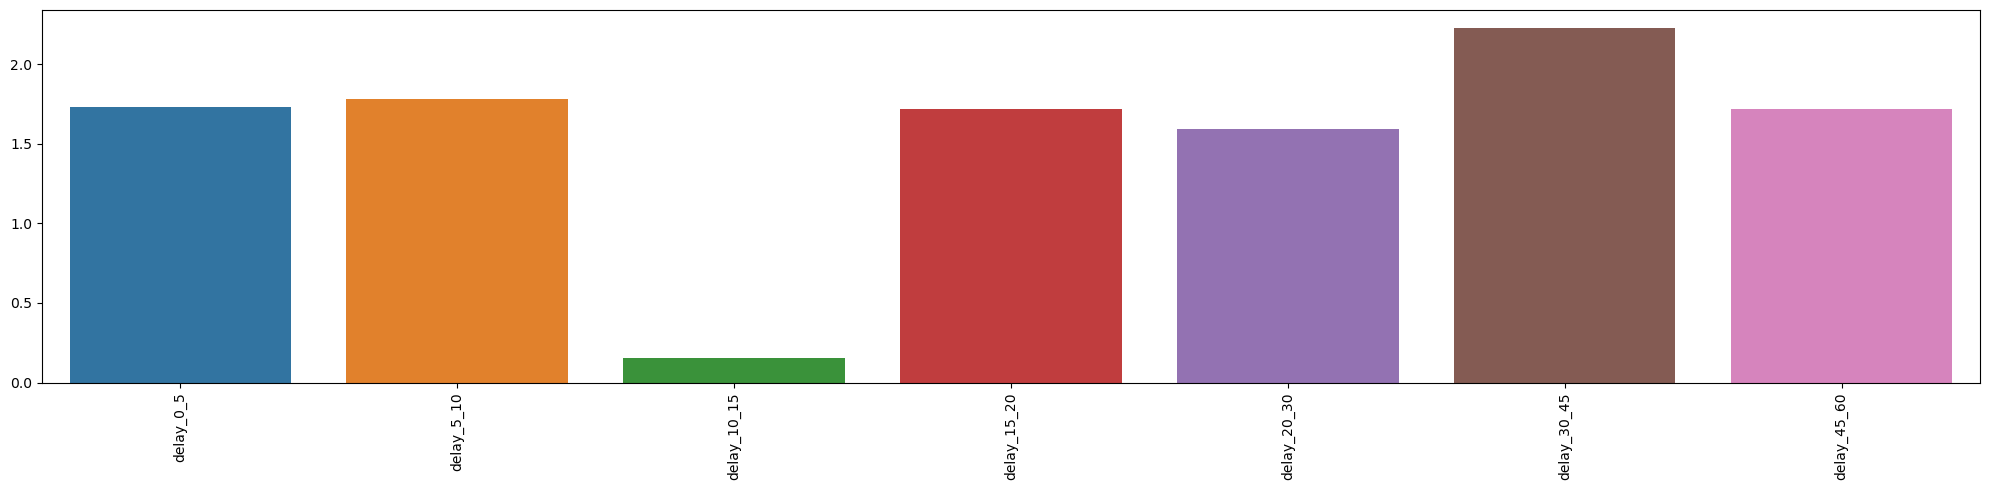

In [139]:
# Next trips length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[20]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Next_Length.png')
plt.show()

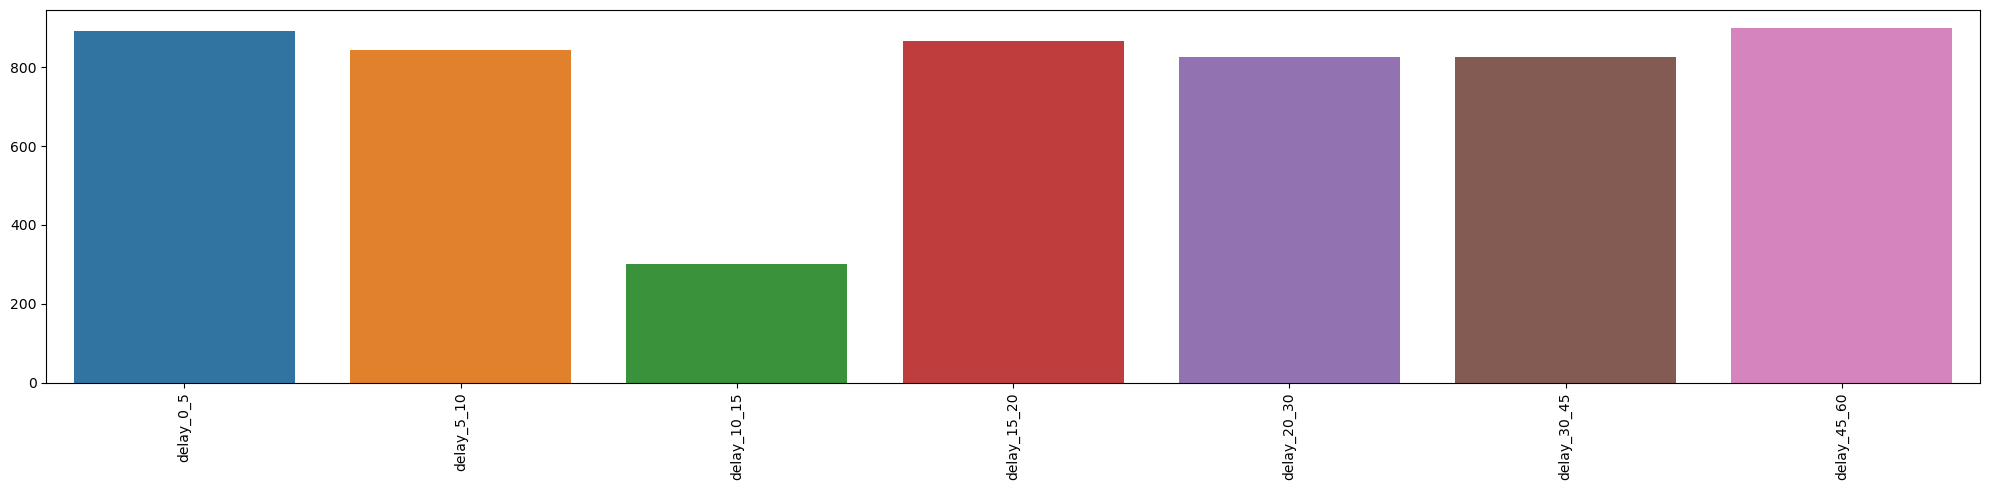

In [140]:
# next trips duration
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[22]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/03_Next_Duration.png')
plt.show()

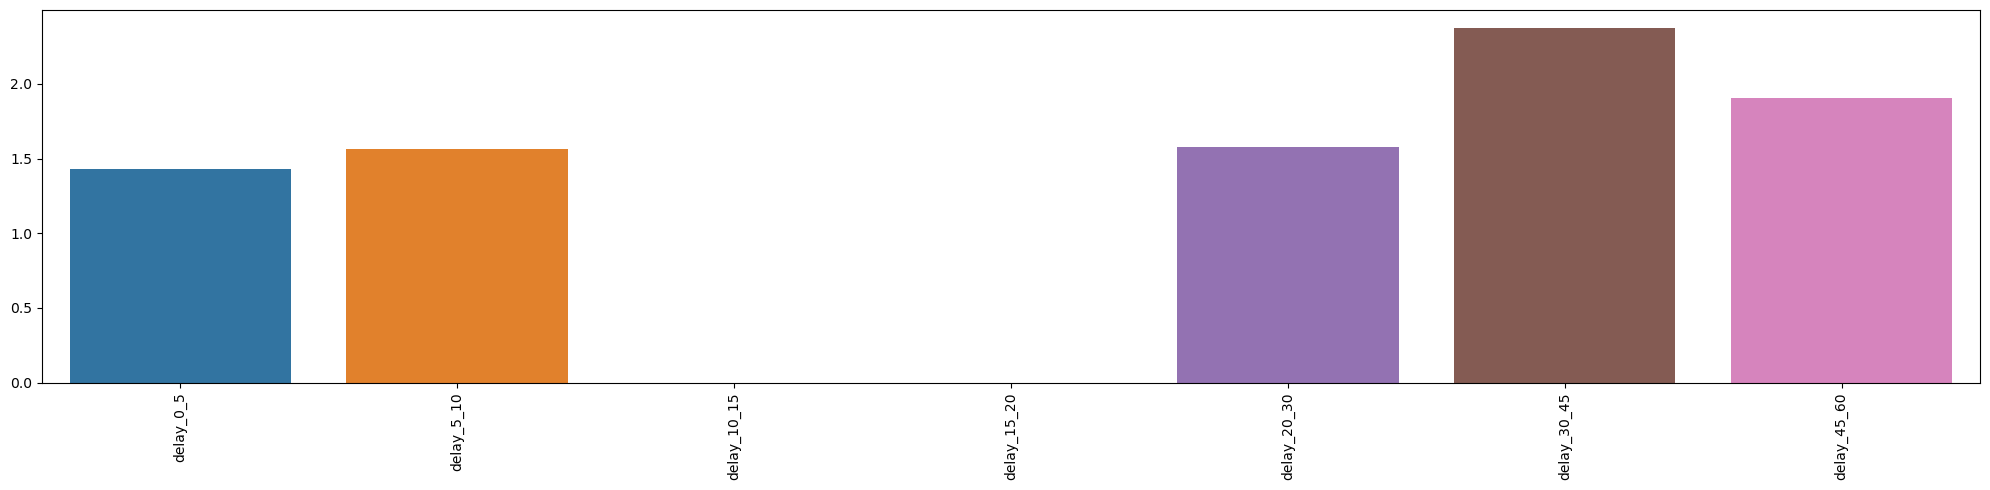

In [141]:
# next trips length end
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[25]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Next_End_Length.png')
plt.show()

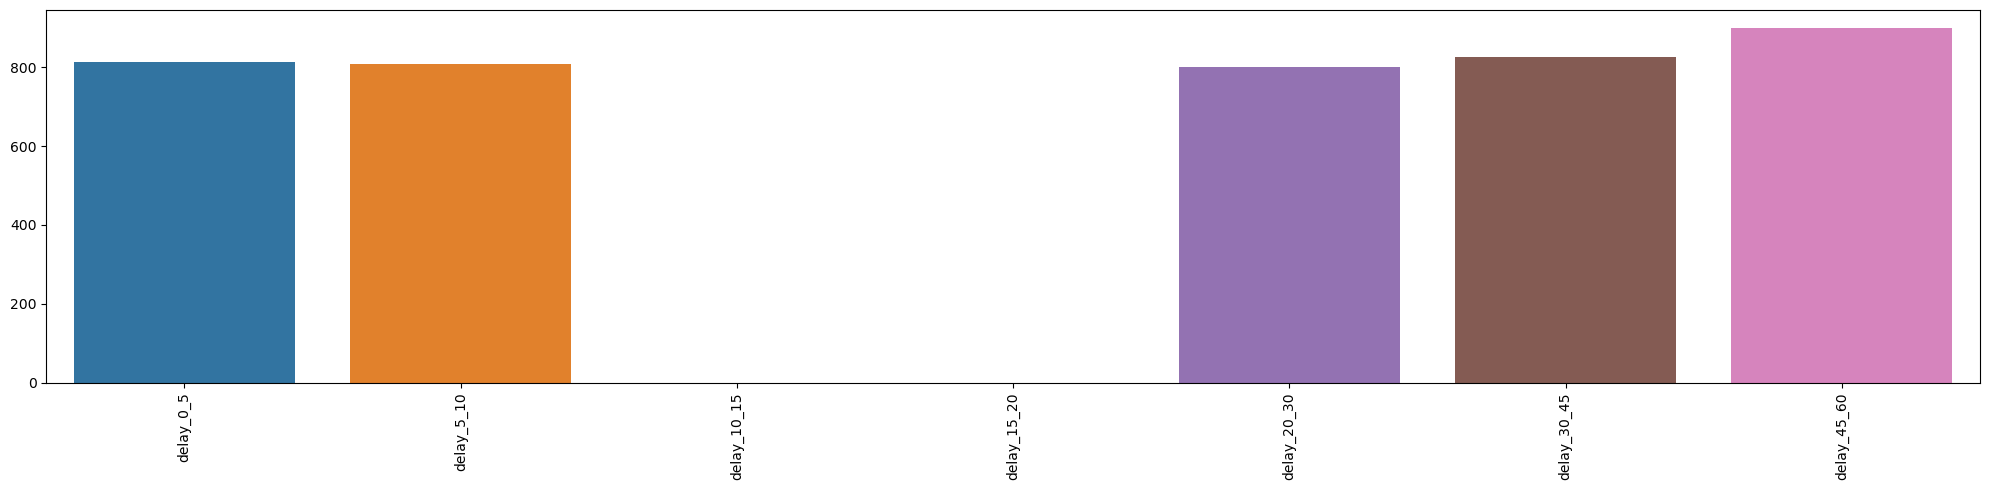

In [142]:
# next trips duration end
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[27]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Next_End_Duration.png')
plt.show()

In [143]:
desc_04_T = desc_04.T

In [144]:
desc_04_New = desc_04_T[['(data) complete trips', '(data) tier trips count sum', '(tier) tier data trip', '(tier) trip start and end at station count', '(data) next trips count sum' ,'(next) nextdata trip', ' (next) trip start and end at station count']]

In [145]:
desc_04_New

Unnamed: 0  (data) complete trips (data) tier trips count sum  \
delay_0_5                  941443                       12358   
delay_5_10                   2454                          22   
delay_10_15                   762                           3   
delay_15_20                  1520                          27   
delay_20_30                  1602                           8   
delay_30_45                  1501                          29   
delay_45_60                   213                           2   

Unnamed: 0  (tier) tier data trip (tier) trip start and end at station count  \
delay_0_5                    8532                                       3859   
delay_5_10                     22                                         11   
delay_10_15                     3                                          0   
delay_15_20                    27                                          0   
delay_20_30                     7                                          1   
delay_30_45                    20                                         16   
delay_45_60                     2                                          0   

Unnamed: 0  (data) next trips count sum (next) nextdata trip  \
delay_0_5                         33367                22128   
delay_5_10                           52                   52   
delay_10_15                           1                    1   
delay_15_20                          18                   18   
delay_20_30                          20                   20   
delay_30_45                          10                    8   
delay_45_60                           4                    4   

Unnamed: 0   (next) trip start and end at station count  
delay_0_5                                         10377  
delay_5_10                                           29  
delay_10_15                                           0  
delay_15_20                                           0  
delay_20_30                                           3  
delay_30_45                                           4  
delay_45_60                                           2

In [146]:
desc_04_New['possible trips tier'] =  desc_04_New['(data) tier trips count sum'] / desc_04_New['(tier) tier data trip']
desc_04_New['possible trips next'] =  desc_04_New['(data) next trips count sum'] / desc_04_New['(next) nextdata trip']
desc_04_New['tier end amount'] =  desc_04_New['(tier) trip start and end at station count'] / desc_04_New['(tier) tier data trip']
desc_04_New['next end amount'] =  desc_04_New[' (next) trip start and end at station count'] / desc_04_New['(next) nextdata trip']

desc_04_New['tier per trip '] =  desc_04_New['(tier) tier data trip'] / desc_04_New['(data) complete trips']
desc_04_New['tier end per trip '] =  desc_04_New['(tier) trip start and end at station count'] / desc_04_New['(data) complete trips']
desc_04_New['next per trip '] =  desc_04_New['(next) nextdata trip'] / desc_04_New['(data) complete trips']
desc_04_New['next end per trip '] =  desc_04_New[' (next) trip start and end at station count'] / desc_04_New['(data) complete trips']

/tmp/ipykernel_3118112/2103887674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_04_New['possible trips tier'] =  desc_04_New['(data) tier trips count sum'] / desc_04_New['(tier) tier data trip']
/tmp/ipykernel_3118112/2103887674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_04_New['possible trips next'] =  desc_04_New['(data) next trips count sum'] / desc_04_New['(next) nextdata trip']
/tmp/ipykernel_3118112/2103887674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [147]:
desc_04_New['stops'] = len(delay['stop_name'].unique())

/tmp/ipykernel_3118112/970680484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_04_New['stops'] = len(delay['stop_name'].unique())


In [148]:
desc_04_New['tier trip per station '] =  desc_04_New['(tier) tier data trip'] / desc_04_New['stops']
desc_04_New['next trip per station '] =  desc_04_New['(next) nextdata trip'] / desc_04_New['stops']

/tmp/ipykernel_3118112/2058324692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_04_New['tier trip per station '] =  desc_04_New['(tier) tier data trip'] / desc_04_New['stops']
/tmp/ipykernel_3118112/2058324692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_04_New['next trip per station '] =  desc_04_New['(next) nextdata trip'] / desc_04_New['stops']


In [149]:
desc_04_New

Unnamed: 0  (data) complete trips (data) tier trips count sum  \
delay_0_5                  941443                       12358   
delay_5_10                   2454                          22   
delay_10_15                   762                           3   
delay_15_20                  1520                          27   
delay_20_30                  1602                           8   
delay_30_45                  1501                          29   
delay_45_60                   213                           2   

Unnamed: 0  (tier) tier data trip (tier) trip start and end at station count  \
delay_0_5                    8532                                       3859   
delay_5_10                     22                                         11   
delay_10_15                     3                                          0   
delay_15_20                    27                                          0   
delay_20_30                     7                                          1   
delay_30_45                    20                                         16   
delay_45_60                     2                                          0   

Unnamed: 0  (data) next trips count sum (next) nextdata trip  \
delay_0_5                         33367                22128   
delay_5_10                           52                   52   
delay_10_15                           1                    1   
delay_15_20                          18                   18   
delay_20_30                          20                   20   
delay_30_45                          10                    8   
delay_45_60                           4                    4   

Unnamed: 0   (next) trip start and end at station count possible trips tier  \
delay_0_5                                         10377            1.448429   
delay_5_10                                           29                 1.0   
delay_10_15                                           0                 1.0   
delay_15_20                                           0                 1.0   
delay_20_30                                           3            1.142857   
delay_30_45                                           4                1.45   
delay_45_60                                           2                 1.0   

Unnamed: 0  possible trips next tier end amount next end amount  \
delay_0_5              1.507909        0.452297        0.468953   
delay_5_10                  1.0             0.5        0.557692   
delay_10_15                 1.0             0.0             0.0   
delay_15_20                 1.0             0.0             0.0   
delay_20_30                 1.0        0.142857            0.15   
delay_30_45                1.25             0.8             0.5   
delay_45_60                 1.0             0.0             0.5   

Unnamed: 0  tier per trip  tier end per trip  next per trip   \
delay_0_5         0.009063           0.004099       0.023504   
delay_5_10        0.008965           0.004482        0.02119   
delay_10_15       0.003937                0.0       0.001312   
delay_15_20       0.017763                0.0       0.011842   
delay_20_30        0.00437           0.000624       0.012484   
delay_30_45       0.013324            0.01066        0.00533   
delay_45_60        0.00939                0.0       0.018779   

Unnamed: 0  next end per trip   stops tier trip per station   \
delay_0_5             0.011022    479              17.812109   
delay_5_10            0.011817    479               0.045929   
delay_10_15                0.0    479               0.006263   
delay_15_20                0.0    479               0.056367   
delay_20_30           0.001873    479               0.014614   
delay_30_45           0.002665    479               0.041754   
delay_45_60            0.00939    479               0.004175   

Unnamed: 0  next trip per station   
delay_0_5                46.196242  
delay_5_10                0.108559  
delay_10_15       

In [150]:
T_04 = desc_04_New.T
T_04

delay_0_5 delay_5_10 delay_10_15  \
Unnamed: 0                                                                      
(data) complete trips                           941443       2454         762   
(data) tier trips count sum                      12358         22           3   
(tier) tier data trip                             8532         22           3   
(tier) trip start and end at station count        3859         11           0   
(data) next trips count sum                      33367         52           1   
(next) nextdata trip                             22128         52           1   
 (next) trip start and end at station count      10377         29           0   
possible trips tier                           1.448429        1.0         1.0   
possible trips next                           1.507909        1.0         1.0   
tier end amount                               0.452297        0.5         0.0   
next end amount                               0.468953   0.557692         0.0   
tier per trip                                 0.009063   0.008965    0.003937   
tier end per trip                             0.004099   0.004482         0.0   
next per trip                                 0.023504    0.02119    0.001312   
next end per trip                             0.011022   0.011817         0.0   
stops                                              479        479         479   
tier trip per station                        17.812109   0.045929    0.006263   
next trip per station                        46.196242   0.108559    0.002088   

                                            delay_15_20 delay_20_30  \
Unnamed: 0                                                            
(data) complete trips                              1520        1602   
(data) tier trips count sum                          27           8   
(tier) tier data trip                                27           7   
(tier) trip start and end at station count            0           1   
(data) next trips count sum                          18          20   
(next) nextdata trip                                 18          20   
 (next) trip start and end at station count           0           3   
possible trips tier                                 1.0    1.142857   
possible trips next                                 1.0         1.0   
tier end amount                                     0.0    0.142857   
next end amount                                     0.0        0.15   
tier per trip                                  0.017763     0.00437   
tier end per trip                                   0.0    0.000624   
next per trip                                  0.011842    0.012484   
next end per trip                                   0.0    0.001873   
stops                                               479         479   
tier trip per station                          0.056367    0.014614   
next trip per station                          0.037578    0.041754   

                                            delay_30_45 delay_45_60  
Unnamed: 0                                                           
(data) complete trips                              1501         213  
(data) tier trips count sum                          29           2  
(tier) tier data trip                                20           2  
(tier) trip start and end at station count           16           0  
(data) next trips count sum                          10           4  
(next) nextdata trip                                  8           4  
 (next) trip start and end at station count           4           2  
possible trips tier                                1.45         1.0  
possible trips next                                1.25         1.0  
tier end amount                                     0.8         0.0  
next end amount                                     0.5         0.5  
tier per trip                                  0.013324     0.00939  
tier end per trip      

In [151]:
T_04.to_csv("Tables/T_04.csv")

In [152]:
# Tier trips length
plt.rcParams["figure.figsize"] = [20.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data=desc_04.iloc[[13]]) 
plt.xticks(rotation=90)
plt.savefig('./Charts/04_Tier_End_Duration.png')
plt.show()